In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(gridExtra))
suppressMessages(library(GGally))
suppressMessages(library(extracat))
suppressMessages(library(lubridate))
suppressMessages(library(fpc))
suppressMessages(library(mi))
suppressMessages(library('forecast'))
suppressMessages(library('imputeTS'))
suppressMessages(library("xgboost"))
suppressMessages(library(Hmisc))
suppressMessages(library("roll"))
suppressMessages(library(caret))
library(Matrix)
suppressMessages(library(xgboost))

In [2]:
options(repr.plot.width=8, repr.plot.height=4)

### Getting the data files ready

In [3]:
###Marketing campaign start dates and binary features for products/brands
brand_promo <- read_csv("brand_promotions.csv")
product_promo <- read_csv("product_promotions.csv")


###Daily out-of-stock signal by product
oos <- read_csv("daily_product_oos.csv")
colnames(oos)[1] <- "product"
#head(oos)


###A mapping of products to brands
map <- read_csv("product_brand_map.csv",col_names = c("product","brand"))
map$brand <- as.factor(map$brand)
map$product <- as.factor(map$product)

#head(map)

### The main file
###Daily sales data by products (missing some values)
sales <- read_csv("daily_product_sales.csv")
colnames(sales)[1] <- "product" 
#head(sales)

Parsed with column specification:
cols(
  .default = col_integer(),
  start_date = col_date(format = "")
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  start_date = col_date(format = "")
)
See spec(...) for full column specifications.
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  product = col_integer(),
  brand = col_integer()
)
Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_integer()
)
See spec(...) for full column specifications.


In [4]:
tidy_sales = gather(sales,key="date",value="sales" ,-product)
tidy_sales$date <- ymd(tidy_sales$date) #lubridate

In [5]:
tidy_oos = gather(oos,key="date",value="oosflag" ,-product)
tidy_oos$date <- ymd(tidy_oos$date) #lubridate

In [6]:
print(paste(nrow(tidy_sales),ncol(tidy_sales)))
print(paste(nrow(tidy_oos),ncol(tidy_oos)))

[1] "14330000 3"
[1] "14330000 3"


In [7]:
#### Combining the two time-series datasets ###
sales_oos = tidy_sales %>% inner_join(y = tidy_oos, by = c('product','date'))
#sales_oos$date <- ymd(sales_oos$date) #lubridate
print(paste(nrow(sales_oos),ncol(sales_oos)))

[1] "14330000 4"


### Setting a random sample to analyse product features throughout this excercise

In [8]:
set.seed(1234)
smpl = sample(seq(1,10000), 90, replace = FALSE, prob = NULL)

### Impact of Out of Stock (OOS)

### ~0 sales on most of the OOS days

In [9]:
sales_oos %>% filter(product %in% smpl[1:20]) %>% group_by(product, oosflag) %>% summarise(avgsales = mean(sales,na.rm=TRUE)
    ) %>% mutate(oosflag = factor(oosflag)) %>% spread(oosflag,avgsales)

product 0        1
1    95    34.64733 0
2  1138    59.23463 0
3  1864    94.83289 0
4  2318    46.63981 0
5  2324    61.00562 0
6  2664    56.62247 0
7  2824    30.31452 0
8  2858    34.26193 0
9  2920    31.16985 0
10 5138    50.80455 0
11 5444    31.42693 0
12 6092    49.42049 0
13 6223    53.25975 0
14 6232    37.53252 0
15 6400    95.30332 0
16 6656    28.51721 0
17 6929    87.67145 0
18 8361    61.56903 0
19 8606    29.79000 0
20 9223    71.17484 0

### Products OOS 20-25% of the days

In [11]:
sales_oos %>% filter(product %in% smpl[1:20]) %>% group_by(product) %>% summarise(totaloos = sum(oosflag), totalobs = n(),
                                                                                 oospercent = sum(oosflag)/n() )

product totaloos totalobs oospercent
1    95    356      1433     0.2484299 
2  1138    260      1433     0.1814375 
3  1864    304      1433     0.2121424 
4  2318    338      1433     0.2358688 
5  2324    354      1433     0.2470342 
6  2664    244      1433     0.1702722 
7  2824    302      1433     0.2107467 
8  2858    305      1433     0.2128402 
9  2920    373      1433     0.2602931 
10 5138    320      1433     0.2233077 
11 5444    294      1433     0.2051640 
12 6092    309      1433     0.2156315 
13 6223    293      1433     0.2044662 
14 6232    364      1433     0.2540126 
15 6400    278      1433     0.1939986 
16 6656    288      1433     0.2009770 
17 6929    303      1433     0.2114445 
18 8361    287      1433     0.2002791 
19 8606    322      1433     0.2247034 
20 9223    295      1433     0.2058618

Warning message:
"Removed 3 rows containing missing values (geom_point)."

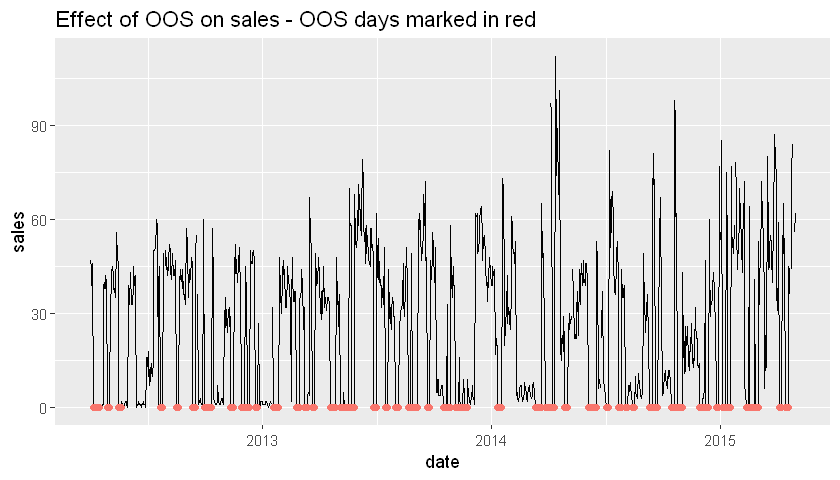

In [19]:
options(repr.plot.width=7, repr.plot.height=4)
ggplot(filter(sales_oos,product %in% c(400) & between(date,ymd('2012-04-01'),ymd('2015-05-01'))), aes(x = date)) +
    geom_line(aes(y=sales)) +
    geom_point(data = select(filter(sales_oos,product==400 & oosflag==1 & between(date,ymd('2012-04-01'),ymd('2015-05-01')
                                                                                 )),date,oossales=sales),
               aes(y=oossales,color="red"))+
    ggtitle("Effect of OOS on sales - OOS days marked in red")+
    theme(legend.position="none")

### Missing data check

In [13]:
summary(sort(apply(oos, 1, function(x) sum(is.na(x))),decreasing=TRUE))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 

In [14]:
summary(sort(apply(sales, 1, function(x) sum(is.na(x))),decreasing=TRUE))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    12.0    14.0    14.3    17.0    31.0 

In [15]:
summary(sort(apply(sales[2:1434], 2, function(x) sum(is.na(x))),decreasing=TRUE))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   73.0    93.0    99.0    99.8   106.0   139.0 

I believe data is missing at random: Most of the columns have ~100 data points missing, most of the rows hav ~1% data missing. Thus data is missing throughout the dataset at random

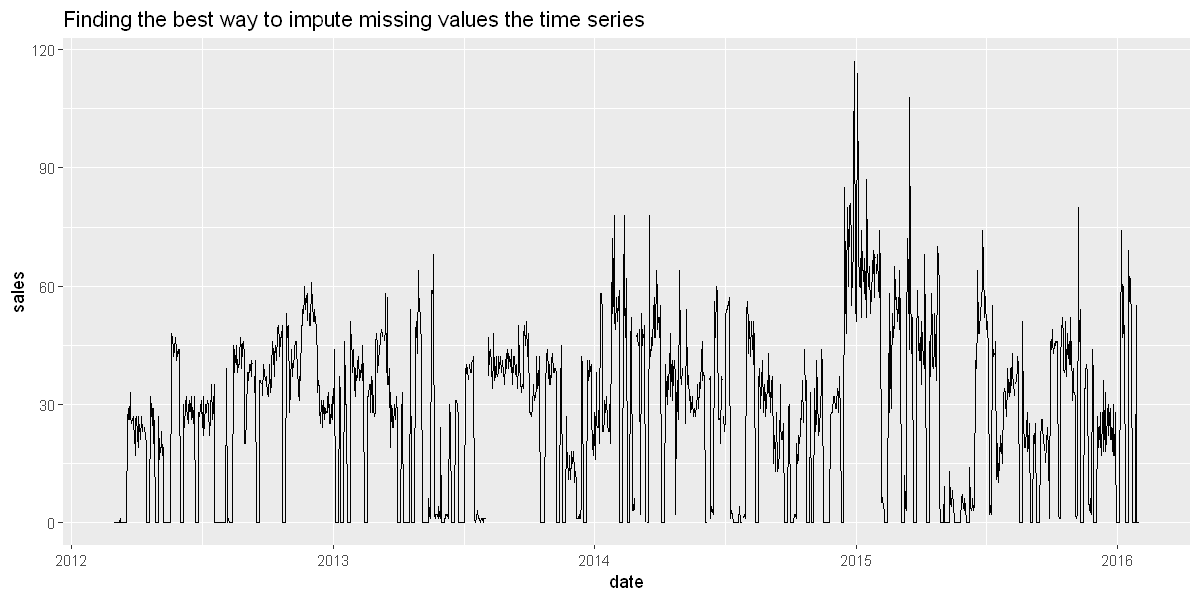

In [21]:
options(repr.plot.width=10, repr.plot.height=5)
ggplot(filter(sales_oos,product %in% c(1) ), aes(x = date)) +
    geom_line(aes(y=sales)) +
    #geom_point(aes(y=oosflag*sales, color = oosflag ==1)) +
    ggtitle("Finding the best way to impute missing values the time series")

https://cran.r-project.org/web/packages/imputeTS/vignettes/imputeTS-Time-Series-Missing-Value-Imputation-in-R.pdf

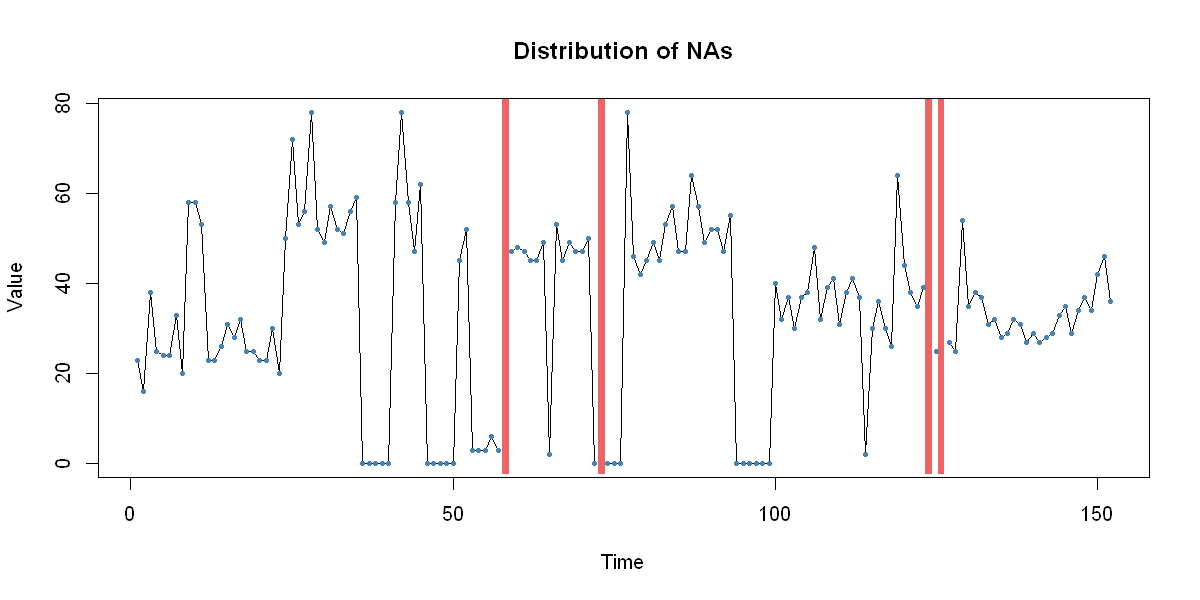

In [45]:

plotNA.distribution(as.data.frame(filter(sales_oos,product %in% c(1) & between(date,ymd('2014-01-01'),
                                                                                     ymd('2014-06-01')))
                                         %>% select(sales))[[1]])

### Imputing NA through 3-MA, neighbours seem to be a good approximation of NA

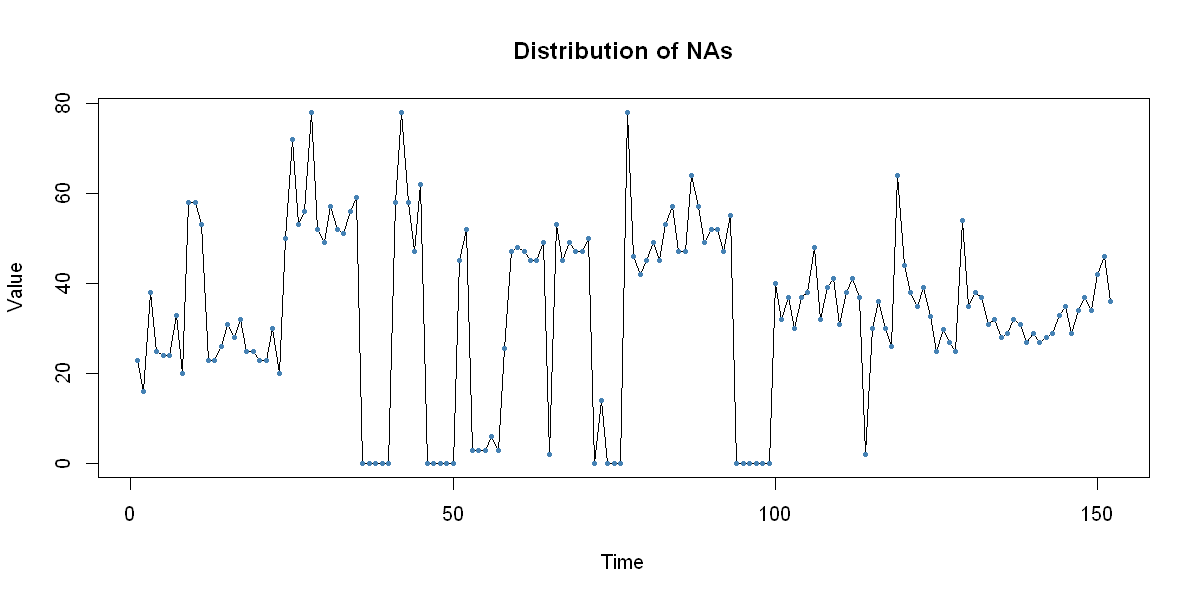

In [44]:
plotNA.distribution(na.ma(as.data.frame(filter(sales_oos,product %in% c(1) & between(date,ymd('2014-01-01'),
                                                                                     ymd('2014-06-01')))
                                         %>% select(sales))[[1]]))

### Imputing NA through linear-Interpolation

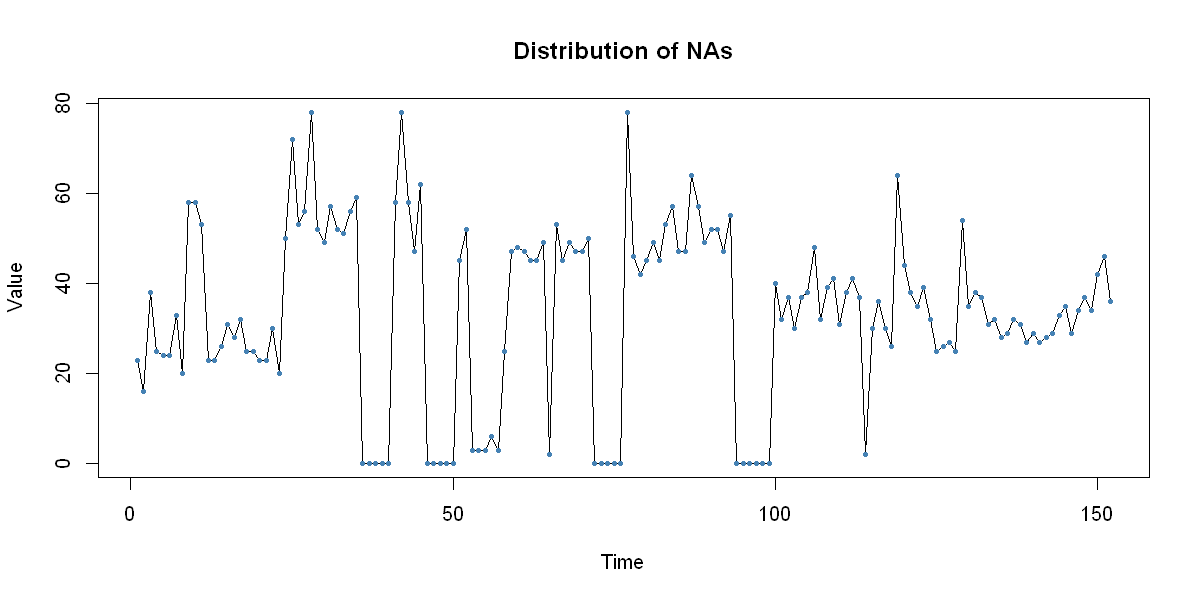

In [46]:
plotNA.distribution(na.interpolation(as.data.frame(filter(sales_oos,product %in% c(1) & between(date,ymd('2014-01-01'),
                                                                                     ymd('2014-06-01')))
                                         %>% select(sales))[[1]],option ="linear"))

### Imputing NA through ARIMA

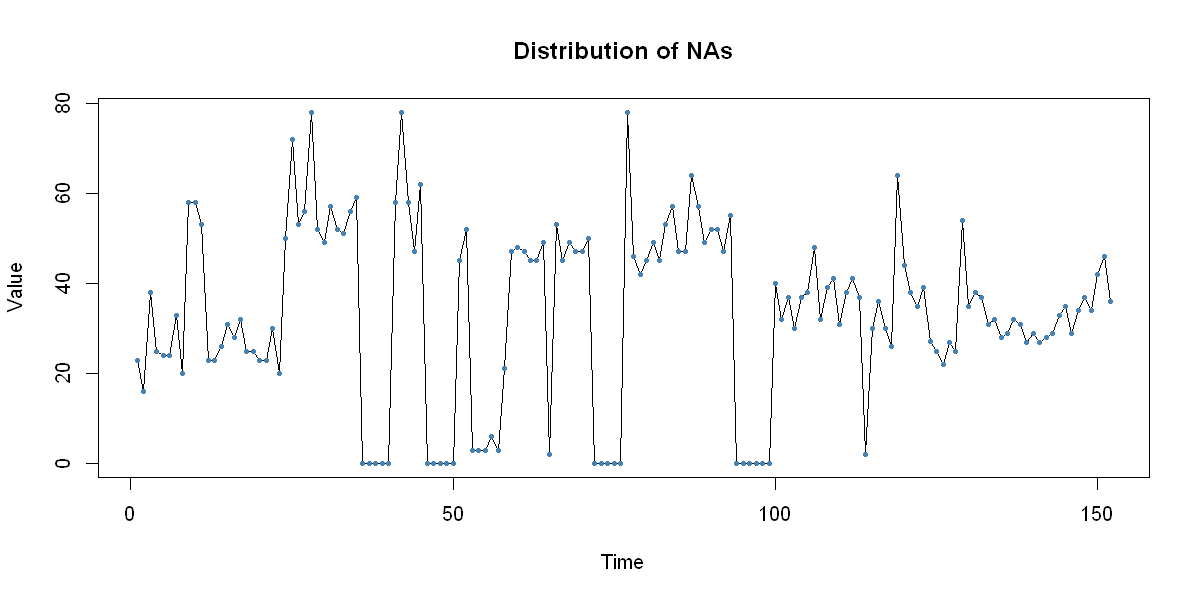

In [48]:
plotNA.distribution(na.kalman(as.data.frame(filter(sales_oos,product %in% c(1) & between(date,ymd('2014-01-01'),
                                                                                     ymd('2014-06-01')))
                                         %>% select(sales))[[1]],model ="auto.arima"))

### ~1% Missing values and 20-25% oos days, therefore treating them together

### Date/Time features

In [9]:
sales_oos = sales_oos %>% mutate(woy = week(date), month=month(date),quarter = quarter(date),year = year(date),day=day(date),
                                 
                 wom = ceiling(day(date)/7), dow=weekdays(date), doy = yday(date), sem = semester(date), qday = qday(date),
                                monthsize = days_in_month(date), lp_yr = leap_year(date)) %>% 
                mutate(dow_clubbed = dplyr::recode(dow,
                         'Wednesday' = "WTR",
                         'Thursday' = "WTR",
                         'Friday' = "FSS",
                         'Saturday' = "FSS",
                         'Sunday' = "FSS", 
                         'Monday' = "MT", 
                         'Tuesday' = "MT"
                        ))
nrow(sales_oos)

[1] 14330000

### Need to remove OOS as it cannot be in forecast

### Cannot use XGBoost to interpolate OOS days as this might lead to Information leakage in test

In [10]:
sales_oos = sales_oos %>%  mutate(smooth_sales = ifelse(oosflag == 1, NA, sales))

#checkinh %NAs
sum(1*is.na(sales_oos$smooth_sales))/nrow(sales_oos)*100

[1] 23.34747

In [65]:
head(sales_oos %>% select(product,date,smooth_sales) %>% spread(date,smooth_sales))

product 2012-03-01 2012-03-02 2012-03-03 2012-03-04 2012-03-05 2012-03-06
1 0       0          1          1           1          1          1        
2 1       0          0          0          NA         NA         NA        
3 2       0          0          0          NA         NA         NA        
4 3       1          1          3           2          2          3        
5 4       0          0          0           1          1          1        
6 5       0          0          0          25         22         50        
  2012-03-07 2012-03-08 2012-03-09 ... 2016-01-23 2016-01-24 2016-01-25
1  1          1          1         ...   4         4          4        
2 NA         NA          1         ...  NA        NA         NA        
3 NA         NA          1         ...  NA        NA         NA        
4  2          2          2         ... 294        56         17        
5  0          0         86         ...  63        61         70        
6 54         57         57         ...  67        72         67        
  2016-01-26 2016-01-27 2016-01-28 2016-01-29 2016-01-30 2016-01-31 2016-02-01
1  4          3          4          4          5          4          3        
2 NA         55         NA         NA         NA         NA         NA        
3 NA         NA         71         60         54          4          4        
4 27         18         16         14         20         21         15        
5 70         52         62         64         58         70         60        
6 67         67         61         40         44         51         51

In [11]:
tempx = sales_oos %>% select(product,date,smooth_sales) %>% spread(date,smooth_sales)
#temp = apply(tempx
 #            ,1,function(x) na.kalman(x[2:1434],model ="auto.arima"))
 
#na.interpolation # to speed up the process
temp = apply(tempx
             ,1,function(x) na.interpolation(x[2:1434],option ="linear"))
tempx[,2:1434] = t(temp)

In [12]:
sales_oos = sales_oos %>% inner_join(gather(tempx,key="date",value="smooth_sales_n" ,-product) %>% mutate(date = ymd(date))
                                      , by =c('product','date'))

In [76]:
head(sales_oos)

product date       sales oosflag woy month quarter year day wom dow      doy
1 0       2012-03-01 0     0       9   3     1       2012 1   1   Thursday 61 
2 1       2012-03-01 0     0       9   3     1       2012 1   1   Thursday 61 
3 2       2012-03-01 0     0       9   3     1       2012 1   1   Thursday 61 
4 3       2012-03-01 1     0       9   3     1       2012 1   1   Thursday 61 
5 4       2012-03-01 0     0       9   3     1       2012 1   1   Thursday 61 
6 5       2012-03-01 0     0       9   3     1       2012 1   1   Thursday 61 
  sem qday monthsize lp_yr dow_clubbed smooth_sales smooth_sales_n
1 1   61   31        TRUE  WTR         0            0             
2 1   61   31        TRUE  WTR         0            0             
3 1   61   31        TRUE  WTR         0            0             
4 1   61   31        TRUE  WTR         1            1             
5 1   61   31        TRUE  WTR         0            0             
6 1   61   31        TRUE  WTR         0            0

### A quick peak at the cleaned data

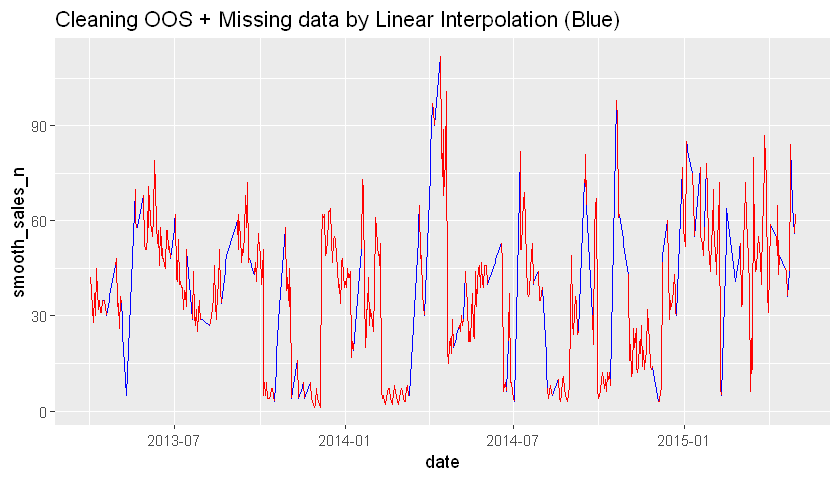

In [74]:
options(repr.plot.width=7, repr.plot.height=4)
ggplot(filter(sales_oos,product %in% c(400) & between(date,ymd('2013-04-01'),ymd('2015-05-01'))), aes(x = date)) +

    geom_line(aes(y=smooth_sales_n),color="blue")+
    geom_line(aes(y=smooth_sales),color="red") +
    #geom_point(data = select(filter(sales_oos,product==400 & oosflag==1 & between(date,ymd('2013-04-01'),ymd('2015-05-01')
    #                                         )),date,oossales=sales),aes(y=oossales))+
    ggtitle("Cleaning OOS + Missing data by Linear Interpolation (Blue) ")+
    #scale_colour_manual(values = c(alpha(c("#EE1330","#1C5282"),0.2),"black"))+
    theme(legend.position="none")
    

In [51]:
print(paste(nrow(sales_oos),ncol(sales_oos)))

[1] "14330000 19"


In [54]:
#Num of nas
sum(is.na(sales_oos$smooth_sales_n*1))

[1] 0

### Exploring Sales/ OOS  time series

### Exploring Trend

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

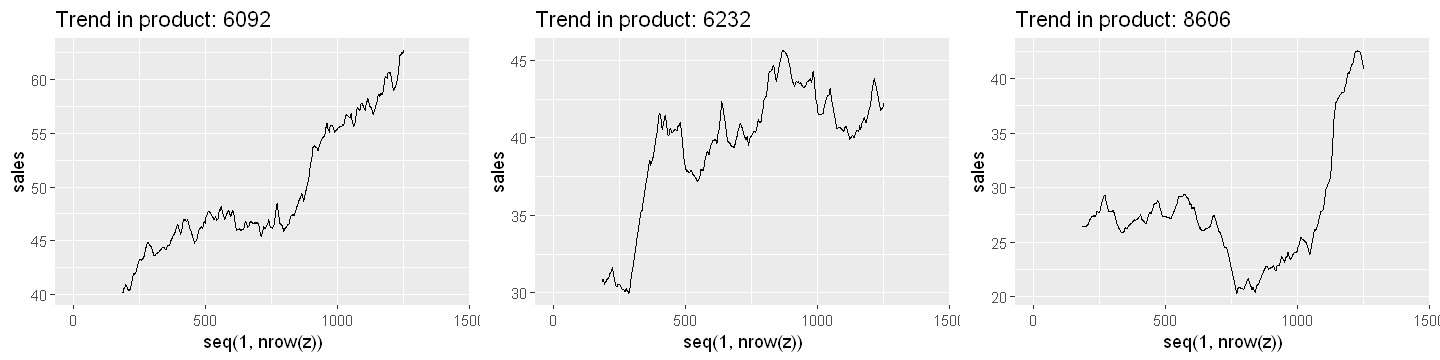

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

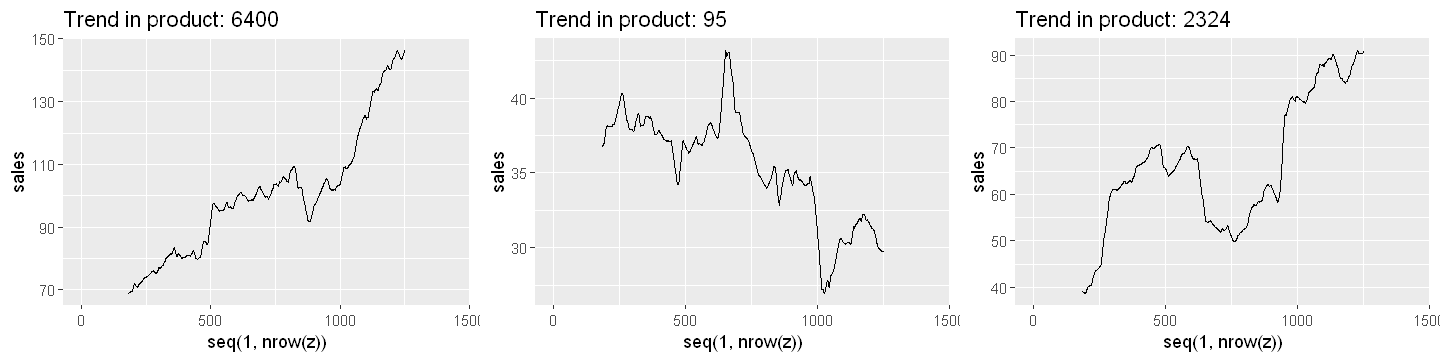

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

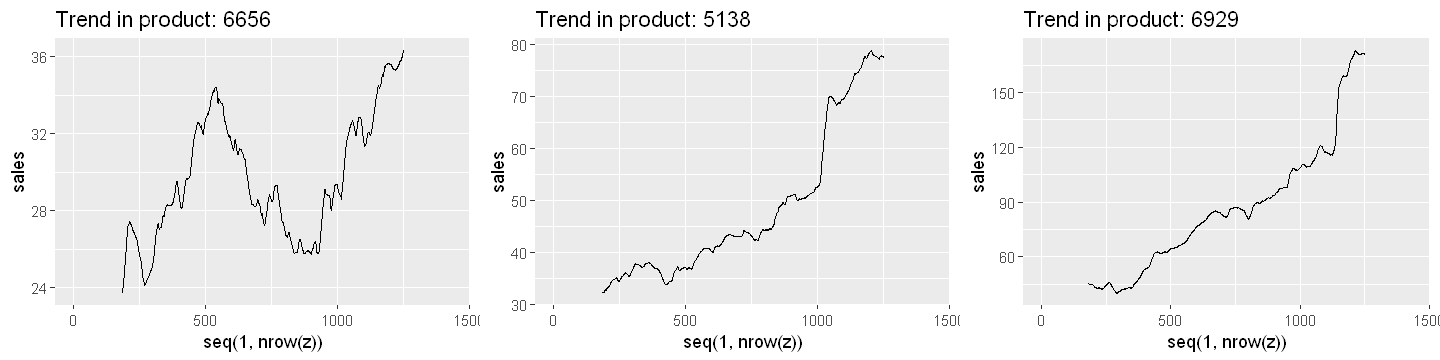

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

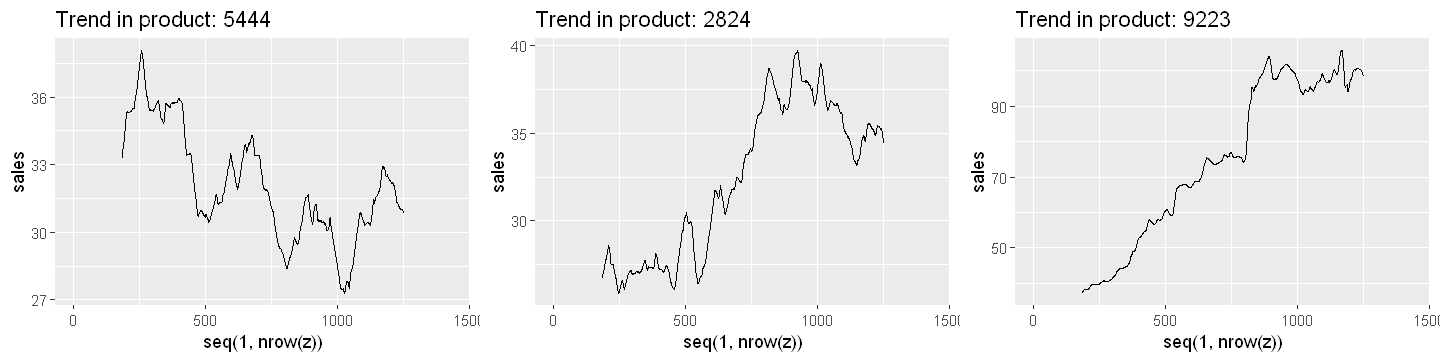

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

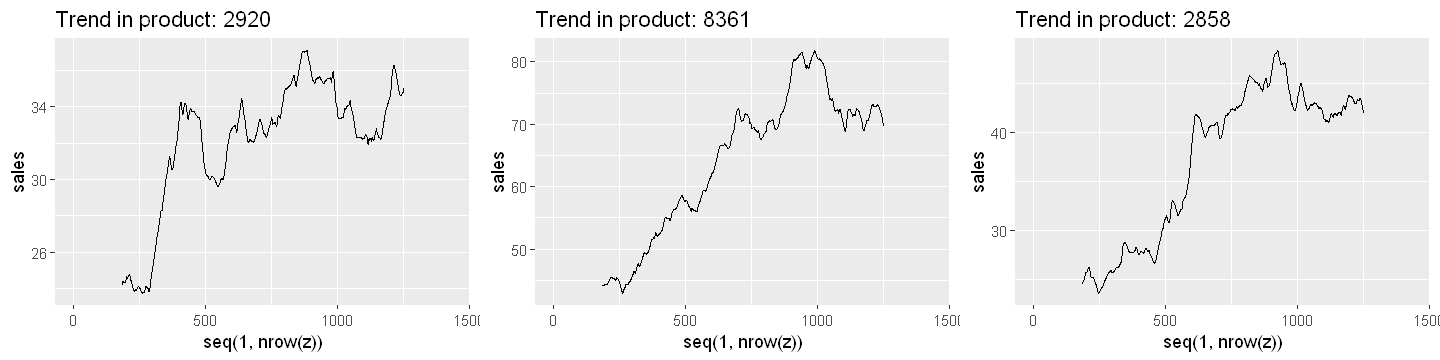

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

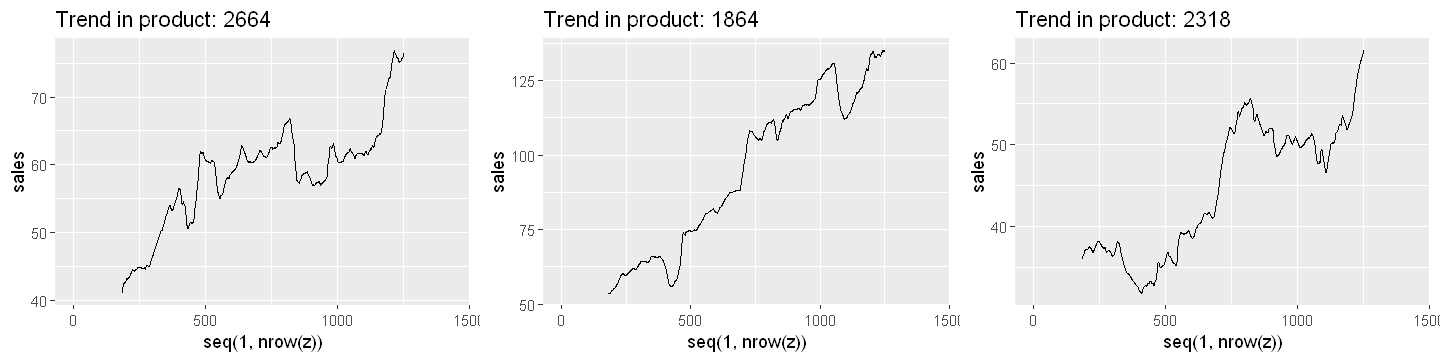

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

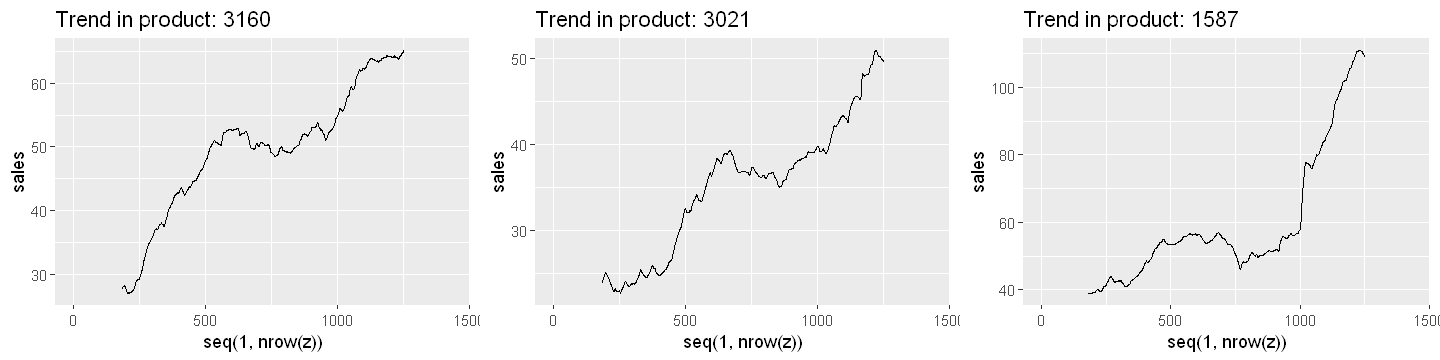

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

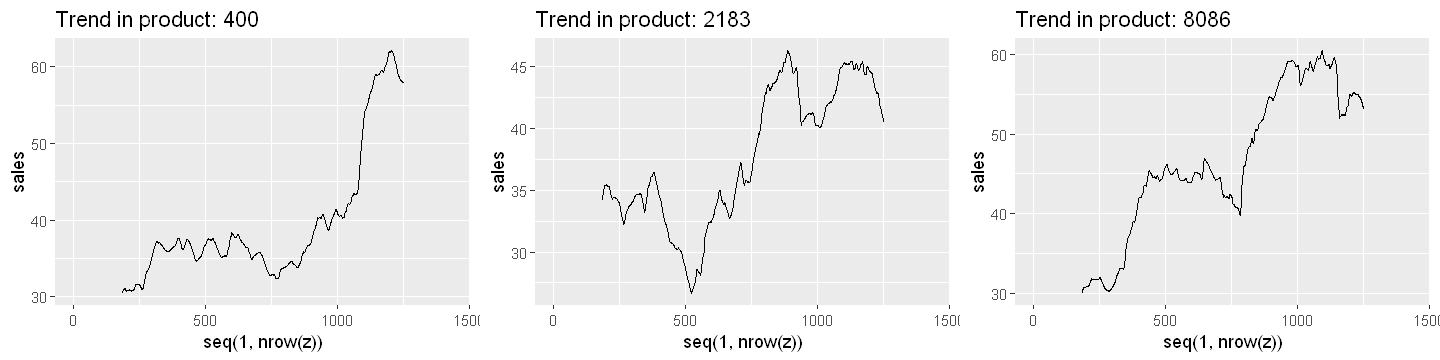

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

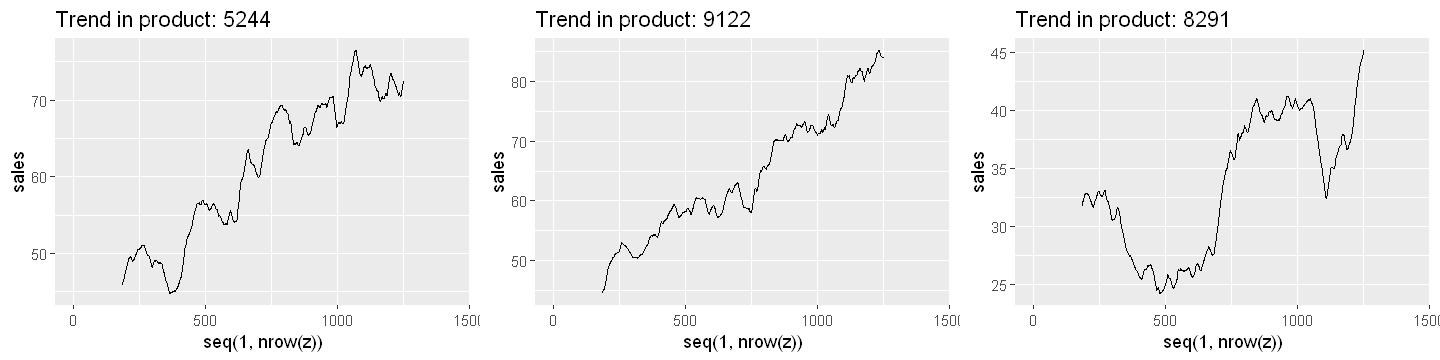

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

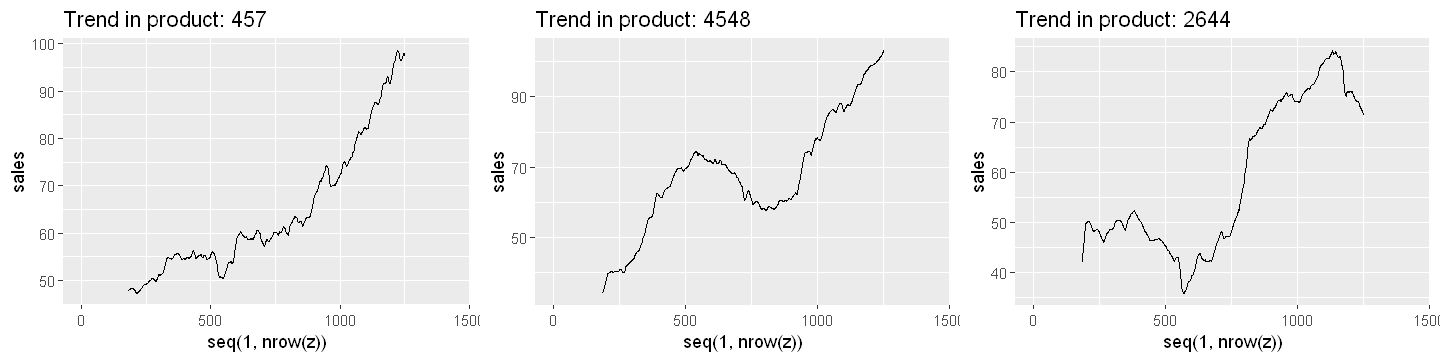

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

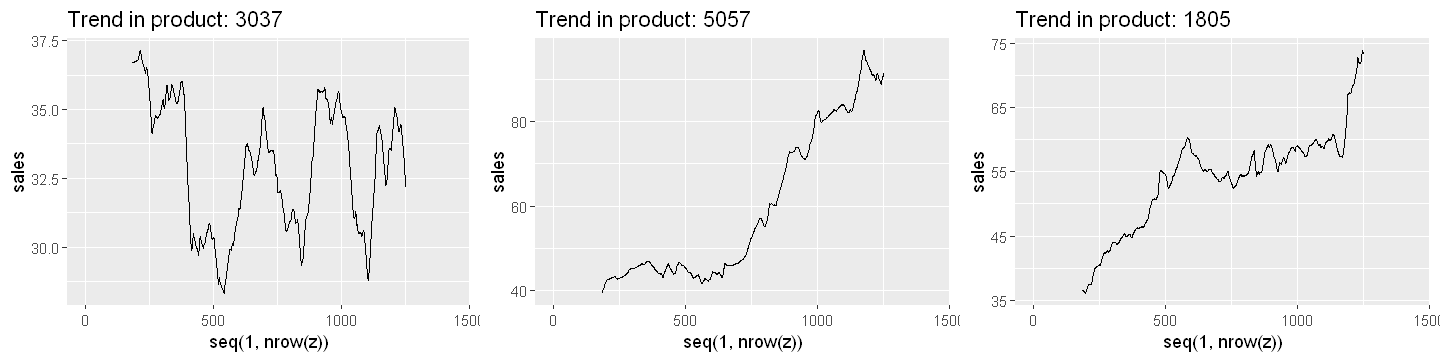

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

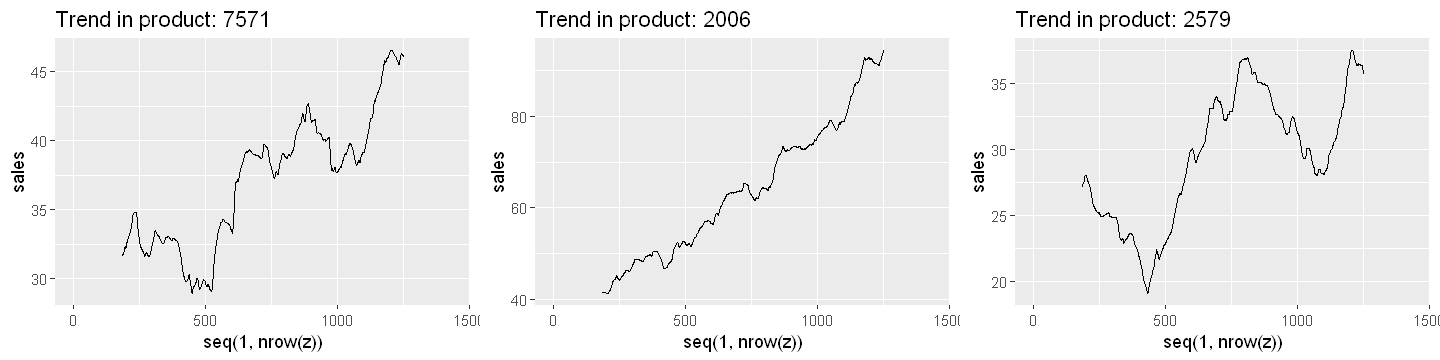

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

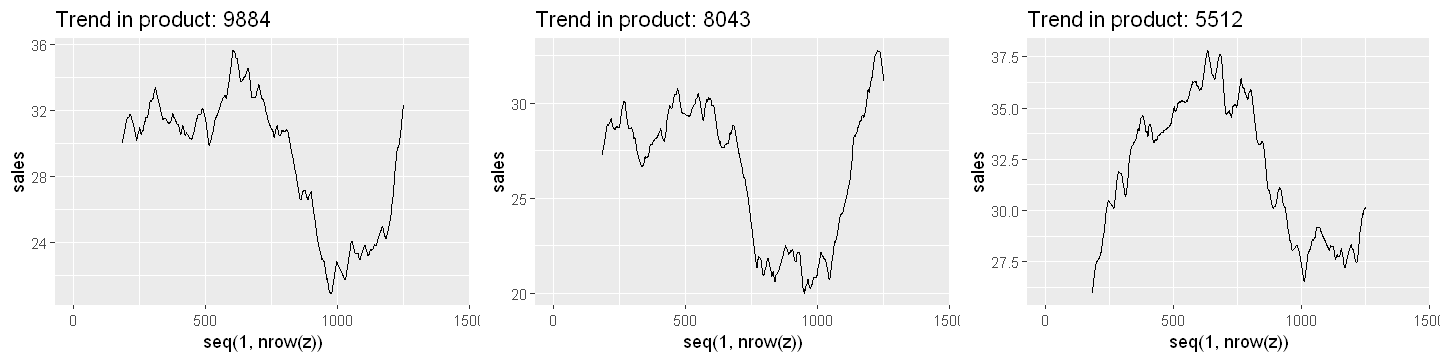

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

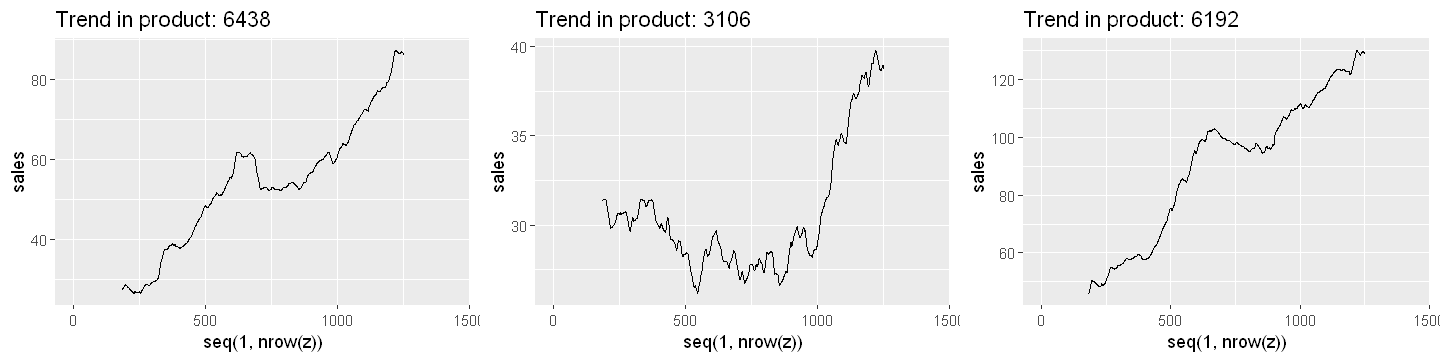

Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."Warning message:
"Removed 364 rows containing missing values (geom_path)."

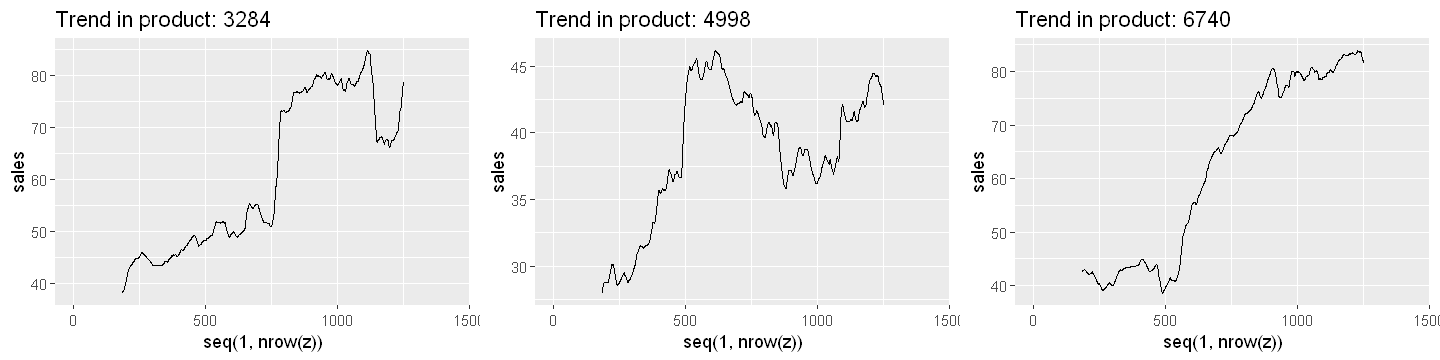

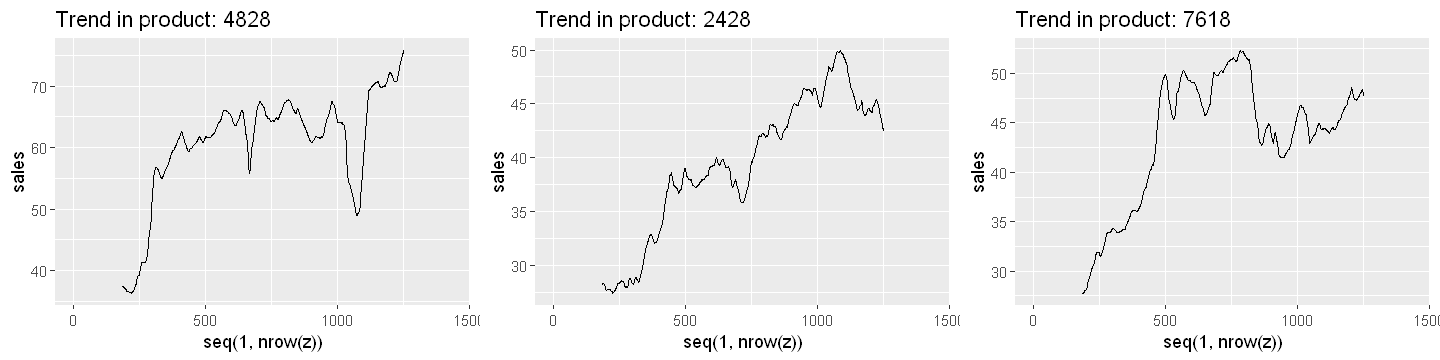

In [124]:
options(repr.plot.width=12, repr.plot.height=3)


plot_trend<-function(x){ 
y<-decompose(ts(filter(sales_oos,product==x)[['smooth_sales_n']],frequency = 365.25))
z<-as.data.frame(cbind(a = y$x, sales= y$trend))
ggplot(z)+
    geom_line(aes(x=seq(1,nrow(z)),y=sales))+
    ggtitle(paste('Trend in product:',x))

}

for(i in seq(0:15))
gridExtra::grid.arrange(plot_trend(smpl[3*i]), plot_trend(smpl[3*i+1]),plot_trend(smpl[3*i+2]), ncol=3)


#Missing values are arising from decomposition

Warning message:
"Removed 1383 rows containing missing values (geom_path)."Warning message:
"Removed 1383 rows containing missing values (geom_path)."

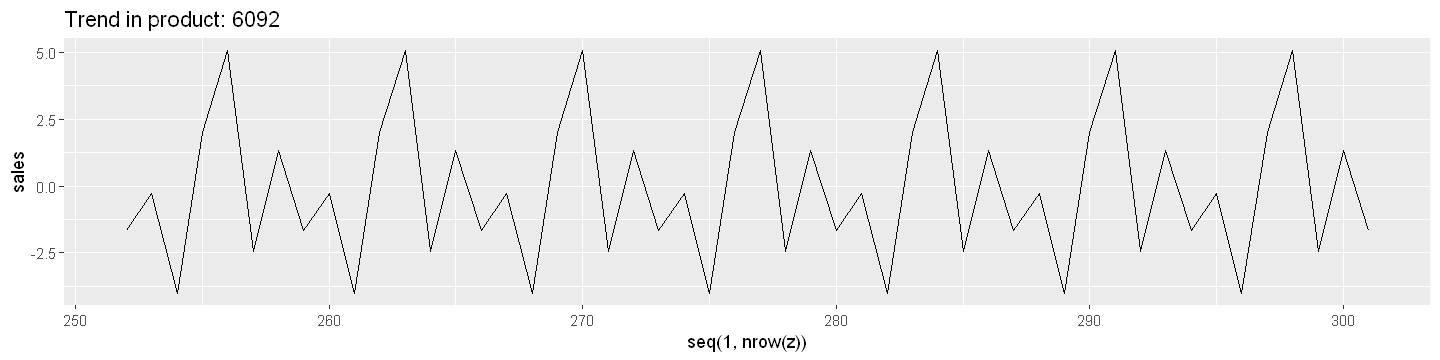

Warning message:
"Removed 1383 rows containing missing values (geom_path)."

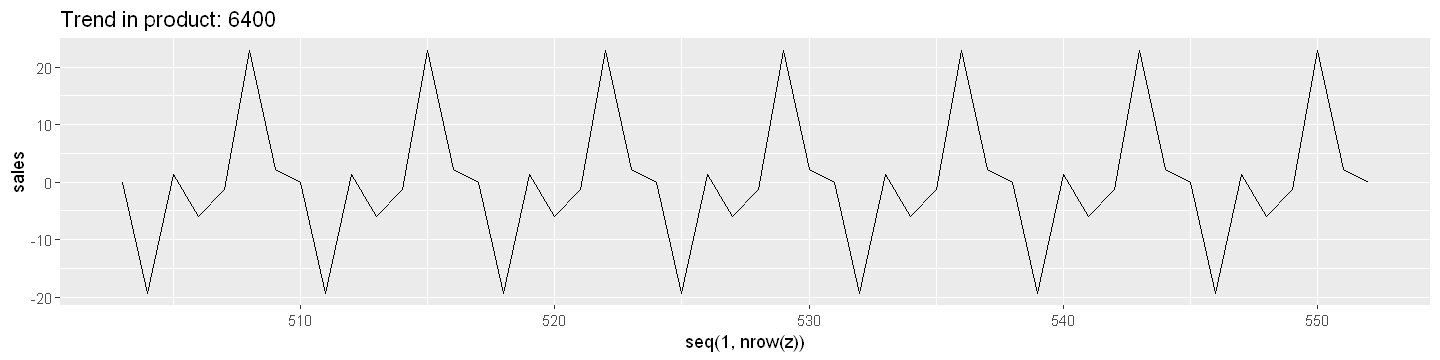

Warning message:
"Removed 1383 rows containing missing values (geom_path)."

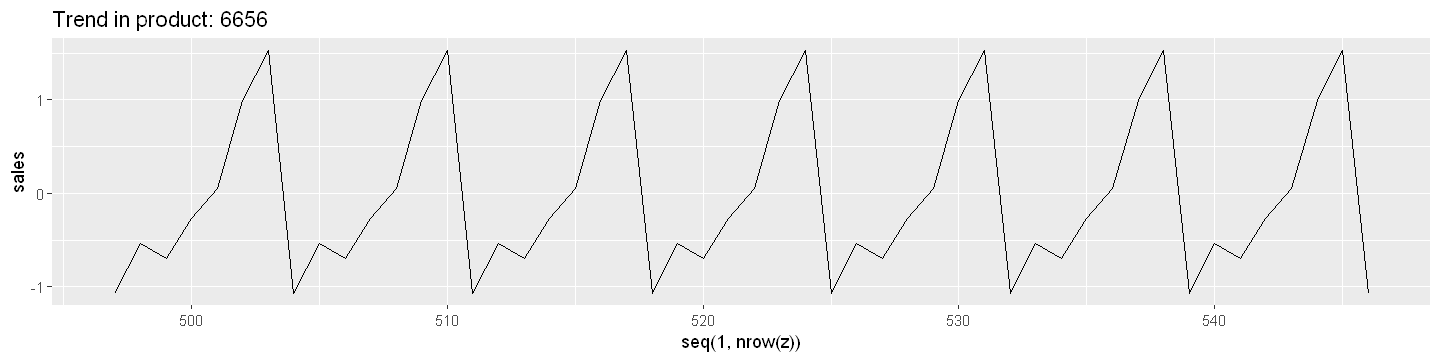

Warning message:
"Removed 1383 rows containing missing values (geom_path)."

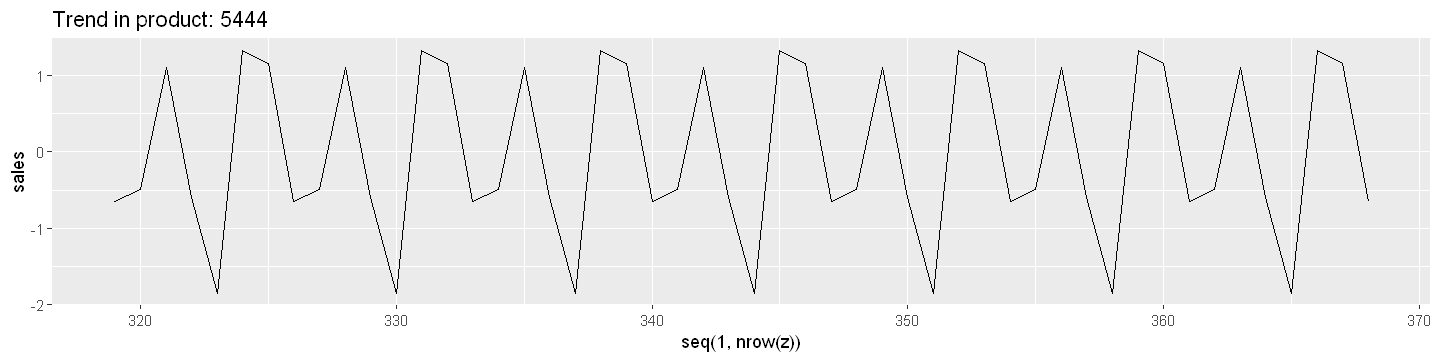

Warning message:
"Removed 1383 rows containing missing values (geom_path)."

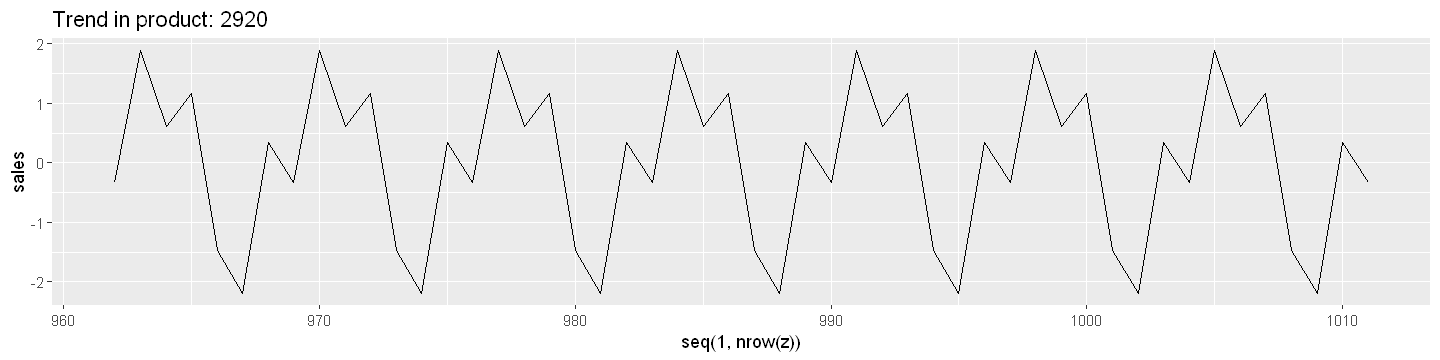

Warning message:
"Removed 1383 rows containing missing values (geom_path)."

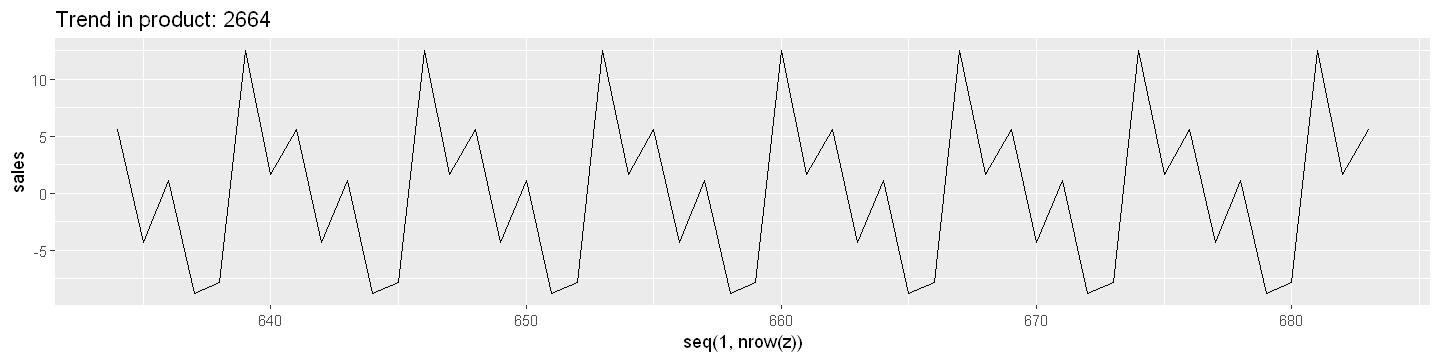

Warning message:
"Removed 1383 rows containing missing values (geom_path)."

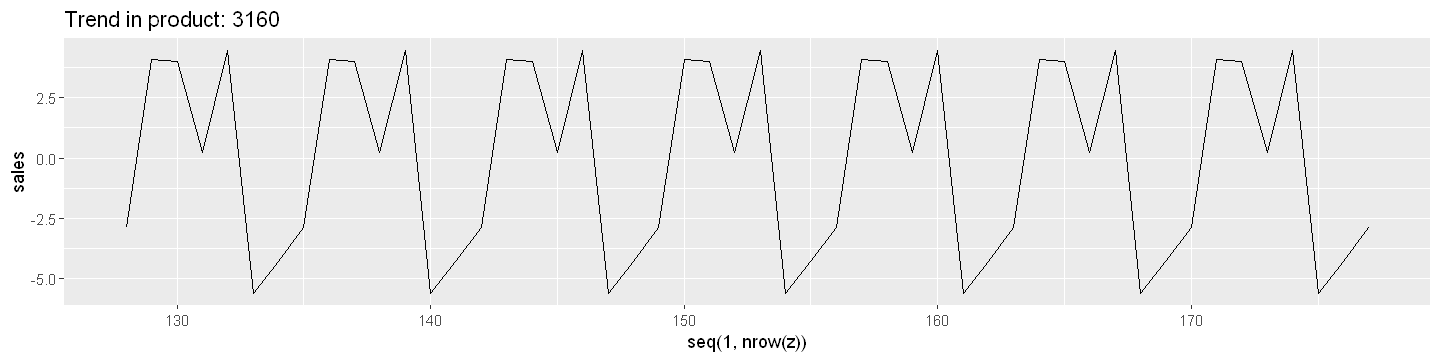

Warning message:
"Removed 1383 rows containing missing values (geom_path)."

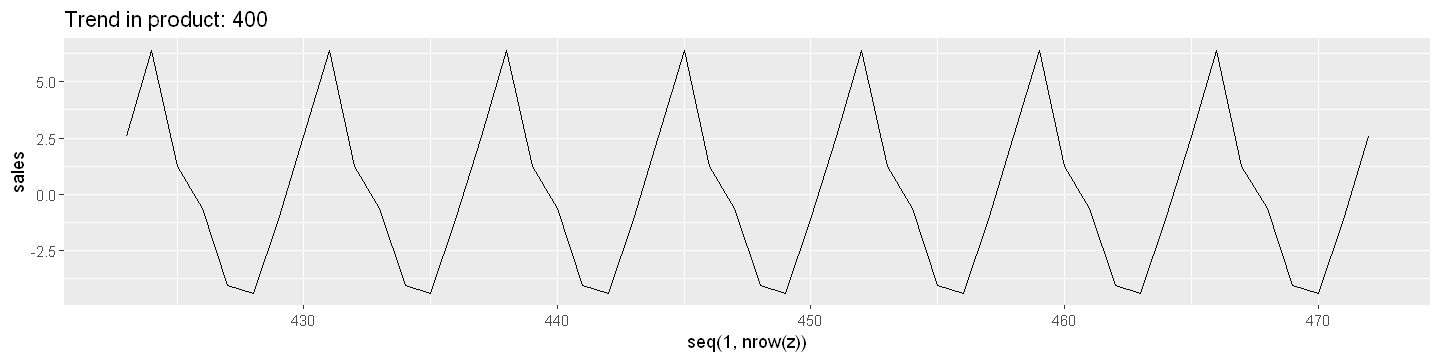

Warning message:
"Removed 1383 rows containing missing values (geom_path)."

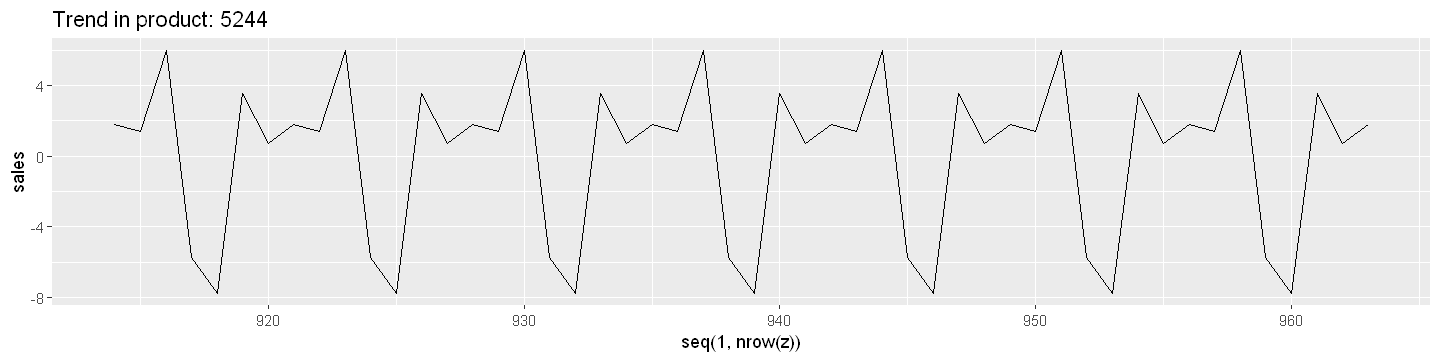

Warning message:
"Removed 1383 rows containing missing values (geom_path)."

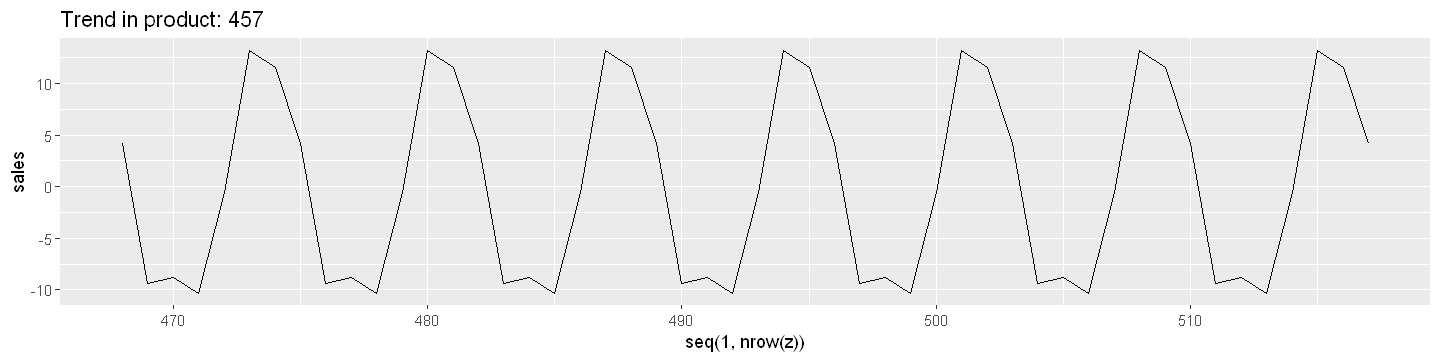

Warning message:
"Removed 1383 rows containing missing values (geom_path)."

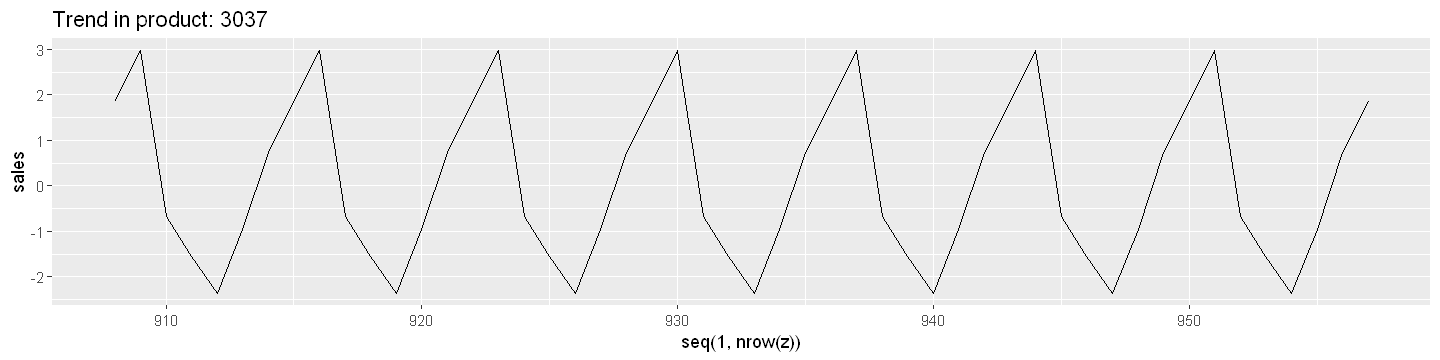

Warning message:
"Removed 1383 rows containing missing values (geom_path)."

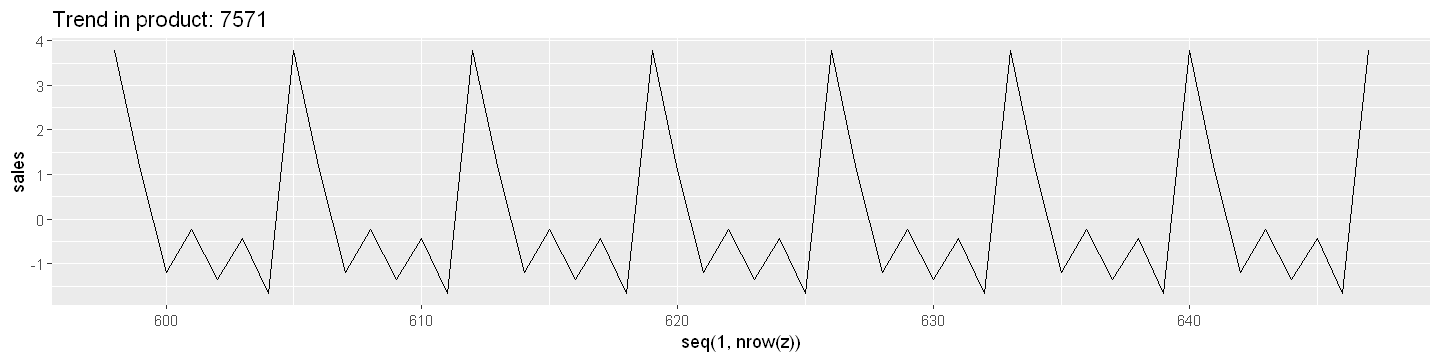

Warning message:
"Removed 1383 rows containing missing values (geom_path)."

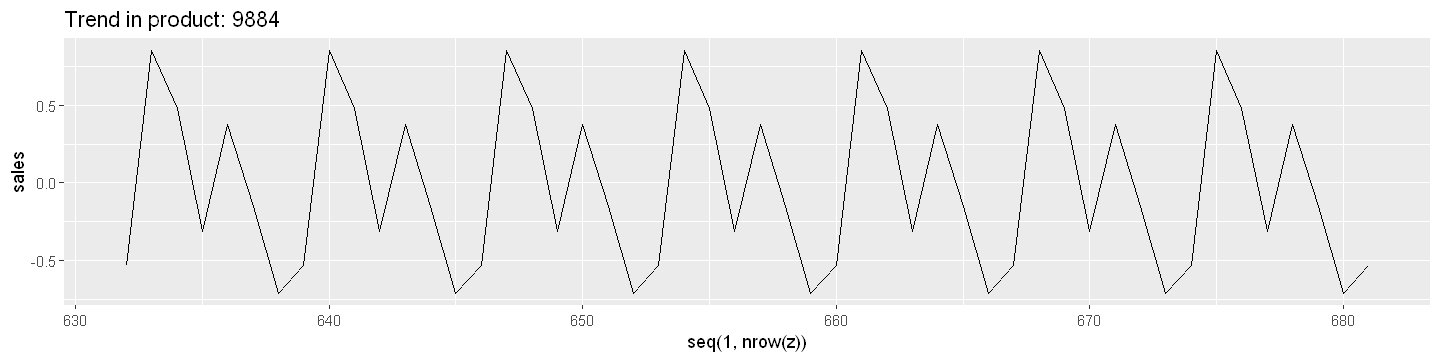

Warning message:
"Removed 1383 rows containing missing values (geom_path)."

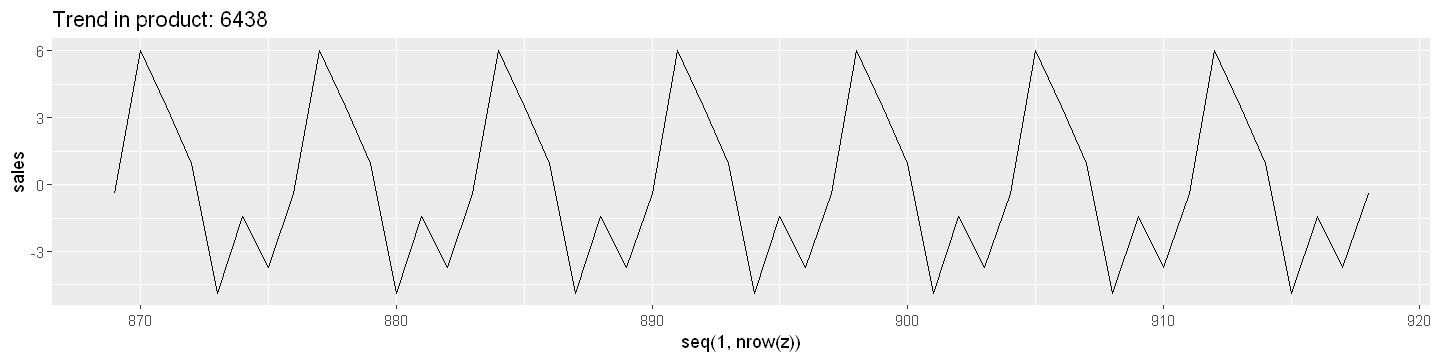

Warning message:
"Removed 1383 rows containing missing values (geom_path)."

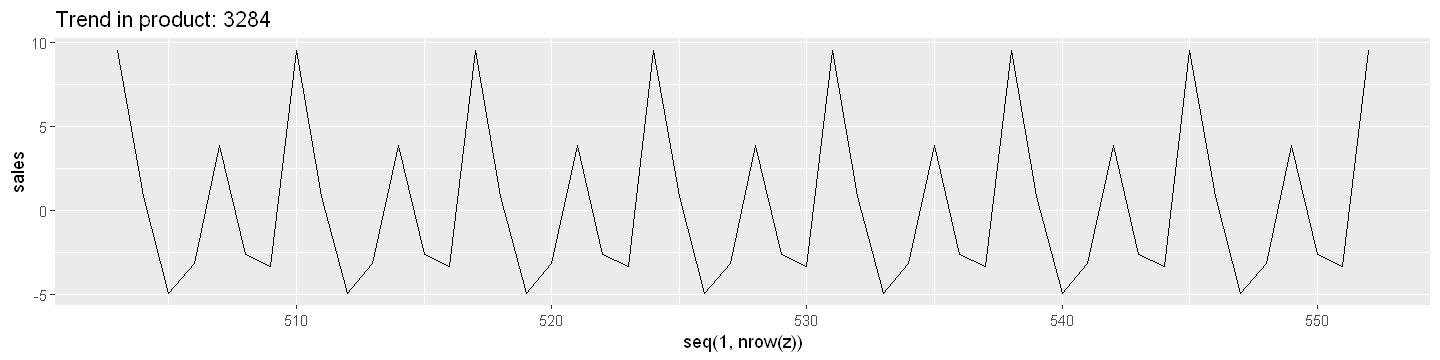

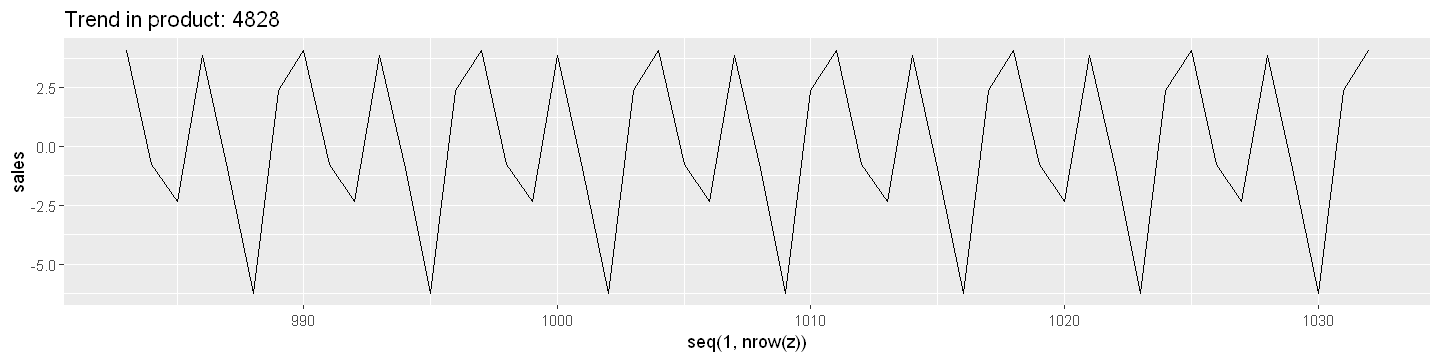

In [132]:
options(repr.plot.width=12, repr.plot.height=3)


plot_trend<-function(x){ 
rand <- sample(seq(2:1000),1)
y<-decompose(ts(filter(sales_oos,product==x)[['smooth_sales_n']],frequency = 7))
z<-as.data.frame(cbind(a = y$x, sales= y$seasonal))
ggplot(z)+
    geom_line(aes(x=seq(1,nrow(z)),y=sales))+
    ggtitle(paste('Trend in product:',x))+
    xlim(rand,rand+49)

}

for(i in seq(0:15))
gridExtra::grid.arrange(plot_trend(smpl[3*i]))


#Missing values are arising from decomposition

In [61]:
plot_sales <- function(x){
ggplot(filter(sales_oos,product==x) %>% mutate(dow=weekdays(date)) %>% mutate(dow = dplyr::recode(dow,
                         'Wednesday' = "WTR",
                         'Thursday' = "WTR",
                         'Friday' = "FSS",
                         'Saturday' = "FSS",
                         'Sunday' = "FSS", 
                         'Monday' = "MT", 
                         'Tuesday' = "MT"
                        )), aes(x=smooth_sales_n,y=date))+
    geom_point(aes(color= dow))+
    ggtitle(paste("DOW seasonality for product:",x))+
    theme(legend.position="bottom",plot.title = element_text(face = "bold", size = 10))+
    scale_colour_manual(values = c(alpha(c("#EE1330","#1C5282"),0.2),"black"))
}

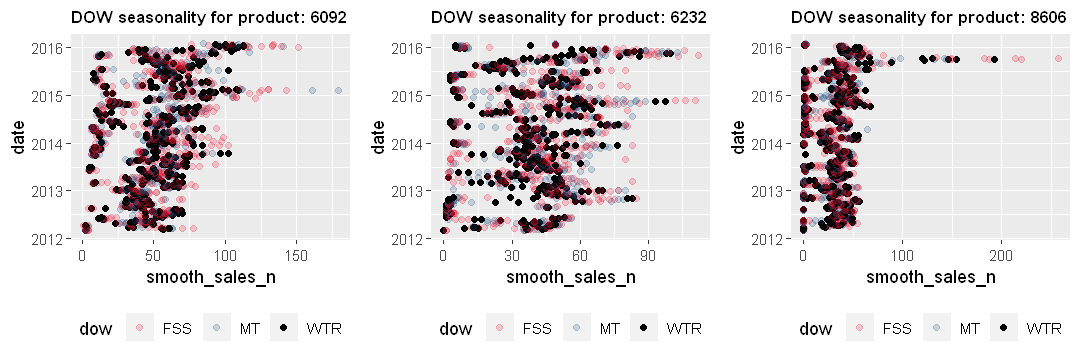

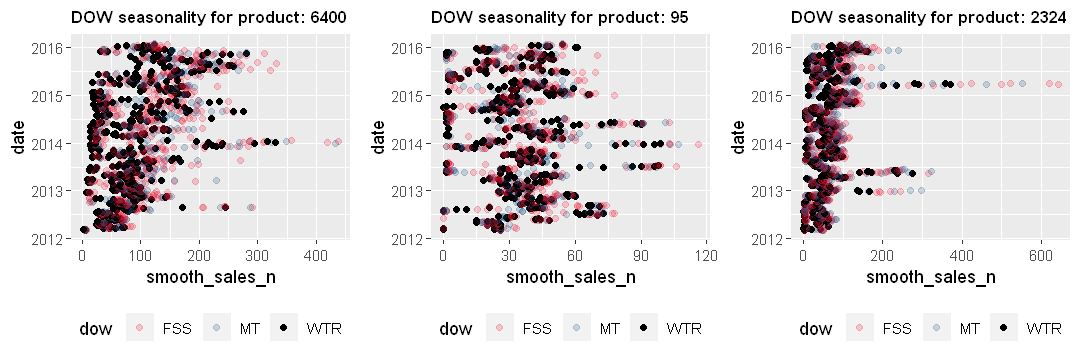

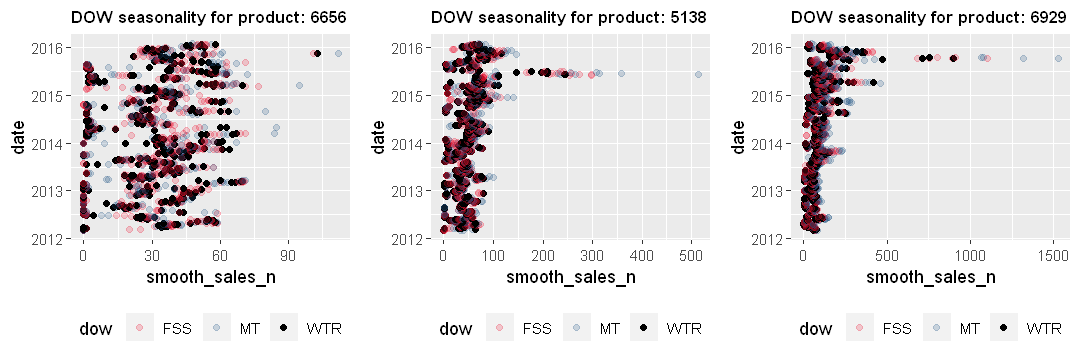

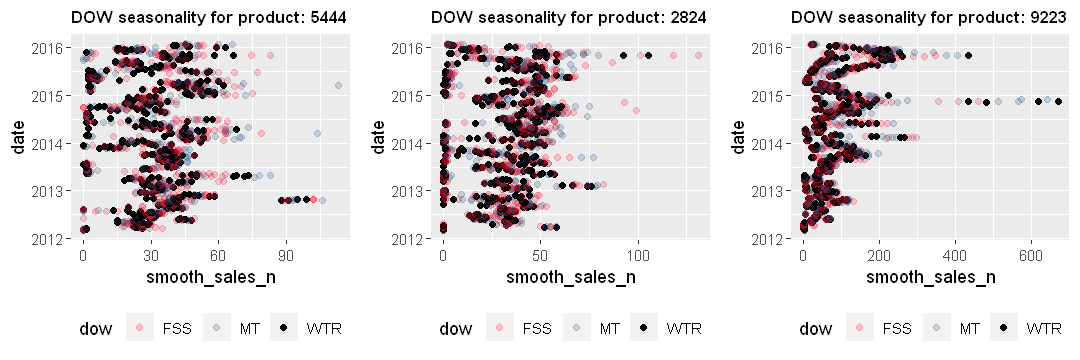

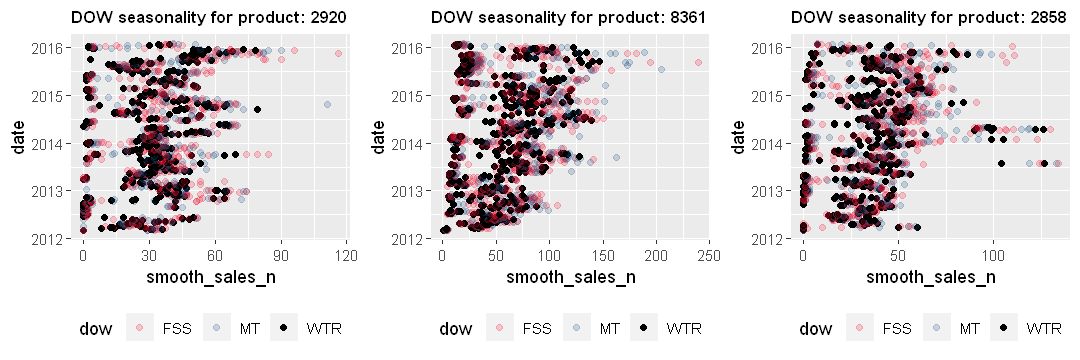

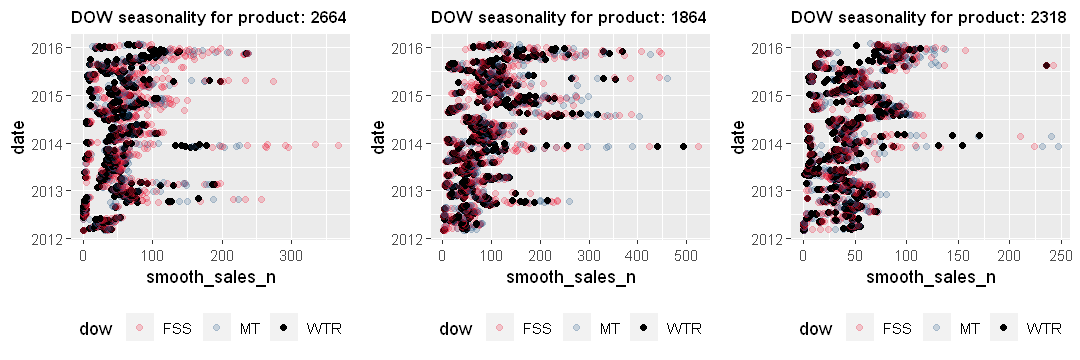

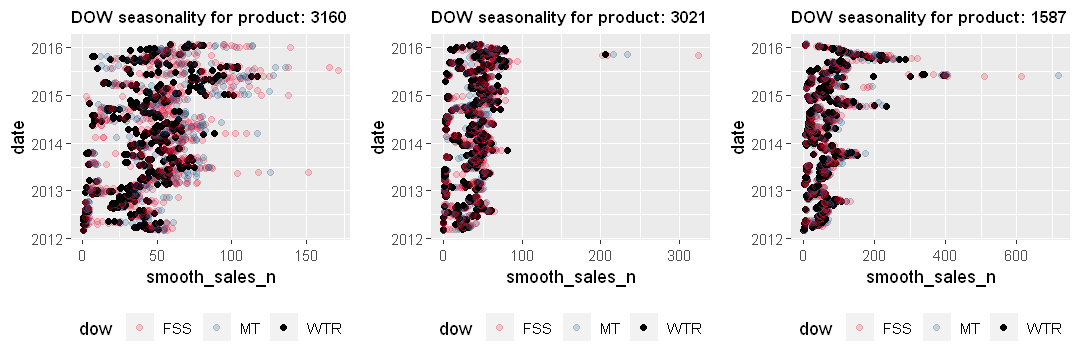

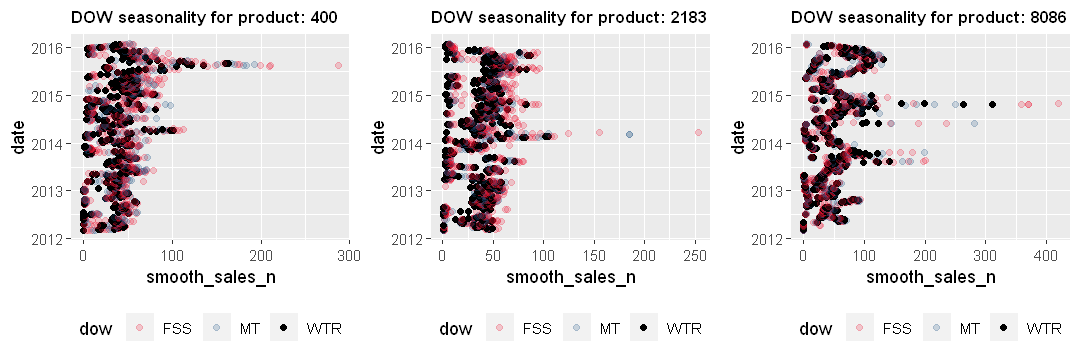

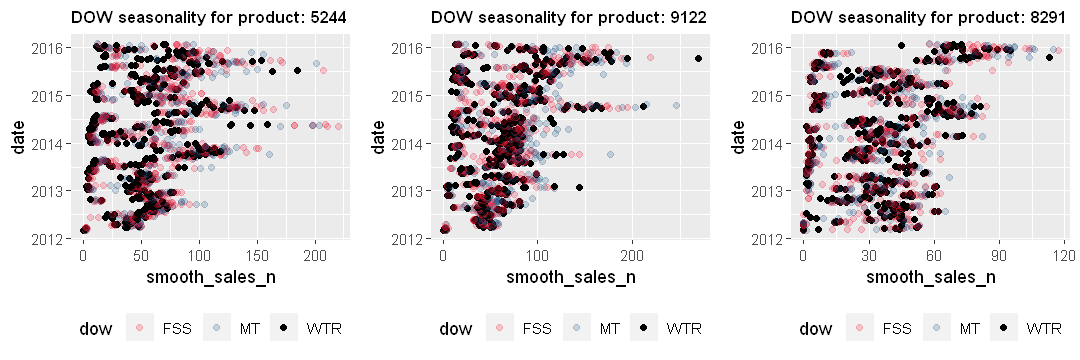

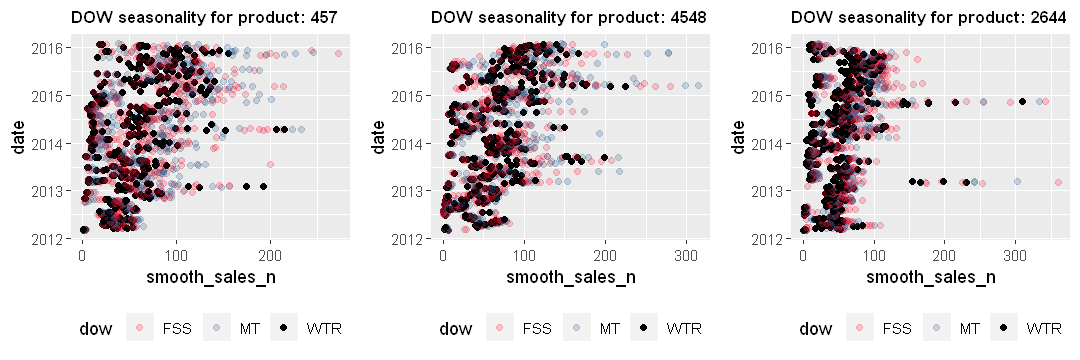

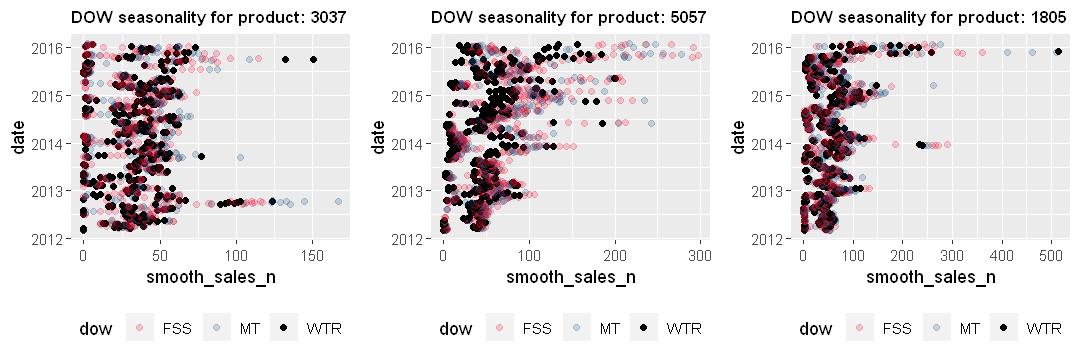

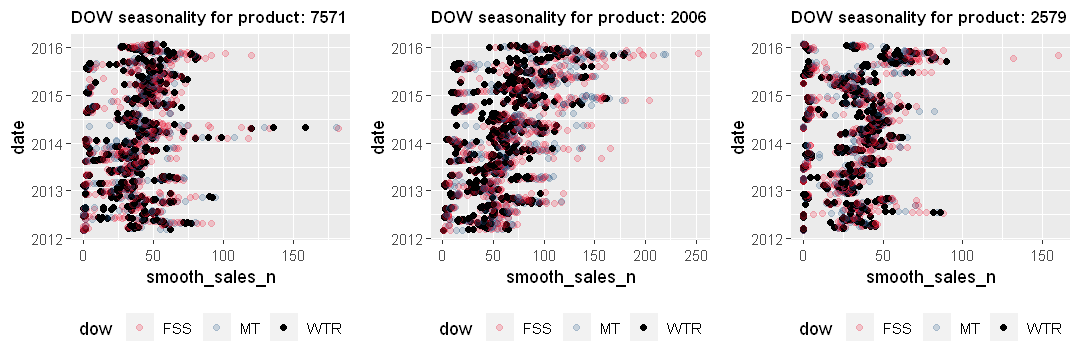

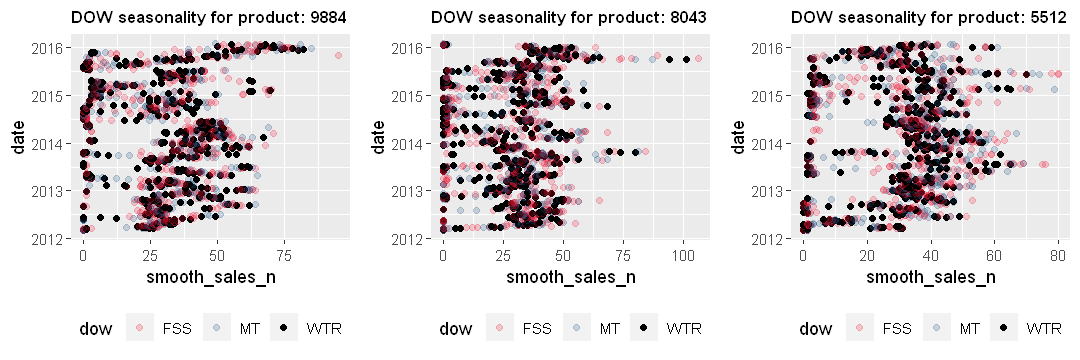

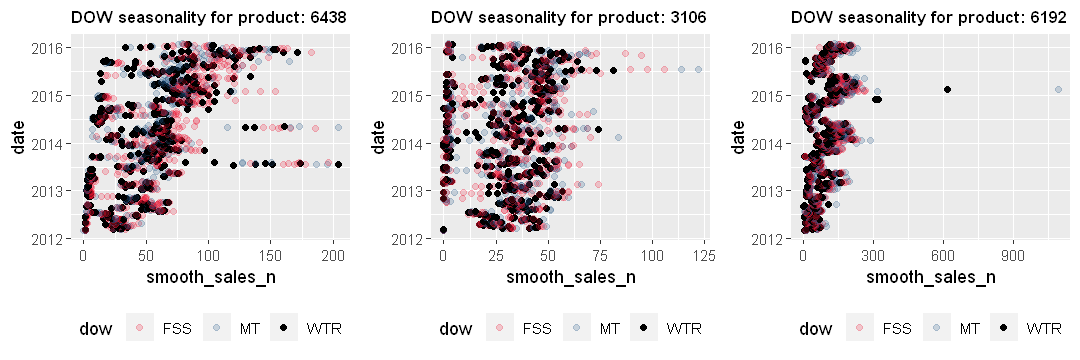

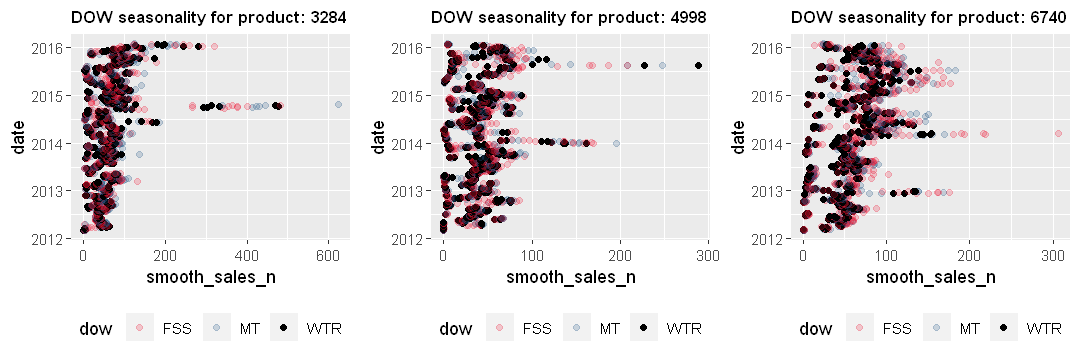

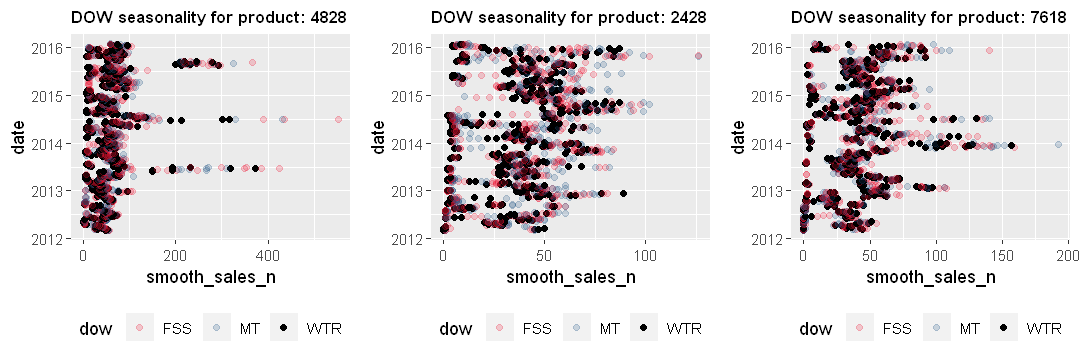

In [62]:
options(repr.plot.width=9, repr.plot.height=3)
for(i in seq(0:15))
gridExtra::grid.arrange(plot_sales(smpl[3*i]), plot_sales(smpl[3*i+1]),plot_sales(smpl[3*i+2]), ncol=3)

```
No clear separation between sales on Monday, Tuesday or Friday,Saturday, Sunday. But sales are clearly lower on Wednesday and Thursday
```

### Monthly seasonality

In [98]:
options(repr.plot.width=9, repr.plot.height=7)
##Normalized sales monthly

plot_sales_line <- function(x){
ggplot(filter(sales_oos,product==x &  date < ymd('2016-01-01')) %>% mutate(mth=month(date),year=year(date),day=day(date)) 
       %>% group_by(mth,year) %>% 
    summarise(sls = sum(smooth_sales_n),numdays = max(day)) %>% mutate(Normalized_sales = 30.0*(sls/as.numeric(numdays)))
       %>% 
    arrange(year,mth) %>% select(mth,Normalized_sales,year))+
    geom_line(aes(x=mth,y=Normalized_sales,color = as.factor(year))) +
    scale_x_continuous(breaks = seq(1,12, by = 1)) +
    scale_colour_manual(values = c(alpha(c("#EE1330","#1C5282"),0.8),"black","grey"))+
    theme(legend.position="none")+
    ggtitle(paste("Monthly sales for product:",x))
    }

plot_sales_pt <- function(x){
p_meds <- filter(sales_oos,product==x) %>% mutate(mth=month(date),year=year(date),day=day(date)) %>%
    group_by(mth) %>% summarise(mediansls = median(smooth_sales_n))


ggplot(filter(sales_oos,product==x) %>% mutate(mth=month(date),year=year(date),day=day(date))) +
    geom_point(aes(x=mth,y=smooth_sales_n))+
    geom_point(data=p_meds,aes(x=mth,y=mediansls,color = "red", size =8))+
    scale_x_continuous(breaks = seq(1,12, by = 1))+
    theme(legend.position="none",plot.title = element_text(face = "bold", size = 10))+
    ggtitle(paste("Monthly seasonality for product:",x))
       }

plot_sales_smoothened <- function(x){

filter(sales_oos,product %in% c(x) & date < ymd('2015-01-01'))%>%mutate(year=year(date)) %>%
ggplot(aes(x = date,group=factor(year),color=factor(year))) +
    geom_smooth(aes(y=smooth_sales_n))+
    scale_colour_manual(values = c(alpha(c("#EE1330","#1C5282"),0.8),"black","grey","pink"))+
    theme(legend.position="top",plot.title = element_text(face = "bold", size = 10))+
    ggtitle(paste("Daily sales for product:",x))
    }

In [83]:
#for(i in seq(1:3)){
#    
#    pushViewport(viewport(layout = grid.layout(2, 2)))
#    # A helper function to define a region on the layout
#    define_region <- function(row, col){
#    viewport(layout.pos.row = row, layout.pos.col = col)
#    } 
## Arrange the plots
#    print(plot_sales_line(smpl[i]), vp=define_region(1, 1:2))
#    print(plot_sales_pt(smpl[i]), vp = define_region(2, 1))
#    print(plot_sales_smoothened(smpl[i]), vp = define_region(2, 2))
#    }

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


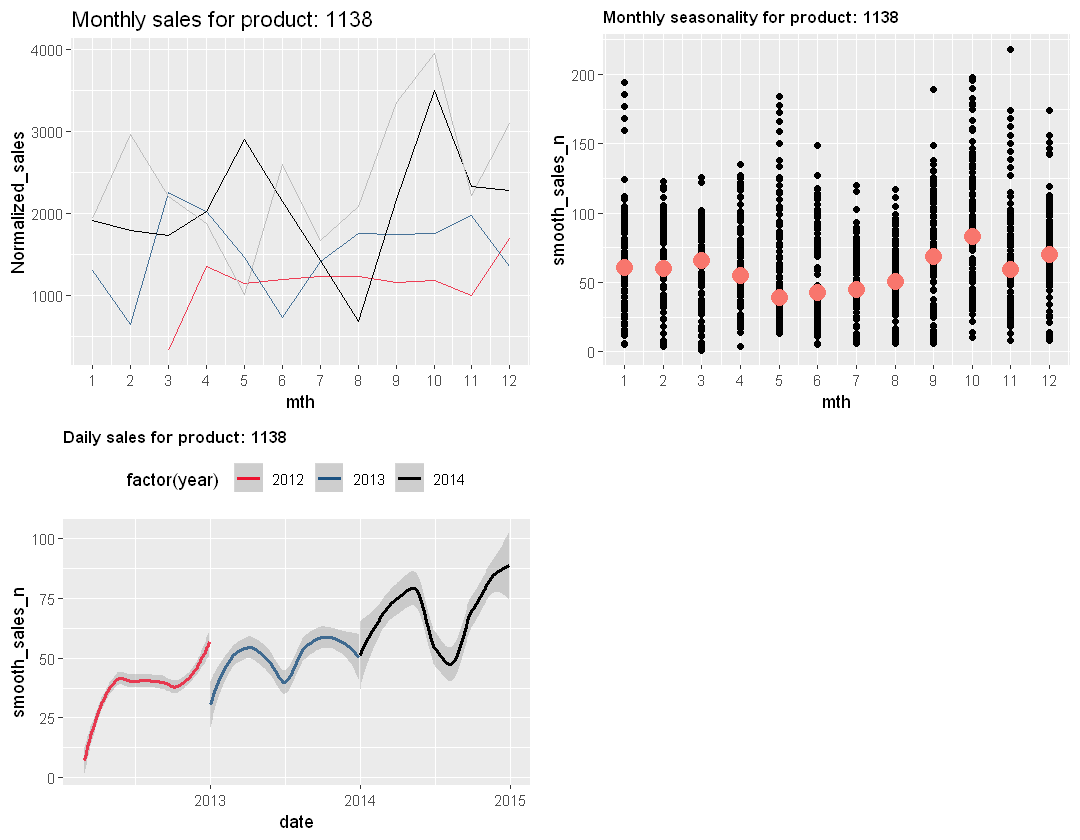

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


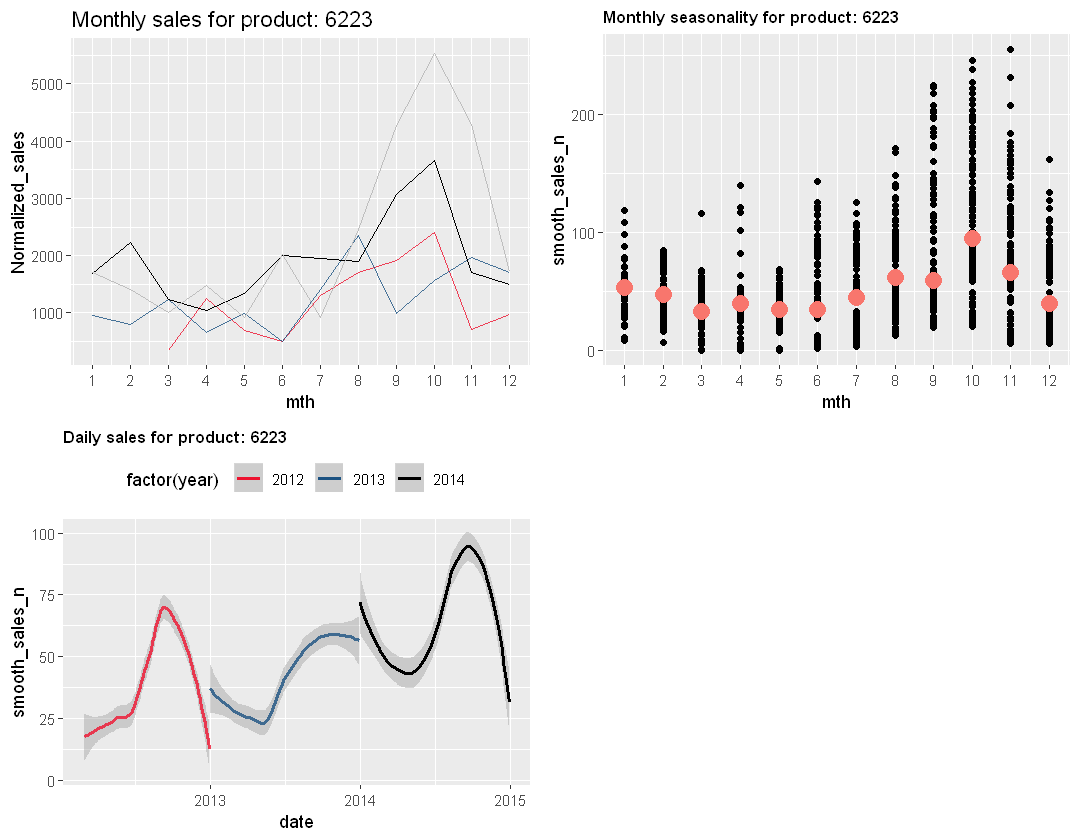

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


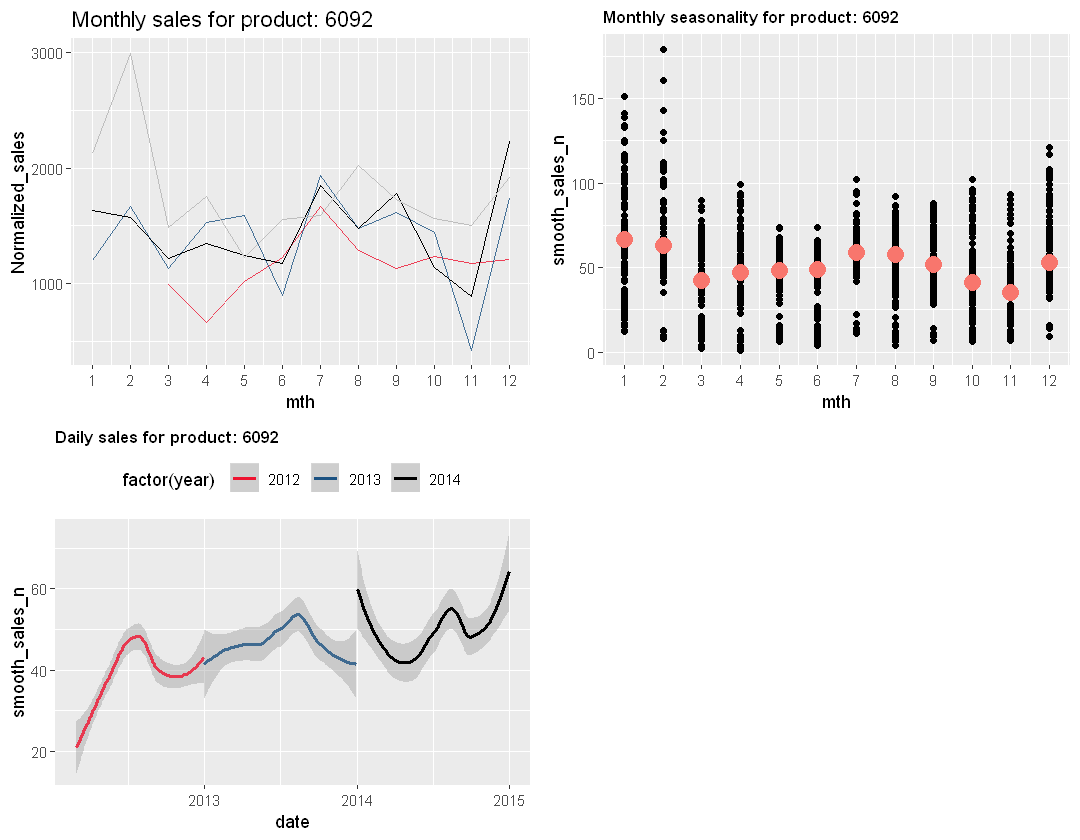

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


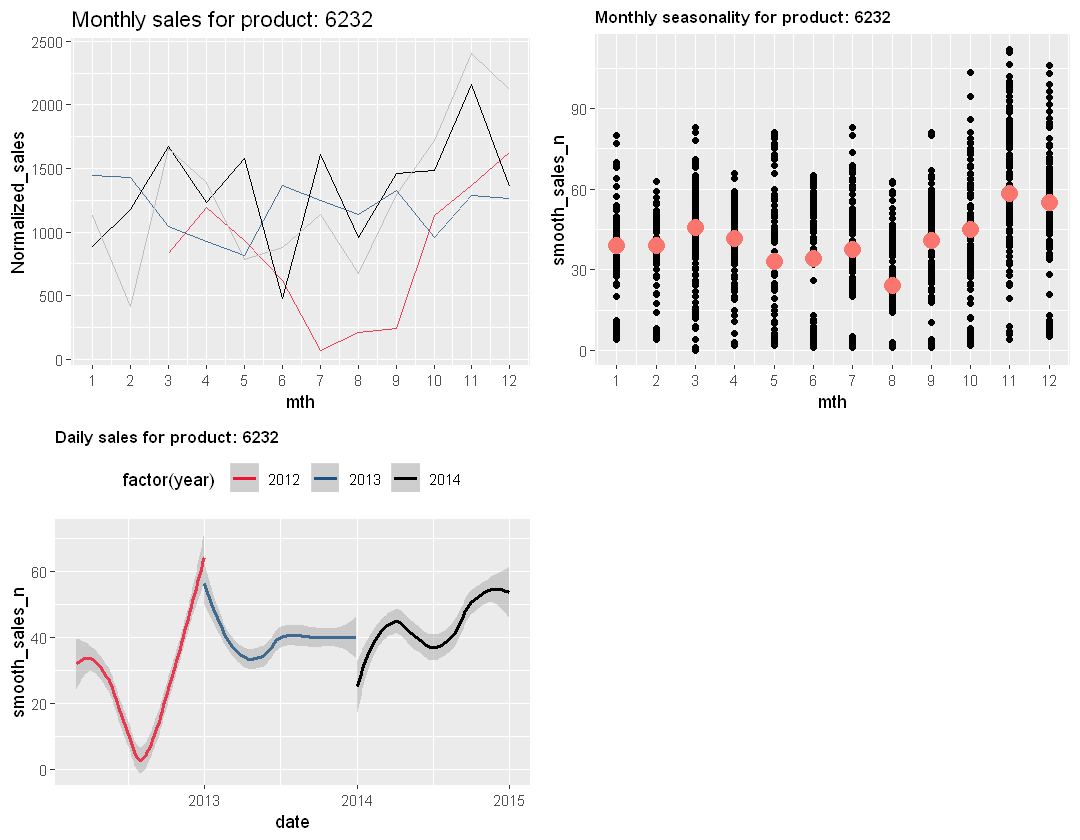

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


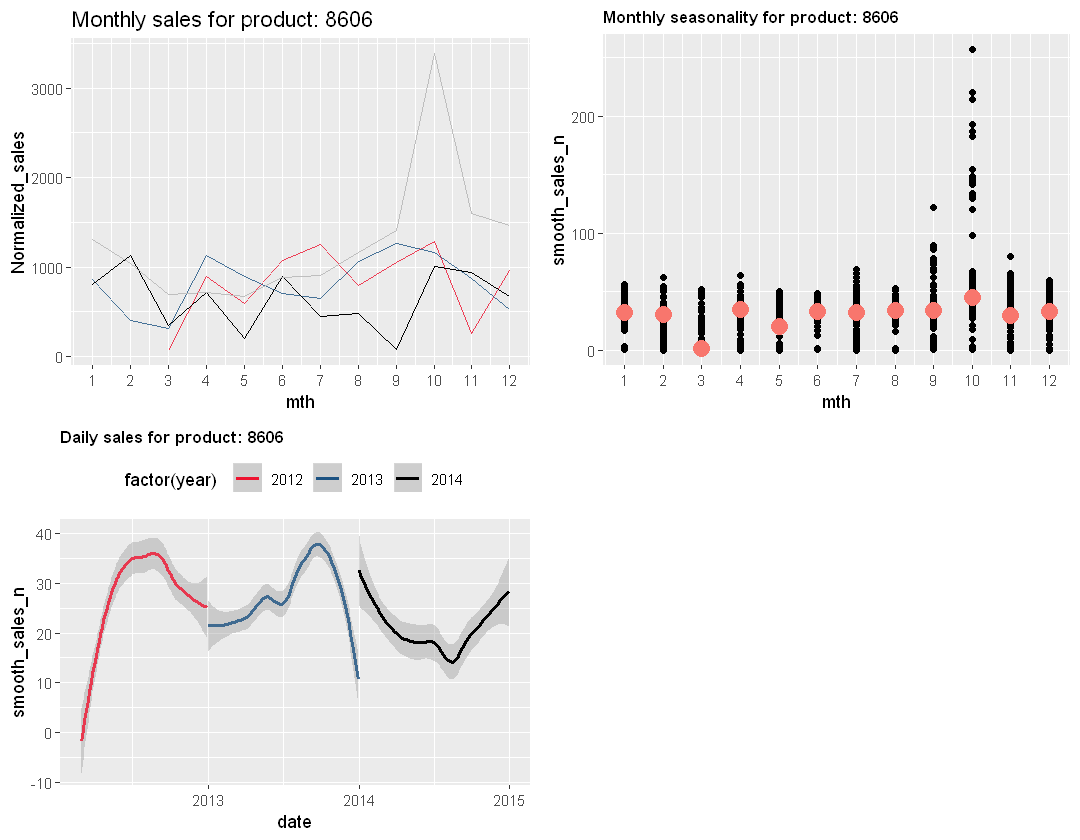

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


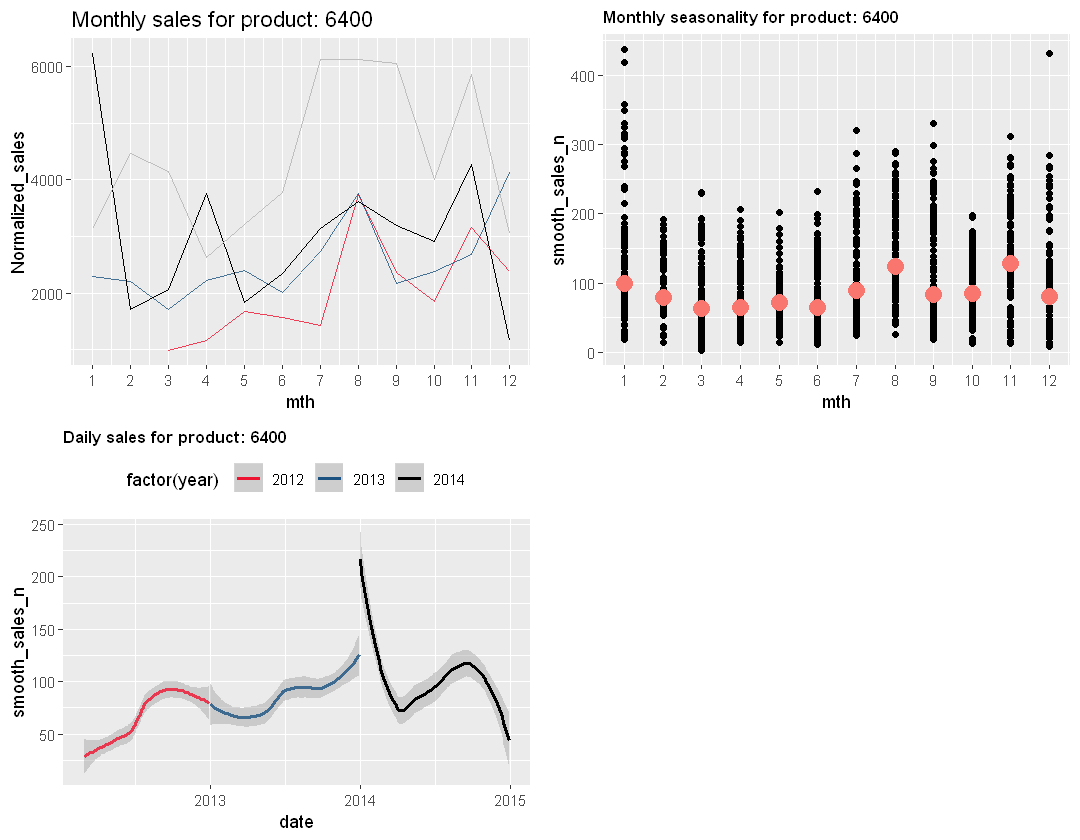

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


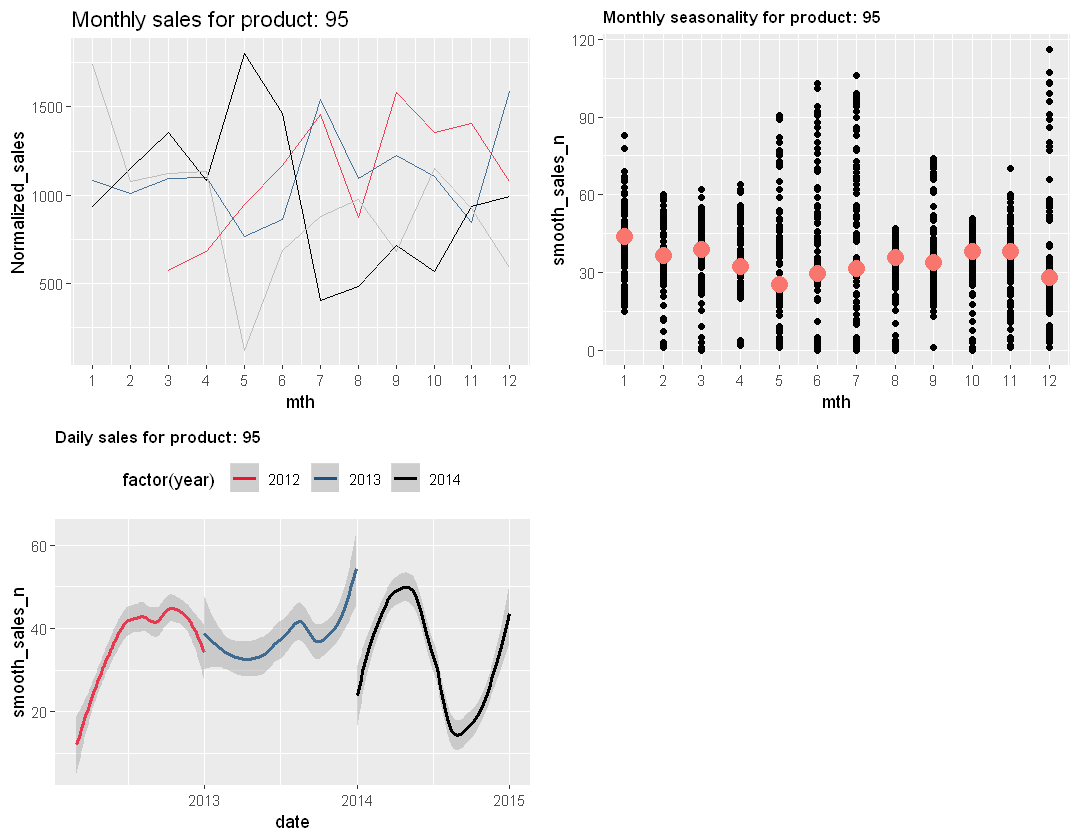

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


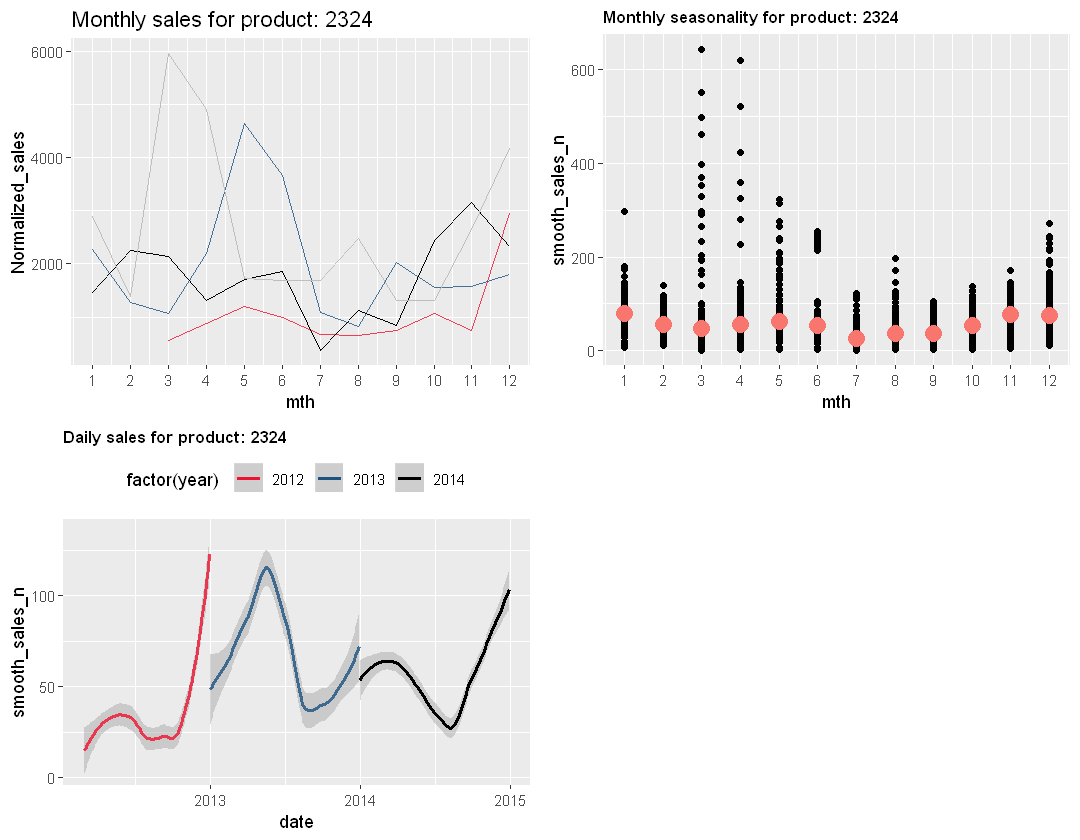

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


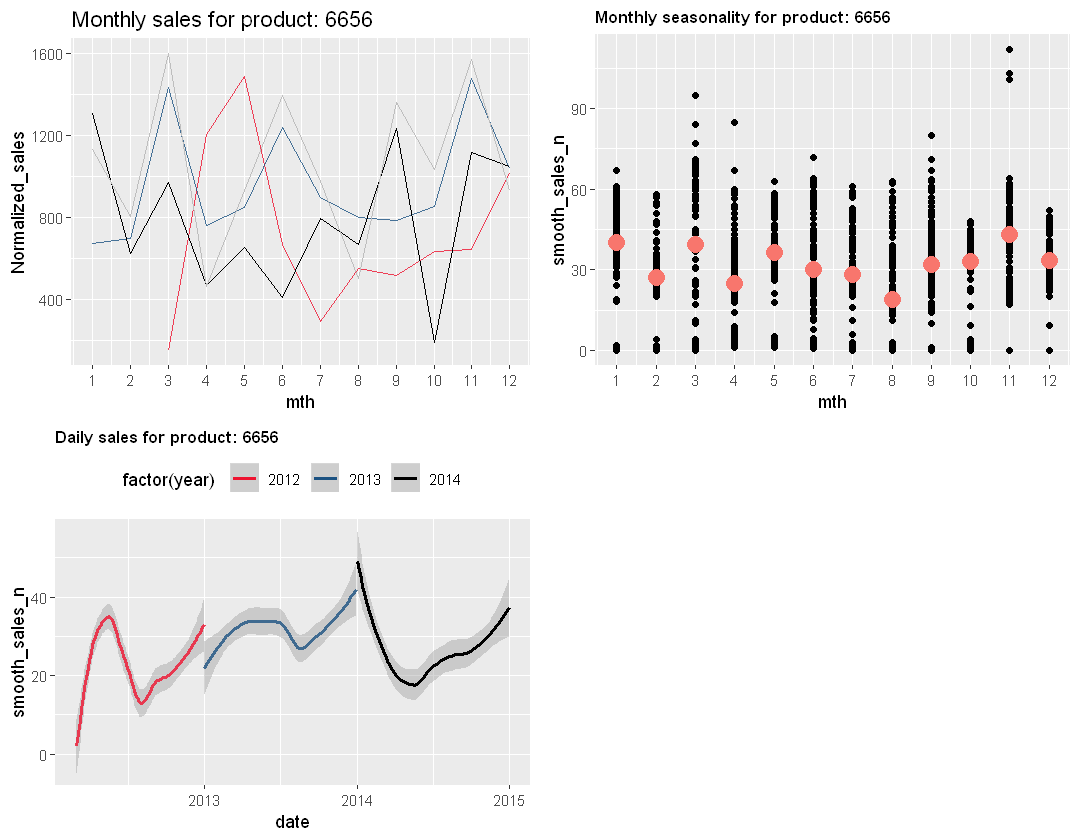

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


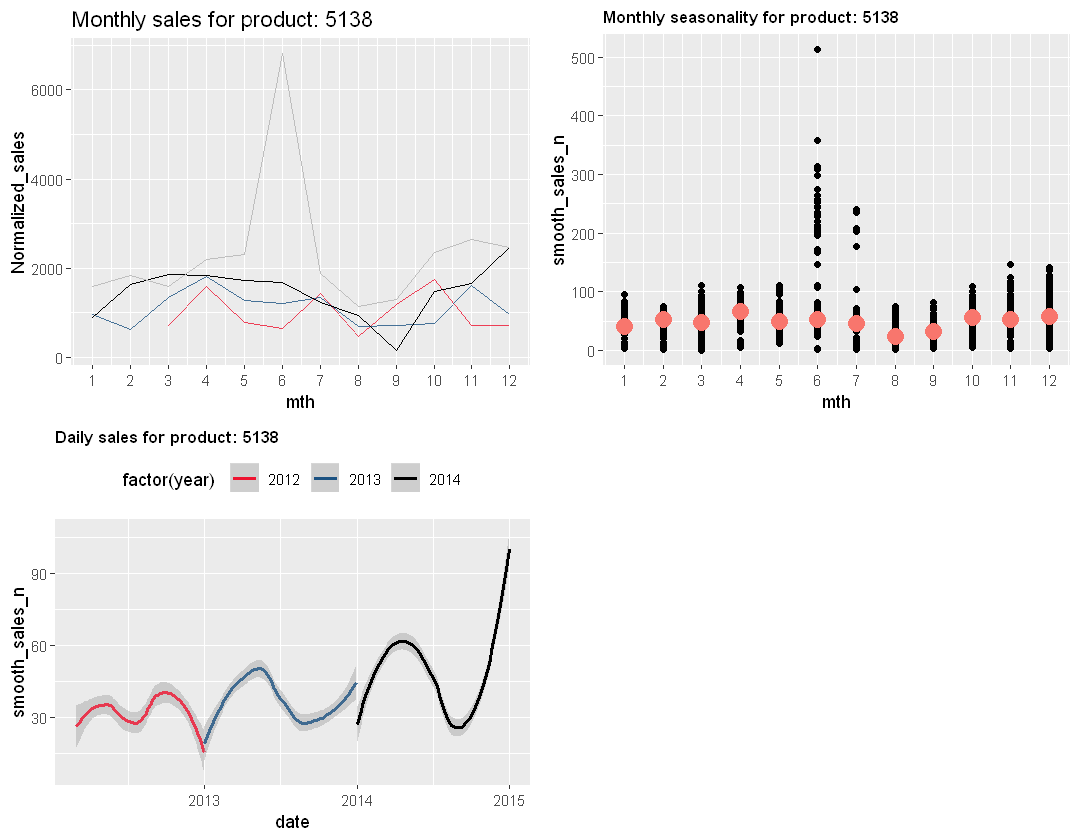

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


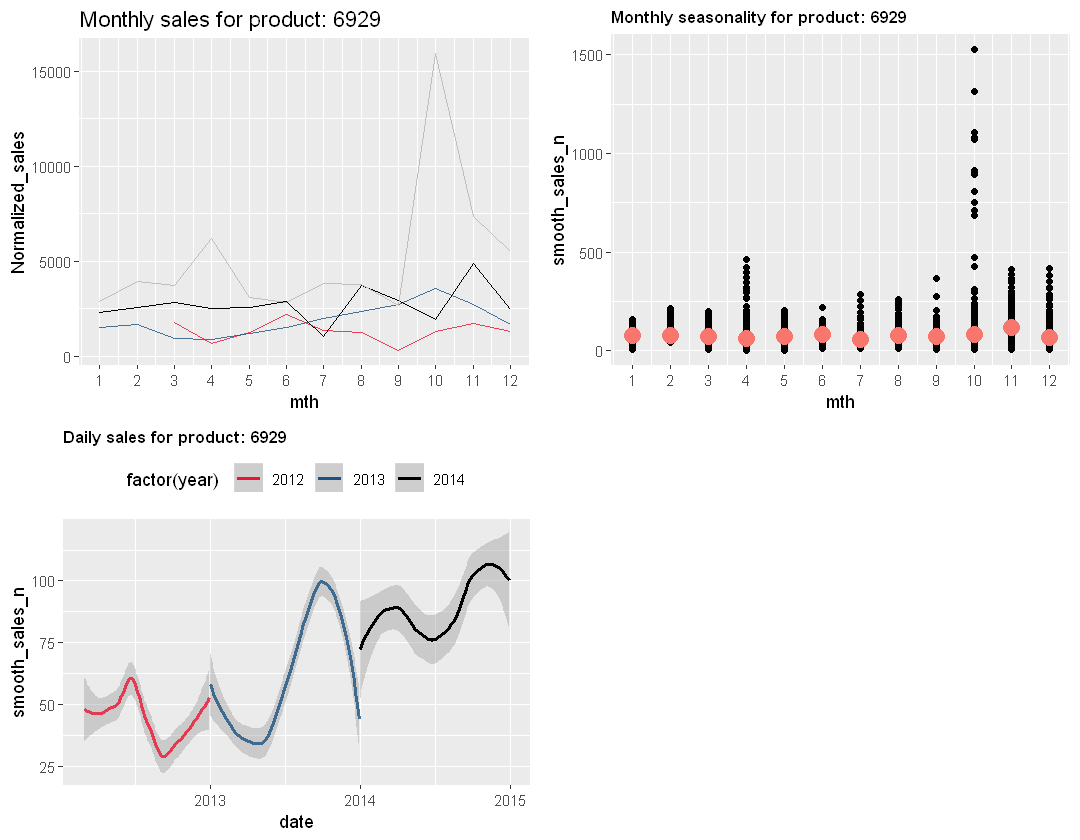

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


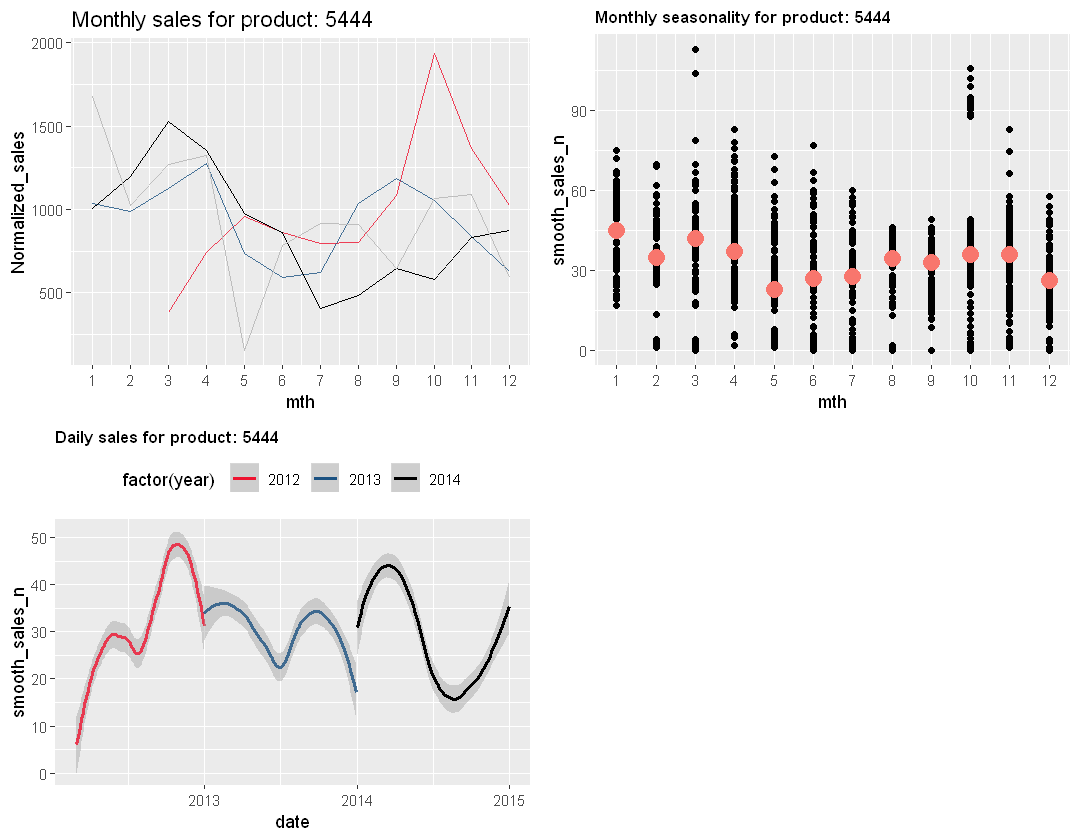

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


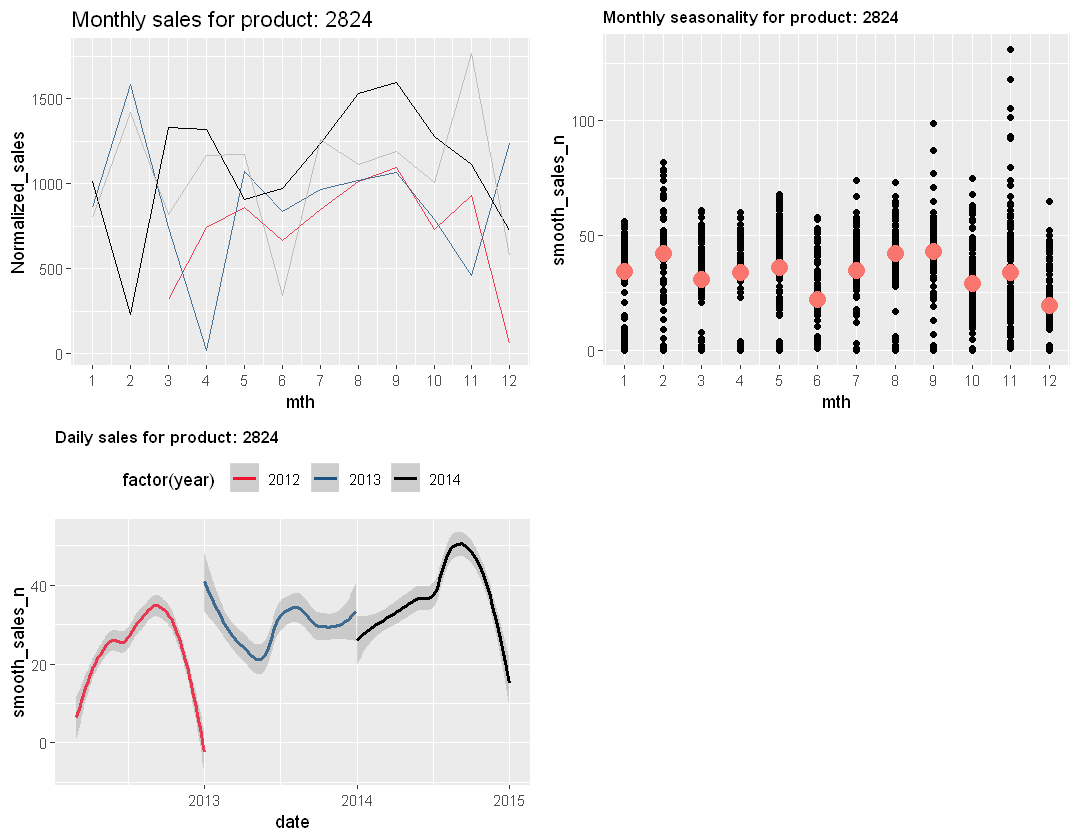

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


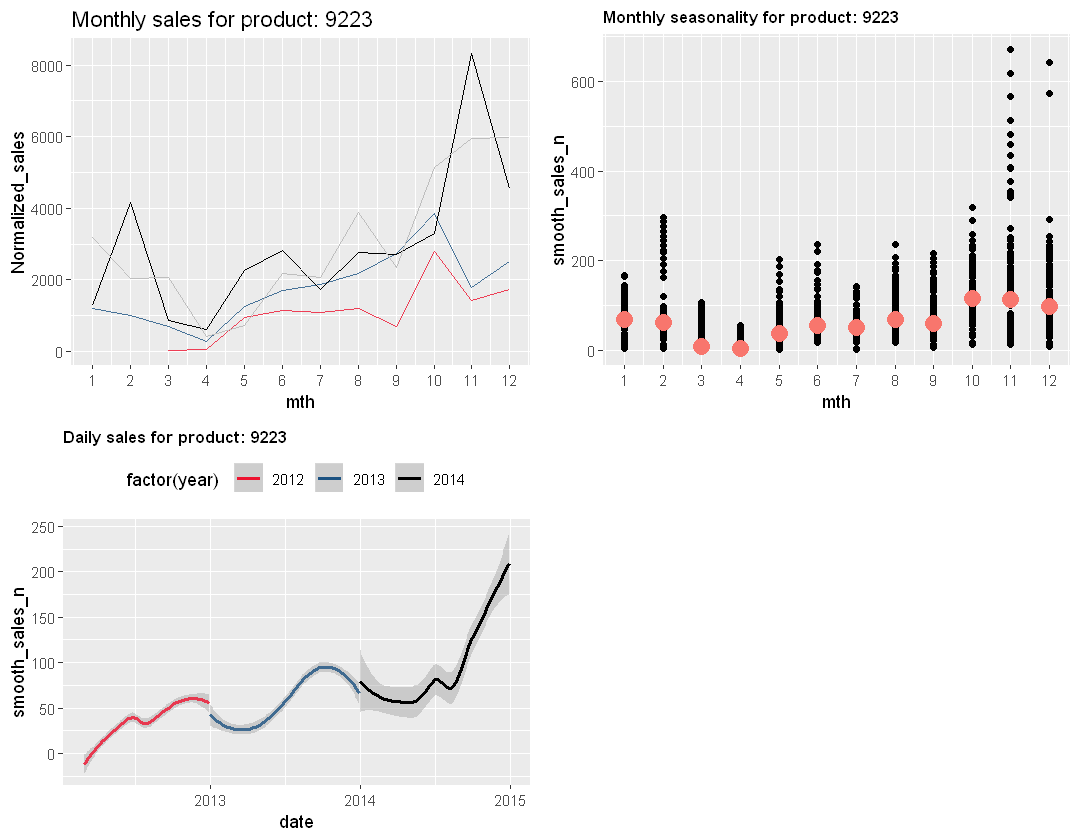

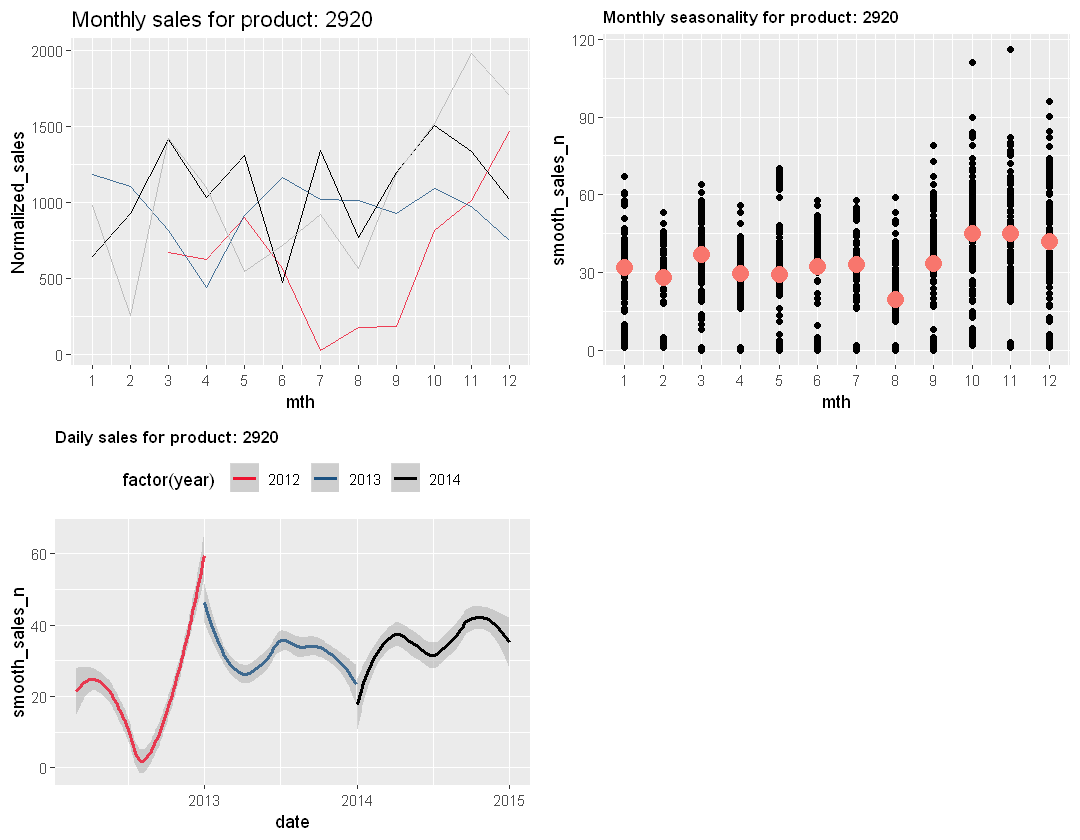

In [101]:
for(i in seq(1:15)){
gridExtra::grid.arrange(plot_sales_line(smpl[i]), plot_sales_pt(smpl[i]),plot_sales_smoothened(smpl[i]), ncol=2,nrow=2)
}

### Impact of product and brand promo on data

In [102]:
print(paste(nrow(product_promo), length(unique(product_promo$product)) ,
        nrow(brand_promo)  ,length(unique(brand_promo$brand))))

[1] "23985 9106 6015 40"


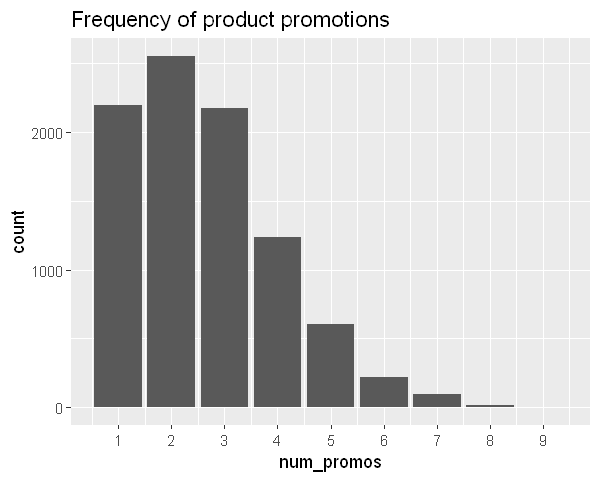

In [103]:
options(repr.plot.width=5, repr.plot.height=4)
##Avg campaigns per product
product_promo %>% group_by(product) %>% summarise(num_promos = n()) %>% ggplot(aes(x=num_promos))+ 
geom_bar() + scale_x_continuous(breaks = seq(1,10, by = 1)) + 
ggtitle(paste("Frequency of product promotions"))

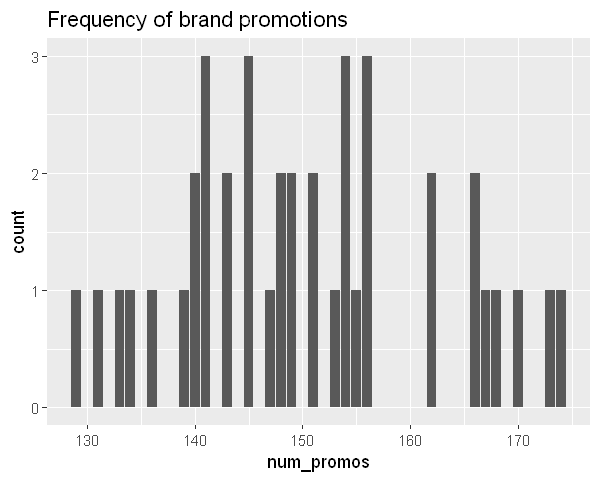

In [104]:
##Avg campaigns per brand
brand_promo %>% group_by(brand) %>% summarise(num_promos = n()) %>% ggplot(aes(x=num_promos))+ 
geom_bar() + 
ggtitle(paste("Frequency of brand promotions"))

In [78]:
options(repr.plot.width=8, repr.plot.height=10)
##Attaching product to brand promo using map
brand_product_promo = map %>% inner_join(brand_promo %>% mutate(brand = as.factor(brand))
                                         %>% select(brand,start_date),by='brand')

plot_productpromo <- function(x, start, end){

  
filter(sales_oos,product %in% c(x) & date >= start & date < end )%>%mutate(year=year(date)) %>%
ggplot(aes(x = date)) +
    geom_smooth(aes(y=smooth_sales_n),se = FALSE)+
    geom_point(aes(y=smooth_sales_n)) +
    geom_vline(data = filter(product_promo,product==x),aes(xintercept= start_date, color = "red",size=2))+
    geom_vline(data = filter(brand_product_promo,product==x),aes(xintercept= start_date, color = "green"))+
    ggtitle(paste("Brand promotion(red) & Product promotion(cyan) impact on product: ",x, "Start date:",start,"End date",end))+
    theme(legend.position="none",plot.title = element_text(face = "bold", size = 10))  
    }

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


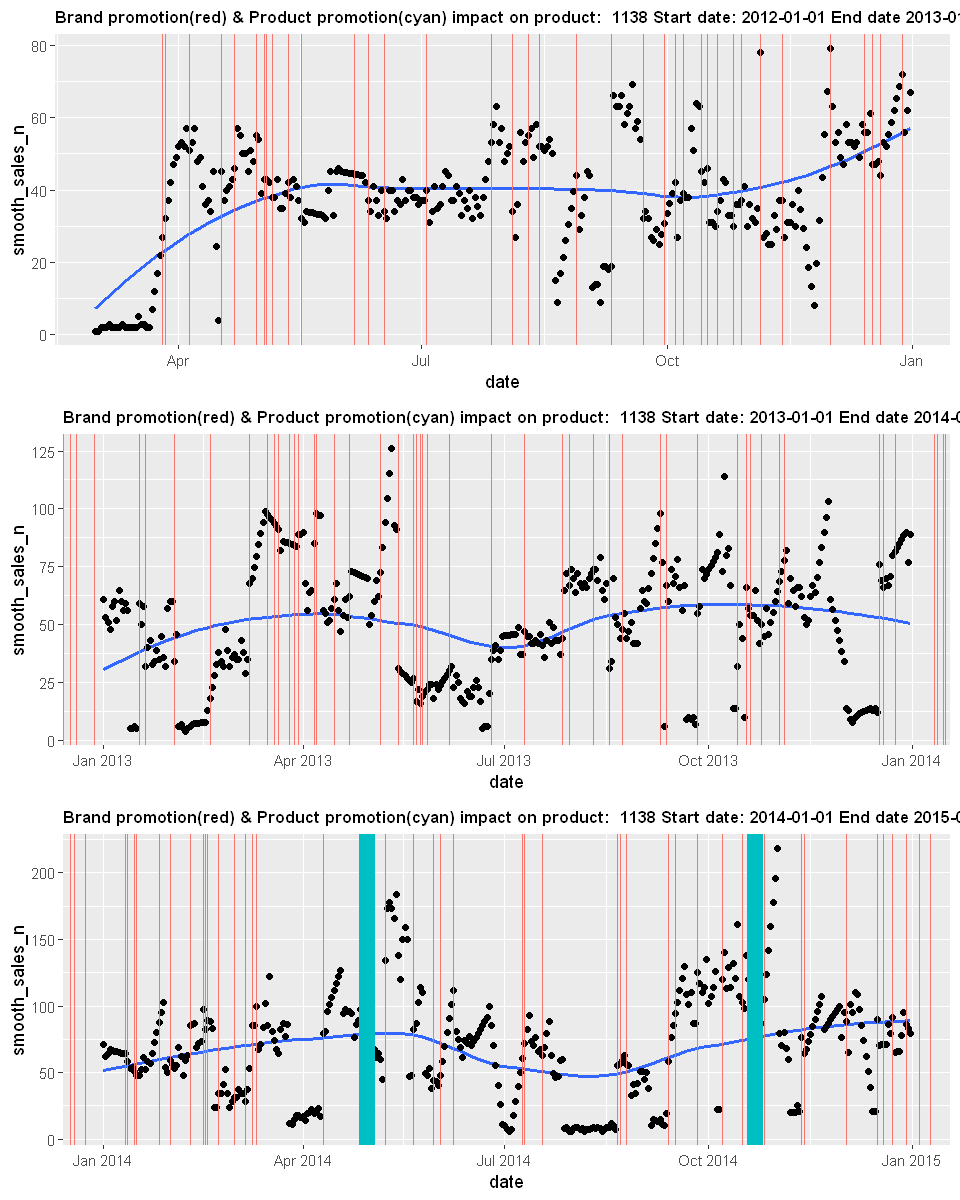

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


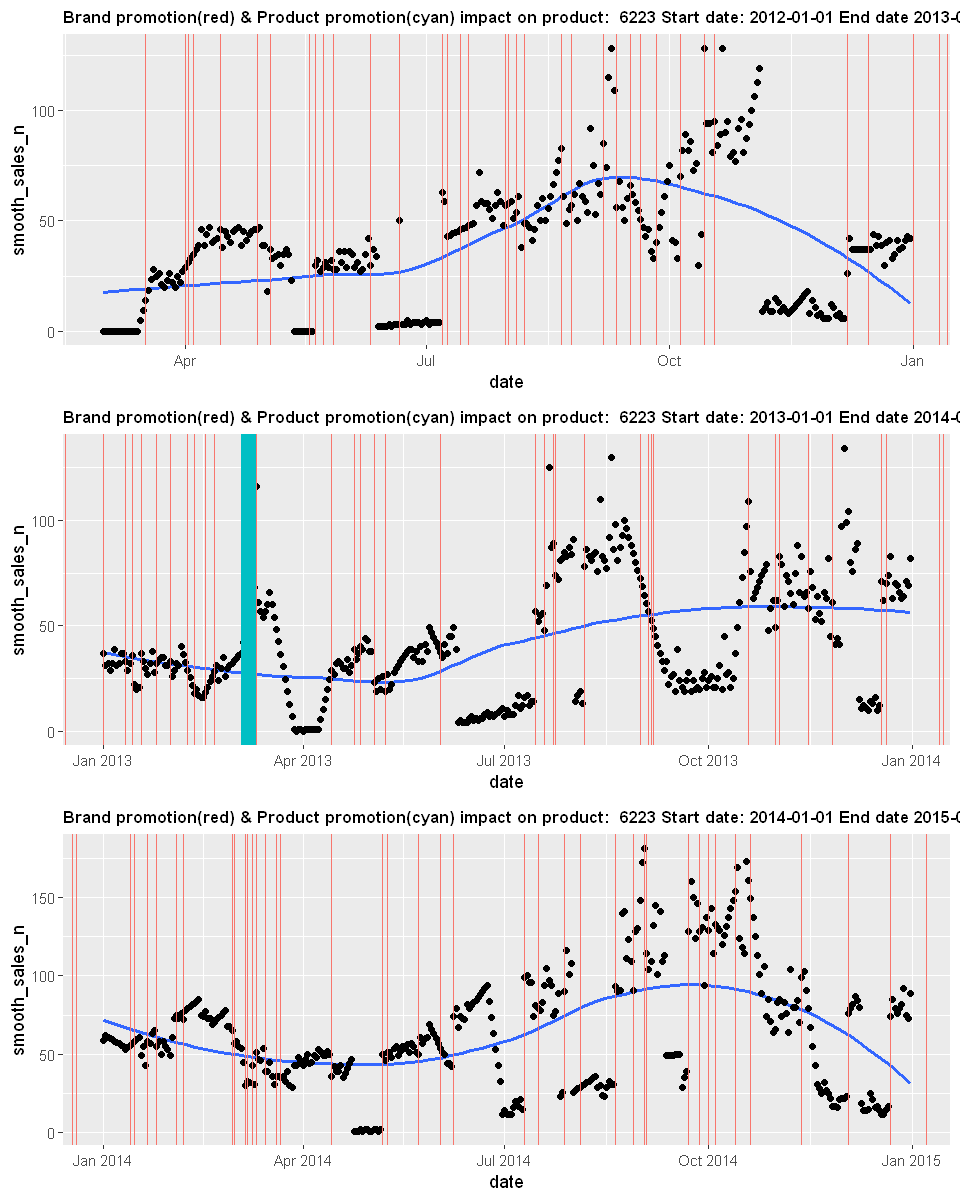

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


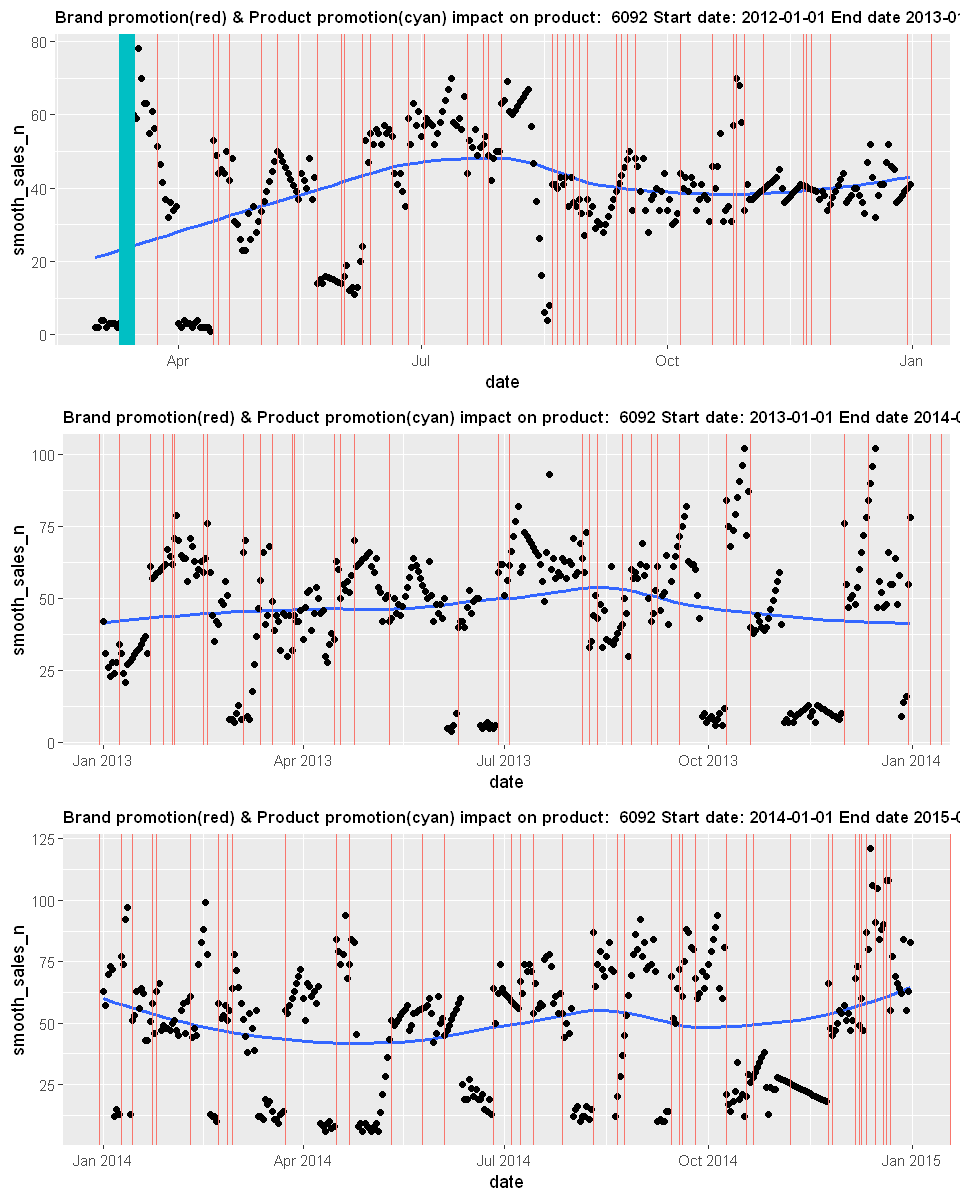

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


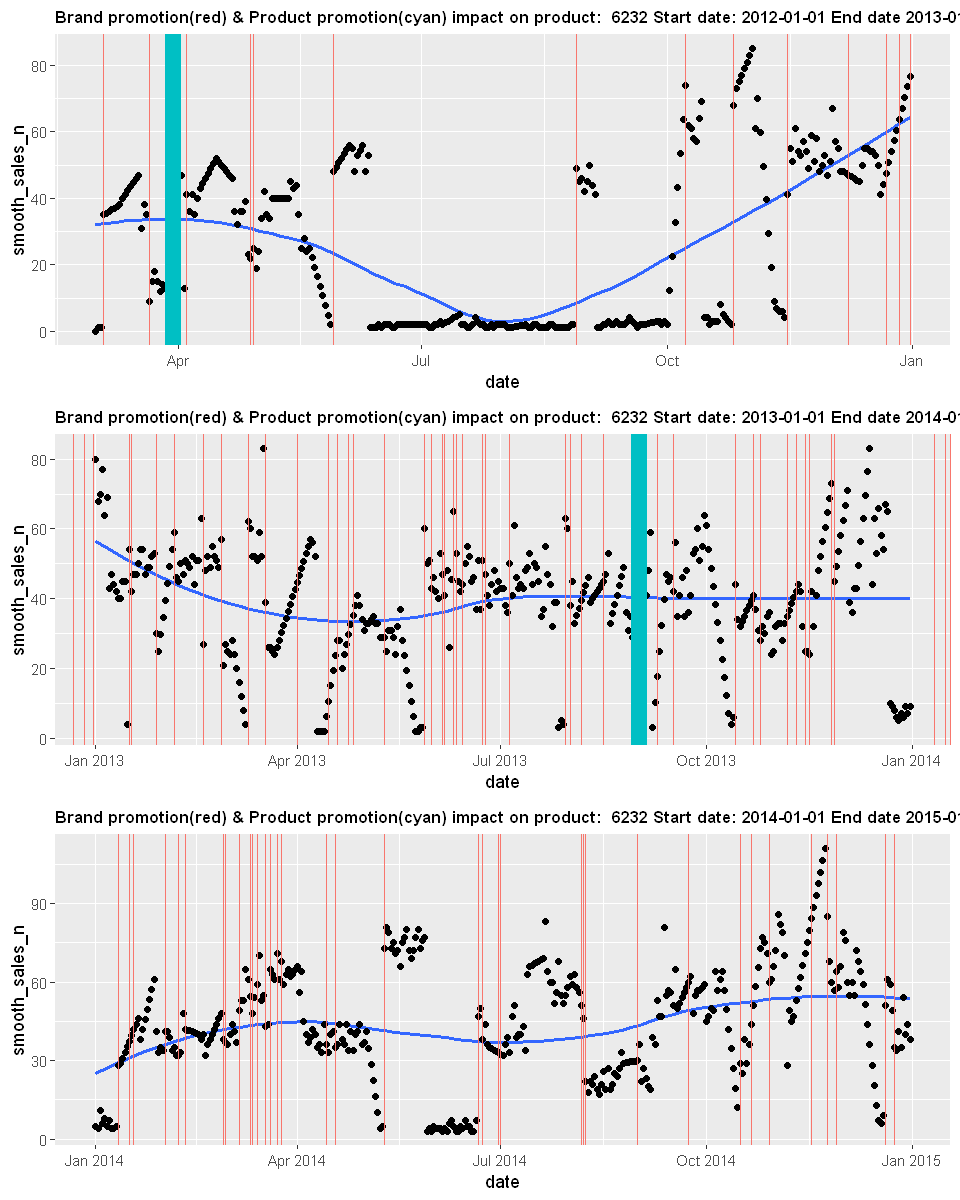

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


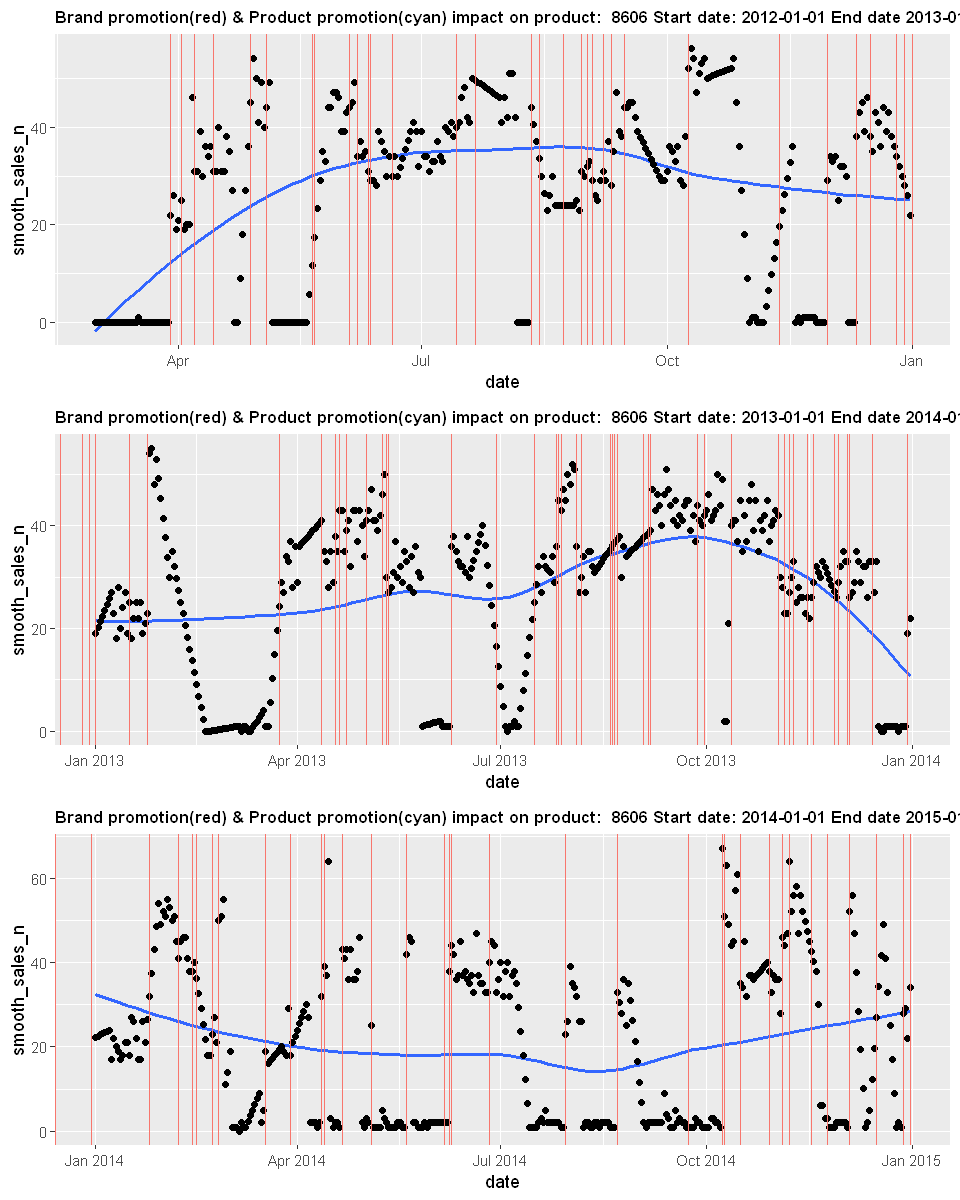

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


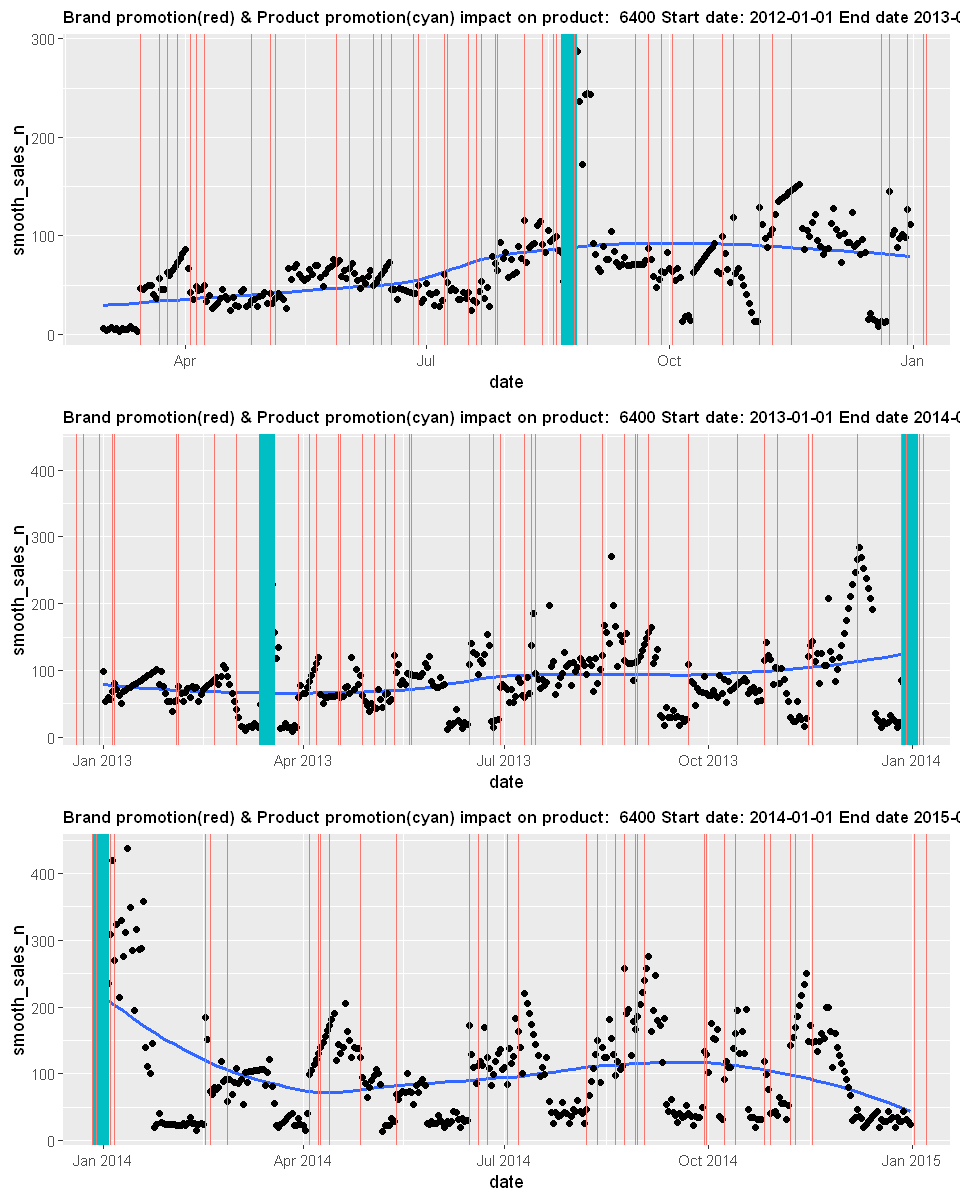

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


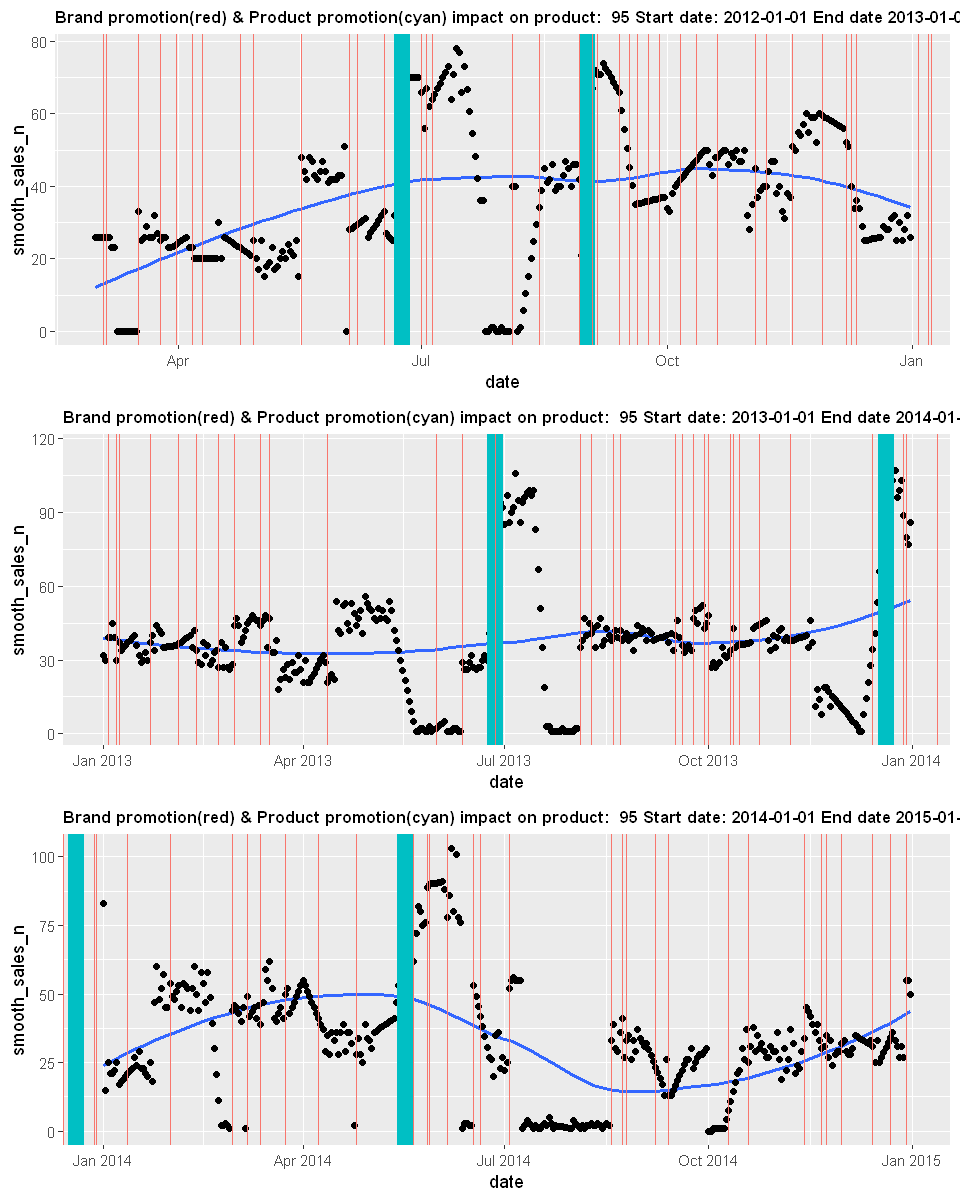

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


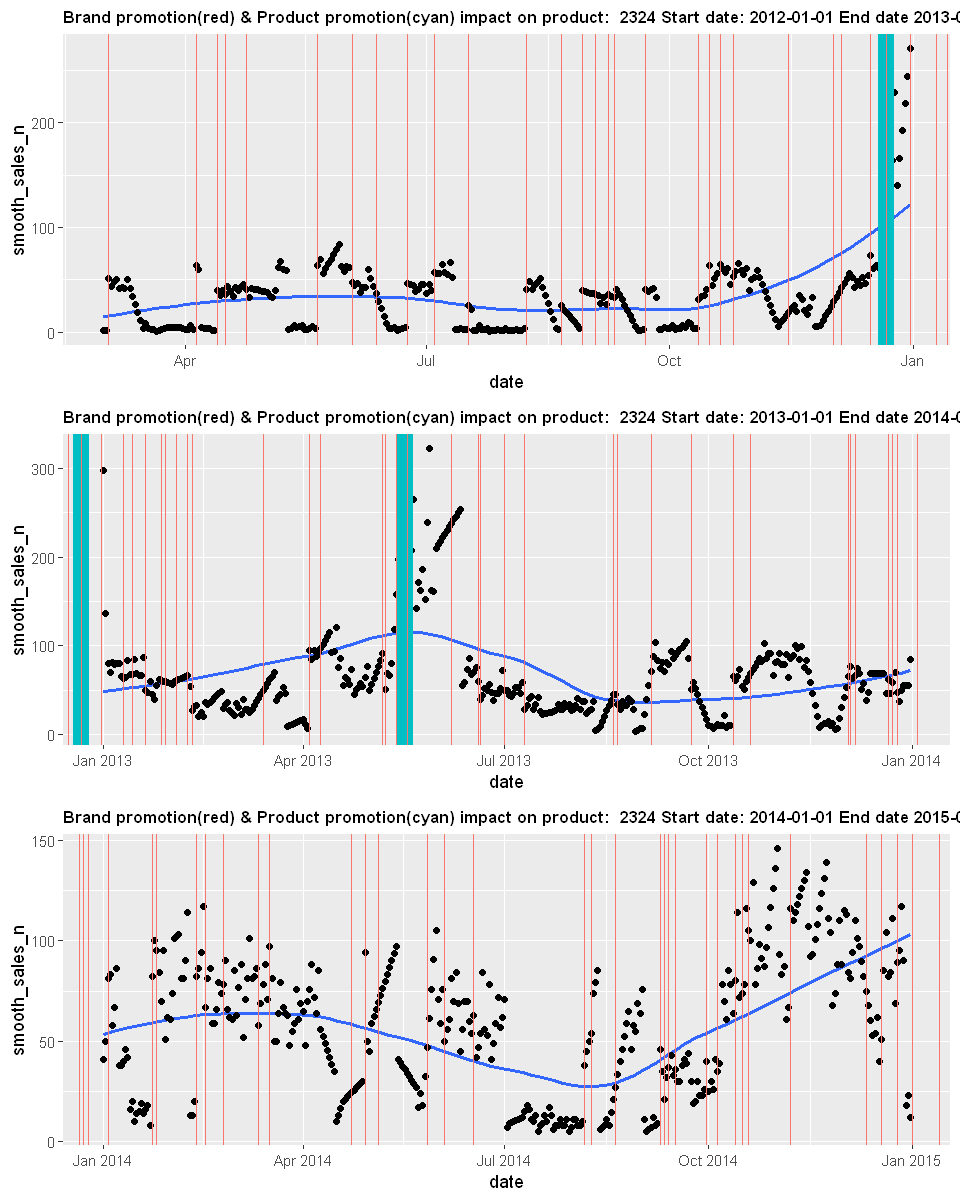

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


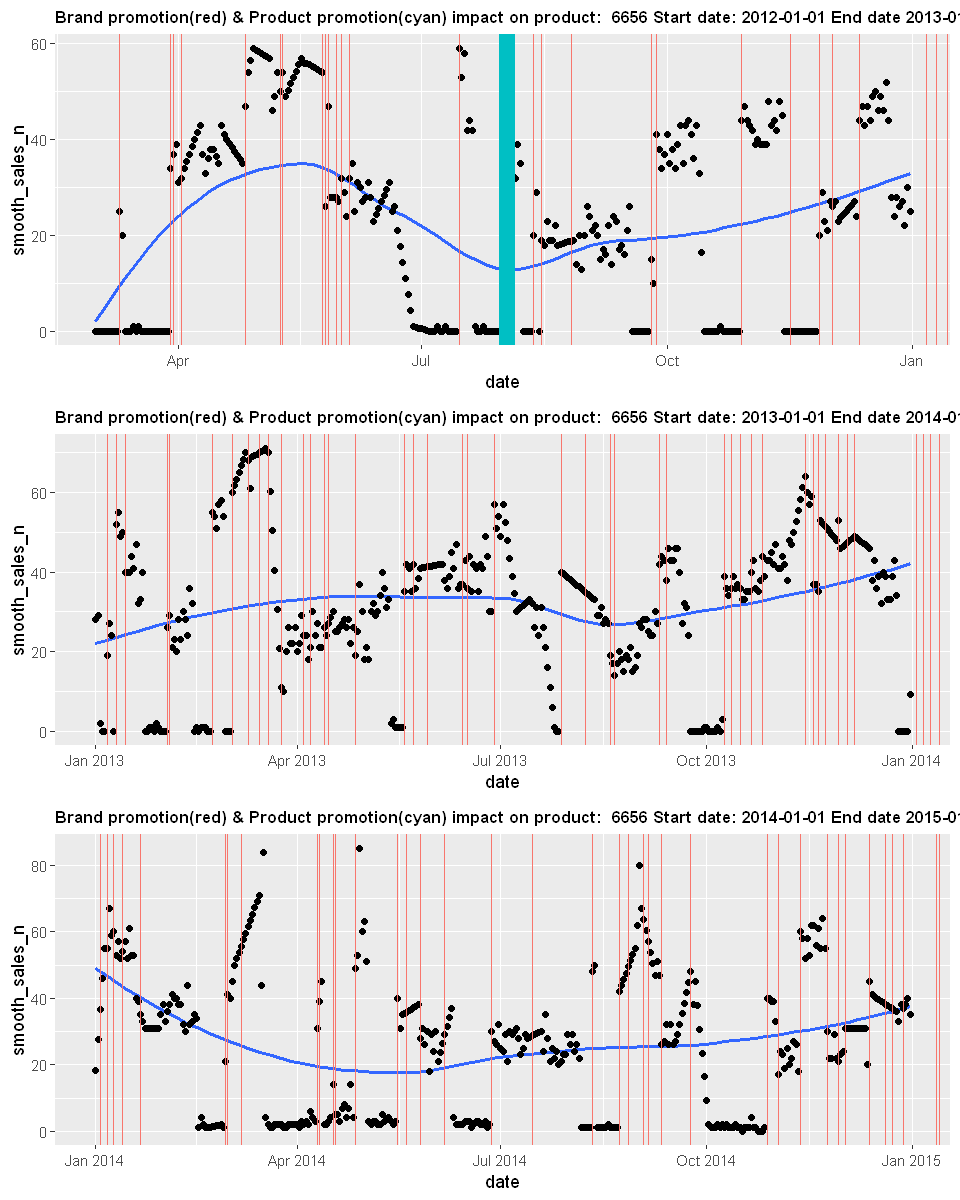

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


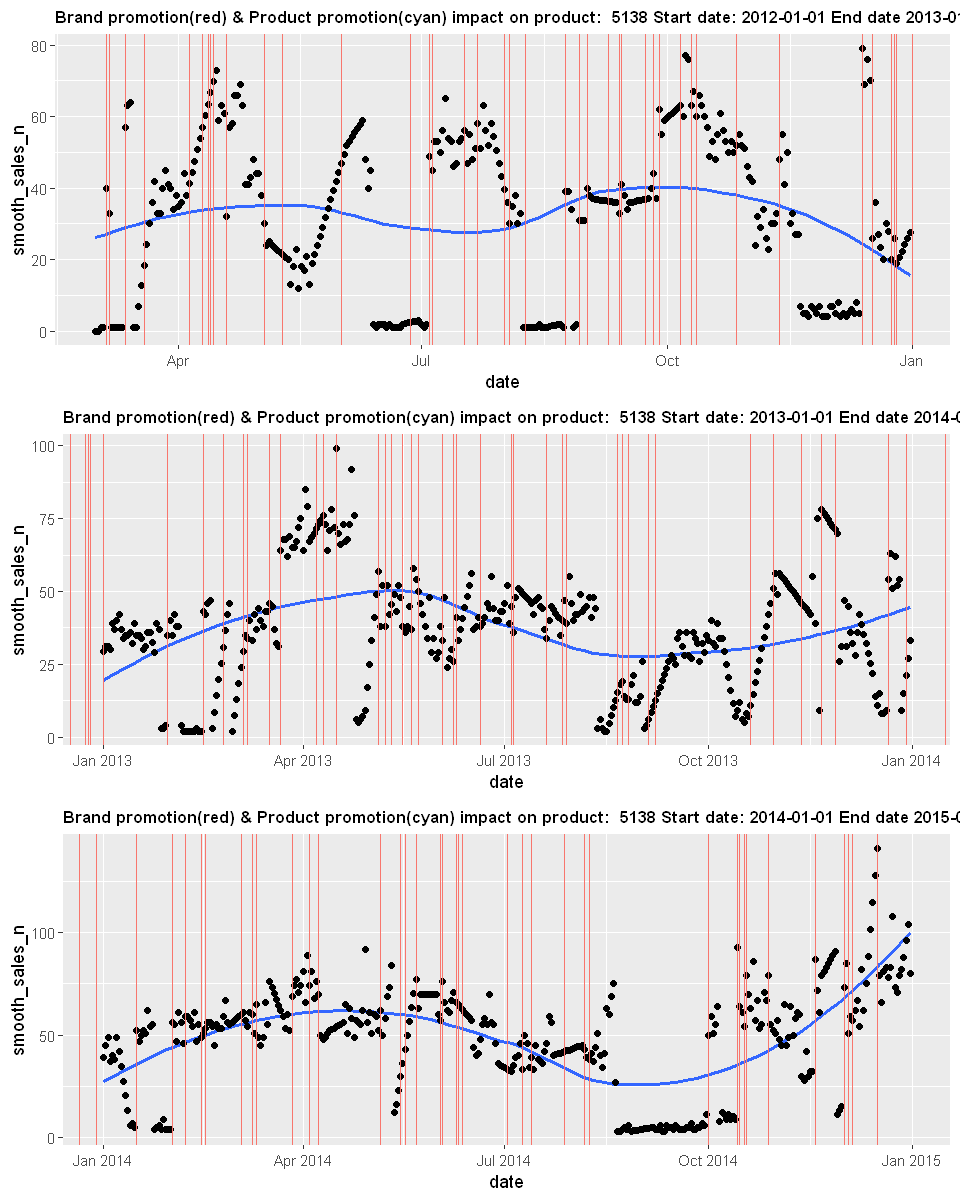

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


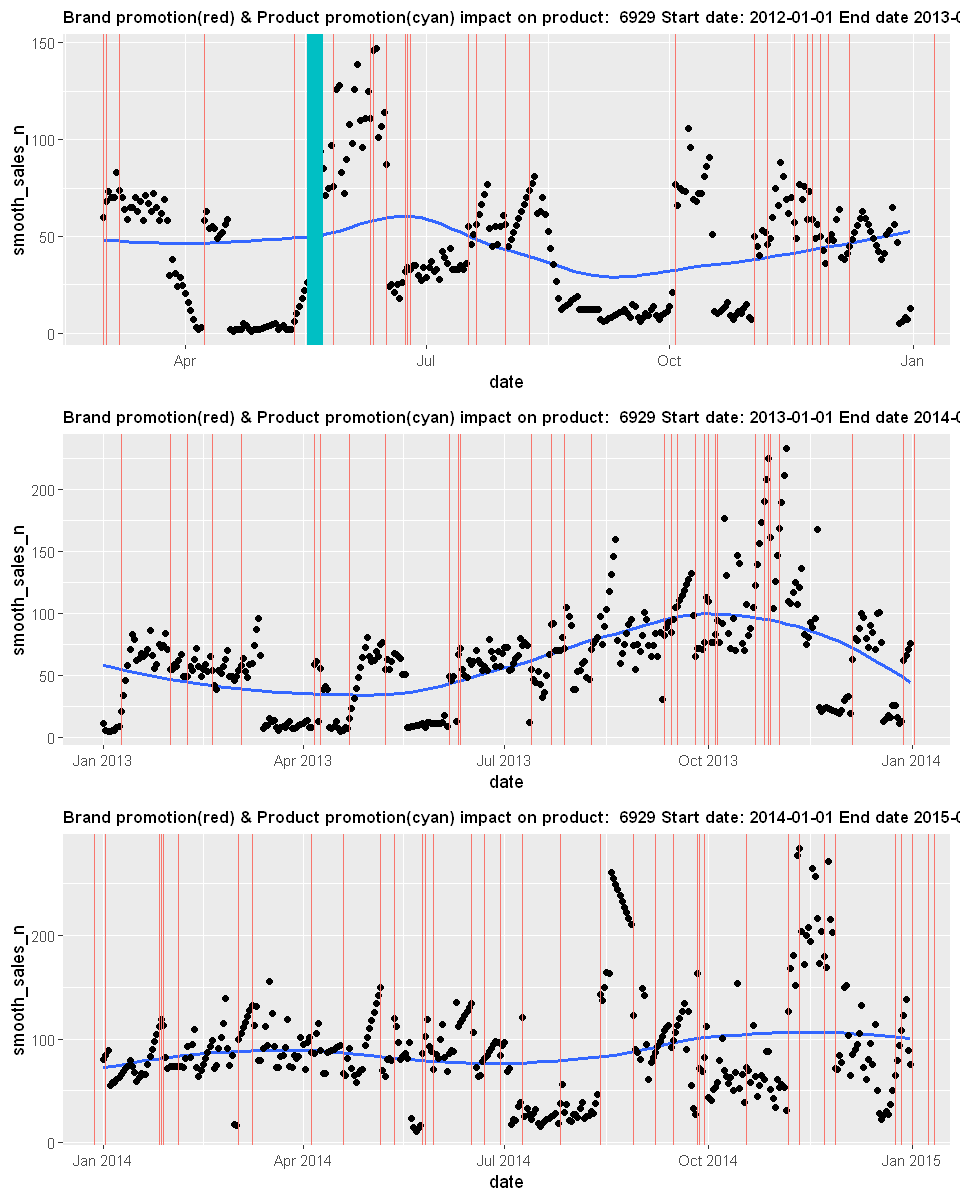

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


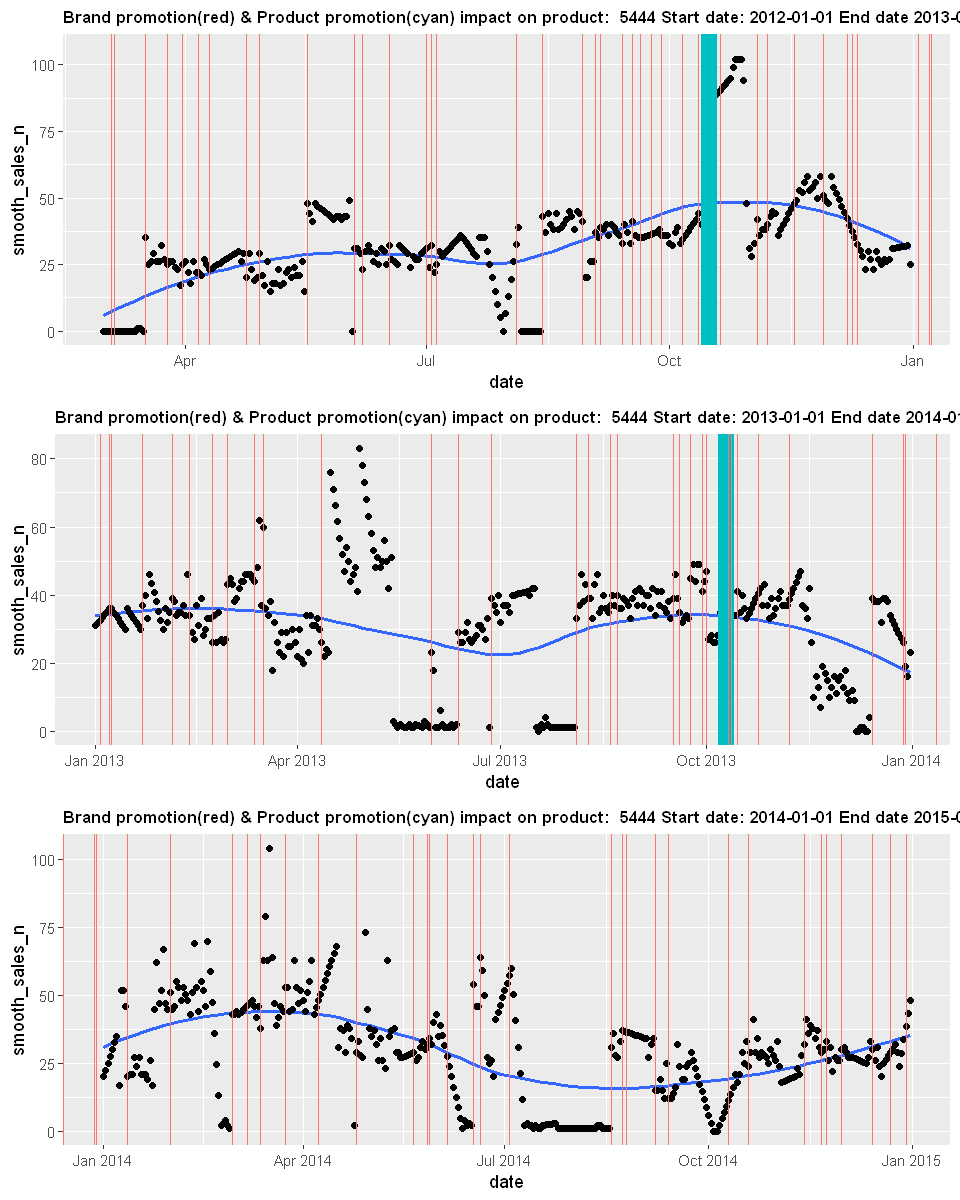

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


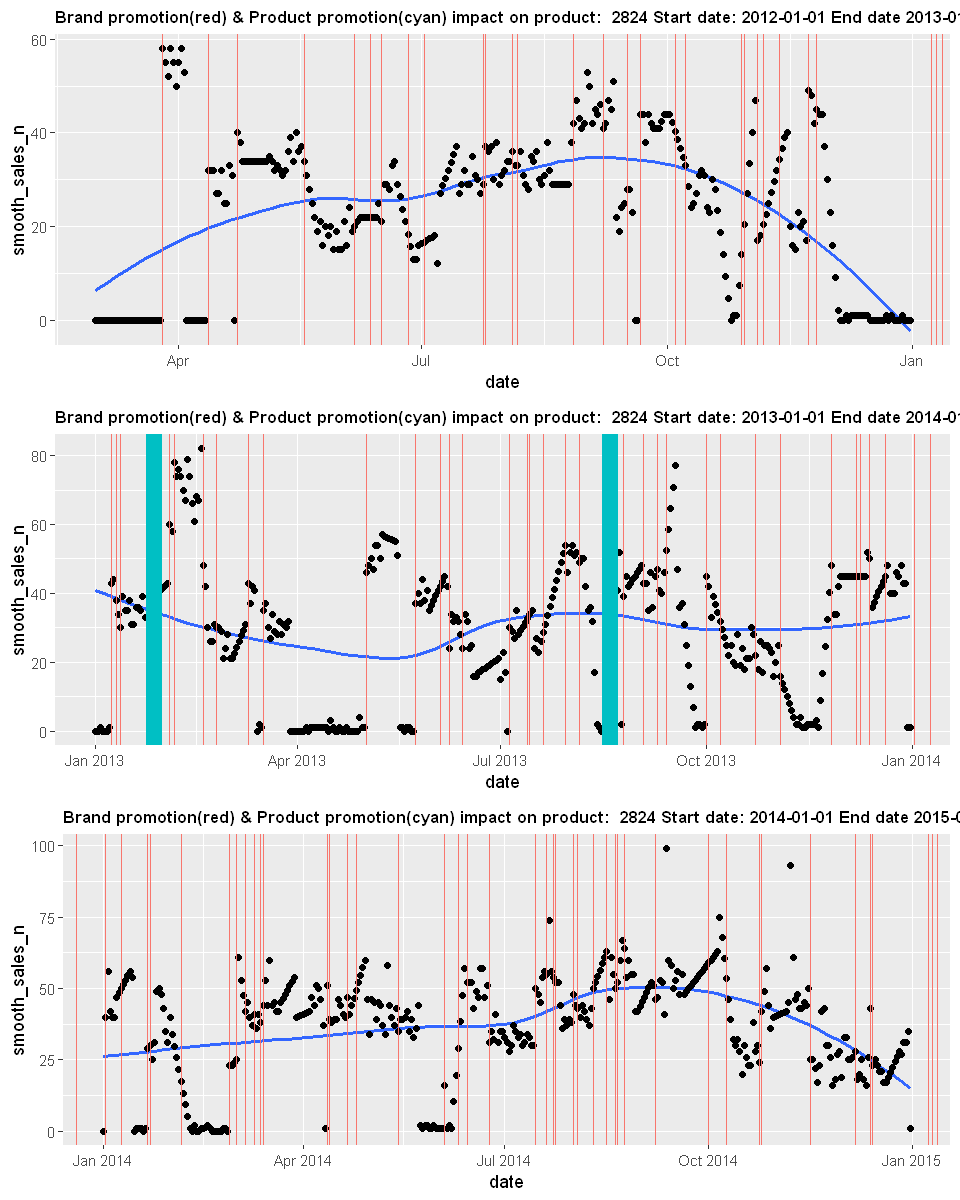

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


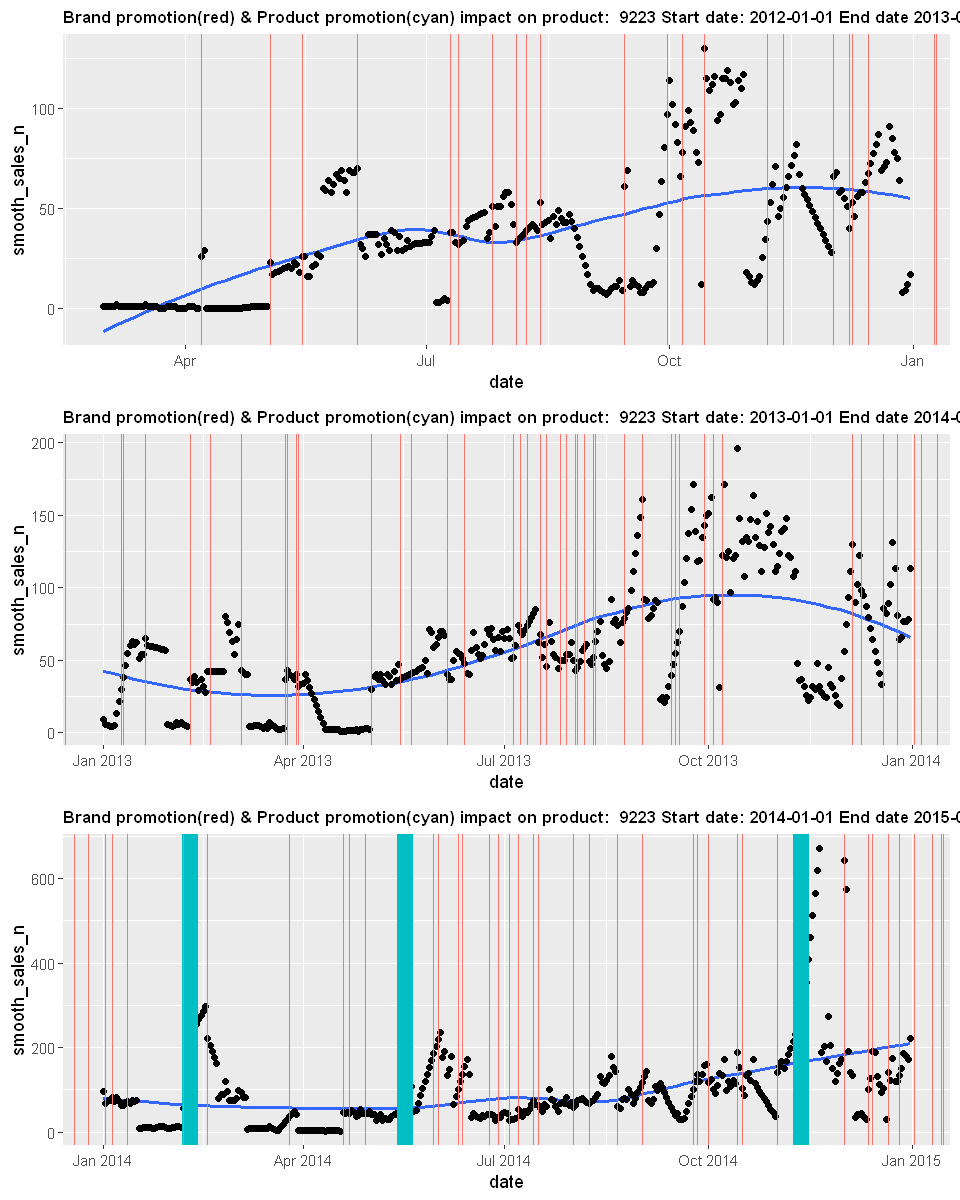

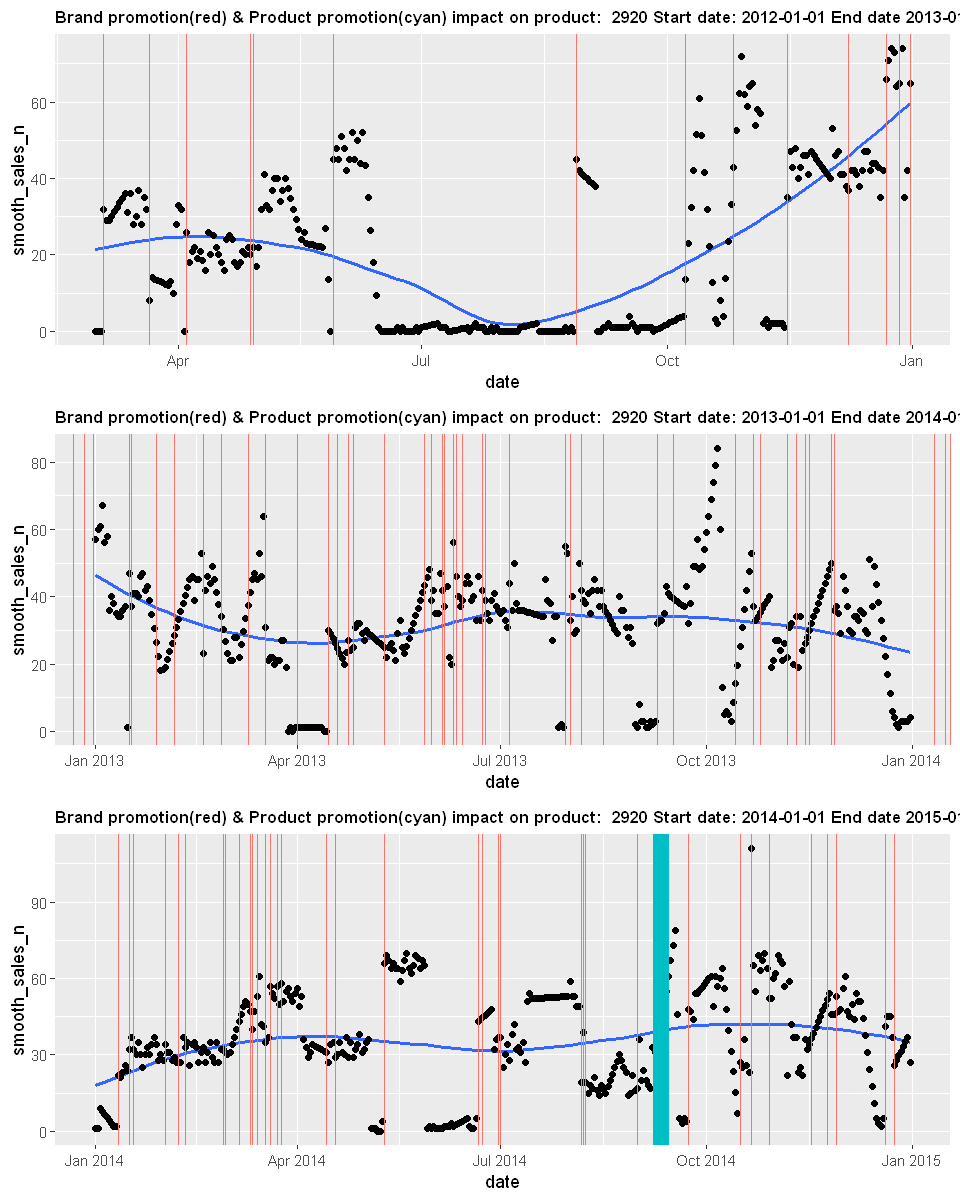

In [79]:
for(i in seq(1:15)){
gridExtra::grid.arrange(
plot_productpromo(smpl[i],ymd('2012-01-01'),ymd('2013-01-01')),
plot_productpromo(smpl[i],ymd('2013-01-01'),ymd('2014-01-01')),
plot_productpromo(smpl[i],ymd('2014-01-01'),ymd('2015-01-01')), ncol=1,nrow=3)
}

### Clear impact of brand and product promotion


### 26 columns with multiple product promos on same day

In [13]:
tail(product_promo %>% group_by(product,start_date) %>% summarise(cnt = n()) %>% arrange(cnt),30)

product start_date cnt
1  9997    2015-02-04 1  
2  9998    2013-08-06 1  
3  9998    2014-01-21 1  
4  9999    2012-10-05 1  
5   253    2014-02-07 2  
6  1248    2015-07-26 2  
7  1314    2014-10-18 2  
8  2283    2013-11-15 2  
9  2295    2013-02-12 2  
10 2401    2015-12-13 2  
11 3544    2012-11-06 2  
12 3591    2013-07-28 2  
13 3655    2014-02-13 2  
14 4624    2014-04-16 2  
15 5009    2013-06-25 2  
16 5024    2012-09-05 2  
17 5159    2013-06-25 2  
18 5270    2013-04-01 2  
19 5820    2013-01-08 2  
20 6064    2012-04-02 2  
21 6356    2012-06-13 2  
22 7010    2014-01-24 2  
23 7327    2013-07-04 2  
24 7433    2012-12-23 2  
25 8340    2013-10-25 2  
26 8624    2014-01-08 2  
27 8751    2015-05-16 2  
28 9093    2013-01-12 2  
29 9101    2014-03-12 2  
30 9208    2012-12-20 2

In [13]:
#product_promo_copy = product_promo %>% group_by(product,start_date) %>% summarise(
#prod_f0=sum(f0),prod_f1=sum(f1),prod_f2=sum(f2),prod_f3=sum(f3),prod_f4=sum(f4),prod_f5=sum(f5),
#prod_f6=sum(f6),prod_f7=sum(f7),prod_f8=sum(f8),prod_f9=sum(f9),prod_f10=sum(f10),prod_f11=sum(f11),
#prod_f12=sum(f12),prod_f13=sum(f13),prod_f14=sum(f14),prod_f15=sum(f15),prod_f16=sum(f16),prod_f17=sum(f17),
#prod_f18=sum(f18),prod_f19=sum(f19),prod_f20=sum(f20),prod_f21=sum(f21),prod_f22=sum(f22),prod_f23=sum(f23),
#prod_f24=sum(f24),prod_f25=sum(f25),prod_f26=sum(f26),prod_f27=sum(f27),prod_f28=sum(f28),prod_f29=sum(f29))


In [15]:
#sales_oos = sales_oos %>% left_join(mutate(product_promo_copy,date = start_date) %>%
                                  #  select(product,date,start_date), by = c('product','date'))
nrow(product_promo)

[1] 23985

In [13]:
sales_oos = sales_oos %>% left_join(mutate(product_promo %>% group_by(product,start_date) %>% summarise(cnt = n())                                           
                                           ,date = start_date) %>%
                                  select(product,date,start_date), by = c('product','date'))
paste(nrow(sales_oos), ncol(sales_oos))

[1] "14330000 20"

In [14]:
#### freeing space
rm(tidy_oos,temp,tempx,tidy_sales)
gc()

used      (Mb)   gc trigger (Mb)   max used  (Mb)  
Ncells   3383273  180.7   6518628   348.2   6518628  348.2
Vcells 278914174 2128.0 809233413  6174.0 802766134 6124.7

### Adding number of promos in the last 3-D,7-D,21-D,....

In [ ]:
#sales_oos$prodpromo = apply(sales_oos[c('prod_f0', 'prod_f1' , 'prod_f2', 'prod_f3', 'prod_f4' , 'prod_f5', 'prod_f6', 
#                  'prod_f7', 'prod_f8', 'prod_f9', 'prod_f10' , 'prod_f11' , 'prod_f12' , 'prod_f13' , 'prod_f14',
#                  'prod_f15' , 'prod_f16' , 'prod_f17' , 'prod_f18' , 'prod_f19' , 'prod_f20' , 'prod_f21' , 
#                  'prod_f22' , 'prod_f23' , 'prod_f24' , 'prod_f25' , 'prod_f26' , 'prod_f27' , 'prod_f28' , 'prod_f29')]
#      ,1,function(x){max(x)})


In [15]:
sales_oos = sales_oos %>% mutate(prodpromo = (!is.na(start_date)*1)) %>% mutate(prodpromo= prodpromo*1)
sales_oos = select(sales_oos,-start_date)

In [30]:
#sales_oos$L1_prodpromo = Lag(sales_oos$prodpromo	, 1 )          ;
#sales_oos$L1_p_f0  =    Lag(sales_oos$prod_f0		, 1 )          ;
#sales_oos$L1_p_f1  =    Lag(sales_oos$prod_f1		, 1 )          ;
#sales_oos$L1_p_f2  =    Lag(sales_oos$prod_f2		, 1 )          ;
#sales_oos$L1_p_f3  =    Lag(sales_oos$prod_f3		, 1 )          ;
#sales_oos$L1_p_f4  =    Lag(sales_oos$prod_f4		, 1 )          ;
#sales_oos$L1_p_f5  =    Lag(sales_oos$prod_f5		, 1 )          ;
#sales_oos$L1_p_f6  =    Lag(sales_oos$prod_f6		, 1 )          ;
#sales_oos$L1_p_f7  =    Lag(sales_oos$prod_f7		, 1 )          ;
#sales_oos$L1_p_f8  =    Lag(sales_oos$prod_f8		, 1 )          ;
#sales_oos$L1_p_f9  =    Lag(sales_oos$prod_f9		, 1 )          ;
#sales_oos$L1_p_f10  =    Lag(sales_oos$prod_f10	, 1	)          ;
#sales_oos$L1_p_f11  =    Lag(sales_oos$prod_f11	, 1	)          ;
#sales_oos$L1_p_f12  =    Lag(sales_oos$prod_f12	, 1	)          ;
#sales_oos$L1_p_f13  =    Lag(sales_oos$prod_f13	, 1	)          ;
#sales_oos$L1_p_f14  =    Lag(sales_oos$prod_f14	, 1	)          ;
#sales_oos$L1_p_f15  =    Lag(sales_oos$prod_f15	, 1	)          ;
#sales_oos$L1_p_f16  =    Lag(sales_oos$prod_f16	, 1	)          ;
#sales_oos$L1_p_f17  =    Lag(sales_oos$prod_f17	, 1	)          ;
#sales_oos$L1_p_f18  =    Lag(sales_oos$prod_f18	, 1	)          ;
#sales_oos$L1_p_f19  =    Lag(sales_oos$prod_f19	, 1	)          ;
#sales_oos$L1_p_f20  =    Lag(sales_oos$prod_f20	, 1	)          ;
#sales_oos$L1_p_f21  =    Lag(sales_oos$prod_f21	, 1	)          ;
#sales_oos$L1_p_f22  =    Lag(sales_oos$prod_f22	, 1	)          ;
#sales_oos$L1_p_f23  =    Lag(sales_oos$prod_f23	, 1	)          ;
#sales_oos$L1_p_f24  =    Lag(sales_oos$prod_f24	, 1	)          ;
#sales_oos$L1_p_f25  =    Lag(sales_oos$prod_f25	, 1	)          ;
#sales_oos$L1_p_f26  =    Lag(sales_oos$prod_f26	, 1	)          ;
#sales_oos$L1_p_f27  =    Lag(sales_oos$prod_f27	, 1	)          ;
#sales_oos$L1_p_f28  =    Lag(sales_oos$prod_f28	, 1	)          ;
#sales_oos$L1_p_f29  =    Lag(sales_oos$prod_f29	, 1	)          ;    

In [118]:
#myList <- setNames(lapply(vector("list", ncol(sales_oos[21:50])), function(x) x <- 0), names(sales_oos[21:50]))

In [18]:
#sales_oos[21:50] = sales_oos %>% replace_na(myList)
#class(sales_oos[['prodpromo']])

In [19]:
sum(sales_oos$prodpromo)

[1] 23959

In [1]:
#scopy = read_csv("~\scopy_product.csv")

In [ ]:
scopy=sales_oos %>% select(product,date,prodpromo) %>% arrange(product,date)
head(scopy)

In [ ]:
scopy$promo_p_l3 <- NA
scopy$promo_p_l7 <- NA
scopy$promo_p_l14 <- NA
scopy$promo_p_l28 <-NA
scopy$promo_p_l90 <-NA
scopy$promo_p_l180 <- NA
#scopy$promo_p_l365 <-NA

for (j in seq(0:9999))
{   i=j-1
    print(i)
    y = as.matrix(filter(scopy,product==i) %>% select(prodpromo))
    scopy[(1+i*1433):(1433*i+1433),'promo_p_l3'] = roll_sum(y, 3)
    scopy[(1+i*1433):(1433*i+1433),'promo_p_l7'] = roll_sum(y, 7)
    scopy[(1+i*1433):(1433*i+1433),'promo_p_l14'] = roll_sum(y, 14)
    scopy[(1+i*1433):(1433*i+1433),'promo_p_l28'] = roll_sum(y, 28)
    scopy[(1+i*1433):(1433*i+1433),'promo_p_l90'] = roll_sum(y, 90)
    scopy[(1+i*1433):(1433*i+1433),'promo_p_l180'] = roll_sum(y, 180)
    #scopy[(1+i*1433):(1433*i+1433),'promo_p_l365'] = roll_sum(y, 365)
      }

In [60]:
#scopy = scopy %>% select(-promo_p_l365)
myList <- setNames(lapply(vector("list", ncol(scopy[4:9])), function(x) x <- 0), names(scopy[4:9]))
scopy[4:9] = scopy[4:9] %>% replace_na(myList)
write_csv(scopy,"scopy_product.csv")

In [17]:
sales_oos = sales_oos %>% left_join(select(scopy,-prodpromo), by = c('product','date'))
nrow(sales_oos)

[1] 14330000

### Adding similar vars for brand promos

In [ ]:
#scopy = read_csv("scopy_brand.csv")

In [23]:
tail(brand_promo %>% group_by(brand,start_date) %>% summarise(cnt = n()) %>% arrange(cnt),10)

brand start_date cnt
1  16    2013-05-10 3  
2  17    2014-06-13 3  
3  21    2013-01-14 3  
4  21    2013-06-16 3  
5  22    2015-12-01 3  
6  23    2012-09-23 3  
7  29    2015-07-20 3  
8  33    2015-01-20 3  
9  34    2014-10-23 3  
10 39    2013-03-16 3

In [19]:
brand_product_promo = map %>% inner_join(brand_promo %>% mutate(brand = as.factor(brand))
                                         %>% select(brand,start_date),by='brand')


brand_product_promo$product= as.integer(brand_product_promo$product)
head(brand_product_promo)

product brand start_date
1 1       0     2013-08-19
2 1       0     2013-11-02
3 1       0     2012-12-29
4 1       0     2015-01-20
5 1       0     2014-01-25
6 1       0     2015-12-10

In [20]:
sales_oos = sales_oos %>% left_join(mutate(brand_product_promo %>% group_by(product,start_date) %>% summarise(cnt = n())                                           
                                           ,date = start_date) %>%
                                  select(product,date,cnt), by = c('product','date'))

paste(nrow(sales_oos), ncol(sales_oos))

[1] "14330000 27"

In [21]:
sales_oos = sales_oos %>% mutate(brandpromo = replace_na(cnt,0))
sales_oos = select(sales_oos,-cnt)

In [21]:
scopy= sales_oos %>% select(product,date,brandpromo) %>% arrange(product,date)
head(scopy)

product date       brandpromo
1 0       2012-03-01 0         
2 0       2012-03-02 0         
3 0       2012-03-03 0         
4 0       2012-03-04 0         
5 0       2012-03-05 0         
6 0       2012-03-06 0

In [120]:
scopy$promo_b_l3 <- NA
scopy$promo_b_l7 <- NA
scopy$promo_b_l14 <- NA
scopy$promo_b_l28 <-NA
scopy$promo_b_l90 <-NA
scopy$promo_b_l180 <- NA
#scopy$promo_p_l365 <-NA

for (j in seq(0:9999))
{
    i=j-1
    print(i)
    y = as.matrix(filter(scopy,product==i) %>% select(brandpromo))
    scopy[(1+i*1433):(1433*i+1433),'promo_b_l3'] = roll_sum(y, 3)
    scopy[(1+i*1433):(1433*i+1433),'promo_b_l7'] = roll_sum(y, 7)
    scopy[(1+i*1433):(1433*i+1433),'promo_b_l14'] = roll_sum(y, 14)
    scopy[(1+i*1433):(1433*i+1433),'promo_b_l28'] = roll_sum(y, 28)
    scopy[(1+i*1433):(1433*i+1433),'promo_b_l90'] = roll_sum(y, 90)
    scopy[(1+i*1433):(1433*i+1433),'promo_b_l180'] = roll_sum(y, 180)
    #scopy[(1+i*1433):(1433*i+1433),'promo_p_l365'] = roll_sum(y, 365)
      }
head(scopy)

[1] 0


product date       brandpromo promo_b_l3 promo_b_l7 promo_b_l14 promo_b_l28
1 0       2012-03-01 0          NA         NA         NA          NA         
2 0       2012-03-02 0          NA         NA         NA          NA         
3 0       2012-03-03 0           0         NA         NA          NA         
4 0       2012-03-04 0           0         NA         NA          NA         
5 0       2012-03-05 0           0         NA         NA          NA         
6 0       2012-03-06 0           0         NA         NA          NA         
  promo_b_l90 promo_b_l180
1 NA          NA          
2 NA          NA          
3 NA          NA          
4 NA          NA          
5 NA          NA          
6 NA          NA

In [123]:
myList <- setNames(lapply(vector("list", ncol(scopy[4:9])), function(x) x <- 0), names(scopy[4:9]))
scopy[4:9] = scopy[4:9] %>% replace_na(myList)
write_csv(scopy,"scopy_brand.csv")

In [22]:
sales_oos = sales_oos %>% left_join(select(scopy,-brandpromo), by = c('product','date'))
nrow(sales_oos)

[1] 14330000

In [29]:
head(sales_oos)

product date       sales oosflag woy month quarter year day wom ...
1 0       2012-03-01 0     0       9   3     1       2012 1   1   ...
2 1       2012-03-01 0     0       9   3     1       2012 1   1   ...
3 2       2012-03-01 0     0       9   3     1       2012 1   1   ...
4 3       2012-03-01 1     0       9   3     1       2012 1   1   ...
5 4       2012-03-01 0     0       9   3     1       2012 1   1   ...
6 5       2012-03-01 0     0       9   3     1       2012 1   1   ...
  promo_p_l28 promo_p_l90 promo_p_l180 brandpromo promo_b_l3 promo_b_l7
1 0           0           0            0          0          0         
2 0           0           0            0          0          0         
3 0           0           0            0          0          0         
4 0           0           0            0          0          0         
5 0           0           0            0          0          0         
6 0           0           0            0          0          0         
  promo_b_l14 promo_b_l28 promo_b_l90 promo_b_l180
1 0           0           0           0           
2 0           0           0           0           
3 0           0           0           0           
4 0           0           0           0           
5 0           0           0           0           
6 0           0           0           0

In [23]:
#### freeing space
rm(scopy)
gc()

used      (Mb)   gc trigger (Mb)   max used  (Mb)  
Ncells   3389907  181.1   6518628   348.2   6518628  348.2
Vcells 382236655 2916.3 809233413  6174.0 808630592 6169.4

### Segment product series
```
###cluster high, medium, low
```

In [24]:
mean_sales  = sales_oos %>% select(product,smooth_sales_n) %>% group_by(product) %>% summarise(mean(smooth_sales_n))
colnames(mean_sales) = c("product","MeanSales")

In [25]:
head(mean_sales)

product MeanSales
1 0       36.30879 
2 1       33.87613 
3 2       32.15143 
4 3       70.36636 
5 4       45.67341 
6 5       75.92882

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


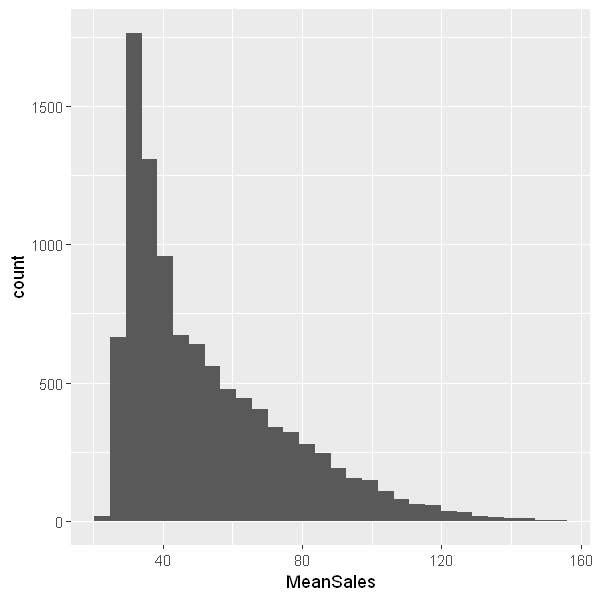

In [46]:
options(repr.plot.width=5, repr.plot.height=5)
ggplot(mean_sales,aes(MeanSales))+
    geom_histogram()

In [26]:
x<-kmeansruns(mean_sales[['MeanSales']],krange=2:4,criterion = 'asw')

In [27]:
x$bestk
x$centers

[1] 2

[,1]    
1 82.78201
2 39.92402

In [28]:
cluster_products = cbind(mean_sales,cluster = x$cluster)

In [29]:
### kmeans cluster of stores based on sale
sales_oos = sales_oos %>% inner_join(cluster_products %>% mutate(cluster=as.factor(cluster)), by= 'product')  
sales_oos =sales_oos %>% select(-MeanSales)
head(sales_oos)

product date       sales oosflag woy month quarter year day wom ...
1 0       2012-03-01 0     0       9   3     1       2012 1   1   ...
2 1       2012-03-01 0     0       9   3     1       2012 1   1   ...
3 2       2012-03-01 0     0       9   3     1       2012 1   1   ...
4 3       2012-03-01 1     0       9   3     1       2012 1   1   ...
5 4       2012-03-01 0     0       9   3     1       2012 1   1   ...
6 5       2012-03-01 0     0       9   3     1       2012 1   1   ...
  promo_p_l90 promo_p_l180 brandpromo promo_b_l3 promo_b_l7 promo_b_l14
1 0           0            0          0          0          0          
2 0           0            0          0          0          0          
3 0           0            0          0          0          0          
4 0           0            0          0          0          0          
5 0           0            0          0          0          0          
6 0           0            0          0          0          0          
  promo_b_l28 promo_b_l90 promo_b_l180 cluster
1 0           0           0            2      
2 0           0           0            2      
3 0           0           0            2      
4 0           0           0            1      
5 0           0           0            2      
6 0           0           0            1

### Lag variables on sales

In [30]:
rm('brand_promo', 'cluster_products' ,'map', 'mean_sales', 'oos' ,'product_promo', 'sales', 'x', 'y')
gc()

Warning message in rm("brand_promo", "cluster_products", "map", "mean_sales", "oos", :
"object 'y' not found"

used      (Mb)   gc trigger (Mb)   max used   (Mb)  
Ncells   3381539  180.6    6518628  348.2    6518628  348.2
Vcells 360219805 2748.3 1165472114 8891.9 1165468716 8891.9

In [36]:
scopy= sales_oos %>% select(product,date,smooth_sales_n) %>% arrange(product,date)
head(scopy)

product date       smooth_sales_n
1 0       2012-03-01 0             
2 0       2012-03-02 1             
3 0       2012-03-03 1             
4 0       2012-03-04 1             
5 0       2012-03-05 1             
6 0       2012-03-06 1

In [35]:
scopy$sales_lag_1 <- NA
scopy$sales_lag_2 <- NA
scopy$sales_lag_3 <- NA
scopy$sales_lag_4 <-NA
scopy$sales_lag_5 <-NA
scopy$sales_lag_6 <- NA
scopy$sales_lag_7 <- NA
#scopy$promo_p_l365 <-NA

for (j in seq(0:9999))
{   i=j-1
    message(i)
    y = as.matrix(filter(scopy,product==i) %>% select(smooth_sales_n))
    scopy[(1+i*1433):(1433*i+1433),'sales_lag_1'] = Lag(y, 1)
    scopy[(1+i*1433):(1433*i+1433),'sales_lag_2'] = Lag(y, 2)
    scopy[(1+i*1433):(1433*i+1433),'sales_lag_3'] = Lag(y, 3)
    scopy[(1+i*1433):(1433*i+1433),'sales_lag_4'] = Lag(y, 4)
    scopy[(1+i*1433):(1433*i+1433),'sales_lag_5'] = Lag(y, 5)
    scopy[(1+i*1433):(1433*i+1433),'sales_lag_6'] = Lag(y, 6)
    scopy[(1+i*1433):(1433*i+1433),'sales_lag_7'] = Lag(y, 7)

    #scopy[(1+i*1433):(1433*i+1433),'promo_p_l365'] = roll_sum(y, 365)
      }

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338


6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977


8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616


In [36]:
myList <- setNames(lapply(vector("list", ncol(scopy[4:10])), function(x) x <- 0), names(scopy[4:10]))
scopy[4:10] = scopy[4:10] %>% replace_na(myList)
write_csv(scopy,"scopy_lag_sales.csv")

In [31]:
#scopy = read_csv("scopy_lag_sales.csv")

Parsed with column specification:
cols(
  product = col_integer(),
  date = col_date(format = ""),
  smooth_sales_n = col_double(),
  sales_lag_1 = col_double(),
  sales_lag_2 = col_double(),
  sales_lag_3 = col_double(),
  sales_lag_4 = col_double(),
  sales_lag_5 = col_double(),
  sales_lag_6 = col_double(),
  sales_lag_7 = col_double()
)


In [32]:
sales_oos = sales_oos %>% left_join(select(scopy,-smooth_sales_n), by = c('product','date'))
nrow(sales_oos)

[1] 14330000

### Window variables

In [35]:
scopy= sales_oos %>% select(product,date,smooth_sales_n) %>% arrange(product,date)
head(scopy)

product date       smooth_sales_n
1 0       2012-03-01 0             
2 0       2012-03-02 1             
3 0       2012-03-03 1             
4 0       2012-03-04 1             
5 0       2012-03-05 1             
6 0       2012-03-06 1

In [45]:
scopy$l_w  <- NA
scopy$l_m  <- NA
scopy$l_q  <- NA
scopy$l_hy <- NA
scopy$l_y  <- NA
#scopy$l_2y  <- NA

#scopy$promo_p_l365 <-NA

for (j in seq(0:9999))
{   i=j-1
    message(i)
    y = as.matrix(filter(scopy,product==i) %>% select(smooth_sales_n))
    scopy[(1+i*1433):(1433*i+1433),'l_w'] =  roll_sum(y, 7)
    scopy[(1+i*1433):(1433*i+1433),'l_m'] =  roll_sum(y, 30)
    scopy[(1+i*1433):(1433*i+1433),'l_q'] =  roll_sum(y, 90)
    scopy[(1+i*1433):(1433*i+1433),'l_hy'] = roll_sum(y, 180)
    scopy[(1+i*1433):(1433*i+1433),'l_y'] =  roll_sum(y, 365)
    #scopy[(1+i*1433):(1433*i+1433),'l_2y'] = roll_sum(y, 730)
    #scopy[(1+i*1433):(1433*i+1433),'promo_p_l365'] = roll_sum(y, 365)
      }

[1] 0
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 13

In [46]:
myList <- setNames(lapply(vector("list", ncol(scopy[4:9])), function(x) x <- 0), names(scopy[4:9]))
scopy[4:9] = scopy[4:9] %>% replace_na(myList)
write_csv(scopy,"scopy_window_sales.csv")

In [33]:
#scopy = read_csv("copy_window_sales.csv")

Parsed with column specification:
cols(
  product = col_integer(),
  date = col_date(format = ""),
  smooth_sales_n = col_double(),
  l_w = col_double(),
  l_m = col_double(),
  l_q = col_double(),
  l_hy = col_double(),
  l_y = col_double(),
  l_2y = col_double()
)


In [34]:
sales_oos = sales_oos %>% left_join(select(scopy,-smooth_sales_n), by = c('product','date'))
#nrow(sales_oos)
#sales_oos = sales_oos %>% select(-l_2y)
paste(nrow(sales_oos),ncol(sales_oos))

[1] "14330000 47"

In [38]:
filter(sales_oos,product==4)[400:500,]

product date       sales oosflag woy month quarter year day wom ...
1   4       2013-04-04  0    1       14  4     2       2013  4  1   ...
2   4       2013-04-05  0    1       14  4     2       2013  5  1   ...
3   4       2013-04-06  0    1       14  4     2       2013  6  1   ...
4   4       2013-04-07  0    1       14  4     2       2013  7  1   ...
5   4       2013-04-08 42    0       14  4     2       2013  8  2   ...
6   4       2013-04-09 32    0       15  4     2       2013  9  2   ...
7   4       2013-04-10 31    0       15  4     2       2013 10  2   ...
8   4       2013-04-11 31    0       15  4     2       2013 11  2   ...
9   4       2013-04-12 26    0       15  4     2       2013 12  2   ...
10  4       2013-04-13 34    0       15  4     2       2013 13  2   ...
11  4       2013-04-14 34    0       15  4     2       2013 14  2   ...
12  4       2013-04-15  2    0       15  4     2       2013 15  3   ...
13  4       2013-04-16 70    0       16  4     2       2013 16  3   ...
14  4       2013-04-17 15    0       16  4     2       2013 17  3   ...
15  4       2013-04-18 21    0       16  4     2       2013 18  3   ...
16  4       2013-04-19 17    0       16  4     2       2013 19  3   ...
17  4       2013-04-20 17    0       16  4     2       2013 20  3   ...
18  4       2013-04-21 22    0       16  4     2       2013 21  3   ...
19  4       2013-04-22 17    0       16  4     2       2013 22  4   ...
20  4       2013-04-23 28    0       17  4     2       2013 23  4   ...
21  4       2013-04-24 29    0       17  4     2       2013 24  4   ...
22  4       2013-04-25 31    0       17  4     2       2013 25  4   ...
23  4       2013-04-26 NA    0       17  4     2       2013 26  4   ...
24  4       2013-04-27 30    0       17  4     2       2013 27  4   ...
25  4       2013-04-28 29    0       17  4     2       2013 28  4   ...
26  4       2013-04-29 36    0       17  4     2       2013 29  5   ...
27  4       2013-04-30 37    0       18  4     2       2013 30  5   ...
28  4       2013-05-01  1    0       18  5     2       2013  1  1   ...
29  4       2013-05-02  1    0       18  5     2       2013  2  1   ...
30  4       2013-05-03  1    0       18  5     2       2013  3  1   ...
... ...     ...        ...   ...     ... ...   ...     ...  ... ...    
72  4       2013-06-14  0    1       24  6     2       2013 14  2   ...
73  4       2013-06-15  0    1       24  6     2       2013 15  3   ...
74  4       2013-06-16  0    1       24  6     2       2013 16  3   ...
75  4       2013-06-17  0    1       24  6     2       2013 17  3   ...
76  4       2013-06-18  0    1       25  6     2       2013 18  3   ...
77  4       2013-06-19  2    0       25  6     2       2013 19  3   ...
78  4       2013-06-20  1    0       25  6     2       2013 20  3   ...
79  4       2013-06-21  1    0       25  6     2       2013 21  3   ...
80  4       2013-06-22  1    0       25  6     2       2013 22  4   ...
81  4       2013-06-23 49    0       25  6     2       2013 23  4   ...
82  4       2013-06-24 46    0       25  6     2       2013 24  4   ...
83  4       2013-06-25 43    0       26  6     2       2013 25  4   ...
84  4       2013-06-26 44    0       26  6     2       2013 26  4   ...
85  4       2013-06-27 45    0       26  6     2       2013 27  4   ...
86  4       2013-06-28 52    0       26  6     2       2013 28  4   ...
87  4       2013-06-29  0    1       26  6     2       2013 29  5   ...
88  4       2013-06-30  0    1       26  6     2       2013 30  5   ...
89  4       2013-07-01  0    1       26  7     3       2013  1  1   ...
90  4       2013-07-02  0    1       27  7     3       2013  2  1   ...
91  4       2013-07-03  0    1       27  7     3       2013  3  1   ...
92  4       2013-07-04 44    0       27  7     3       2013  4  1   ...
93  4       2013-07-05 50    0       27  7     3       2013  5  1   ...
94  4       2013-07-06 44    0       27  7     3       2013  6  1   ...
95  4       2013-07-07 51    0       27  7  

In [35]:
sales_oos =sales_oos %>% mutate(product = as.factor(product),woy= as.numeric(woy),
                     month = as.numeric(month),quarter = as.numeric(quarter),year=as.numeric(year),day=as.numeric(day),
                     wom =as.numeric(wom),
                     doy = as.numeric(doy),
                     sem = as.numeric(sem),
                     qday = as.numeric(qday),
                     monthsize =  as.numeric(monthsize),
                     lp_yr = lp_yr * 1
                     ,wtrflag = ifelse(dow_clubbed=='WTR',1,0)
                     
                     ) %>% select(-sales,-dow,-smooth_sales,-oosflag,-dow_clubbed)

### Subsetting 3 complete montly seasonal cycles for training and exploring

```
Nrows()	| Train (3/1/2012 - 4/20/2015)|Val	(4/21/2015 - 9/11/2015)   | Test(9/12/2015 - 2/1/2016)
--------------------------------------
1433      | 1146 |  143	| 143.3
```

In [36]:
ls()
#rm(i,j,myList,scopy,y,brand_product_promo)
gc()

[1] "brand_product_promo" "sales_oos"           "scopy"              
[4] "smpl"

used      (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells   3391188  181.2    6518628   348.2    6518628   348.2
Vcells 646844358 4935.1 1398646536 10670.9 1394596237 10640.0

In [37]:
ts_traindata = filter(sales_oos, between(date,ymd('2012-03-01'),ymd('2015-04-20')))
ts_valdata = filter(sales_oos, between(date,ymd('2015-04-21'),ymd('2015-09-11')))
ts_testdata = filter(sales_oos, between(date,ymd('2015-09-12'),ymd('2016-02-01')))

print(paste(nrow(ts_traindata),ncol(ts_traindata),length(unique(ts_traindata$product)),length(unique(ts_traindata$date))))
print(paste(nrow(ts_valdata),ncol(ts_valdata),length(unique(ts_valdata$product)),length(unique(ts_valdata$date))))
print(paste(nrow(ts_testdata),ncol(ts_testdata),length(unique(ts_testdata$product)),length(unique(ts_testdata$date))))

[1] "11460000 43 10000 1146"
[1] "1440000 43 10000 144"
[1] "1430000 43 10000 143"


### Model 1: Time series regression : for getting the trend

1137
6222
6091


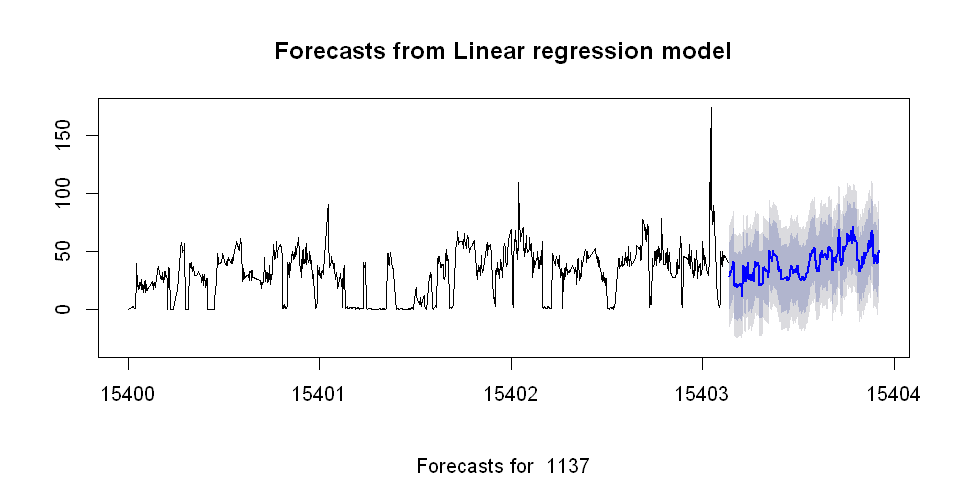

6231


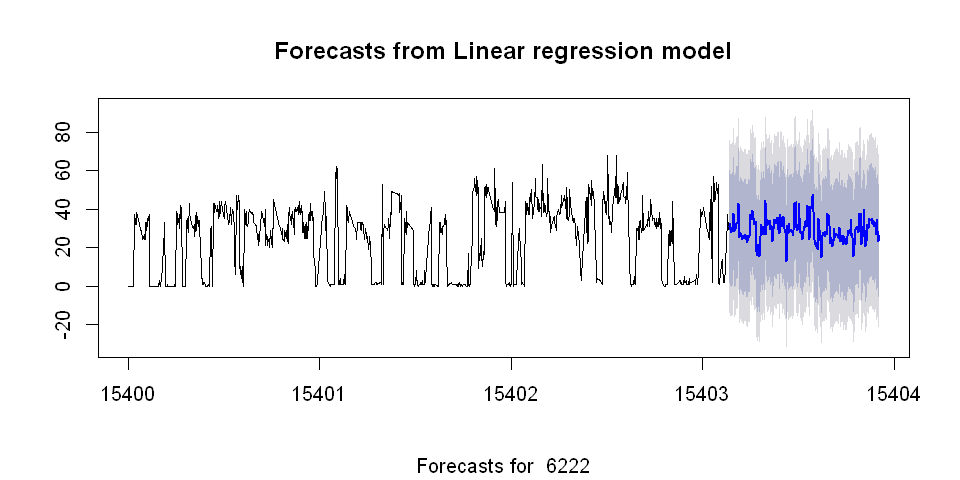

8605


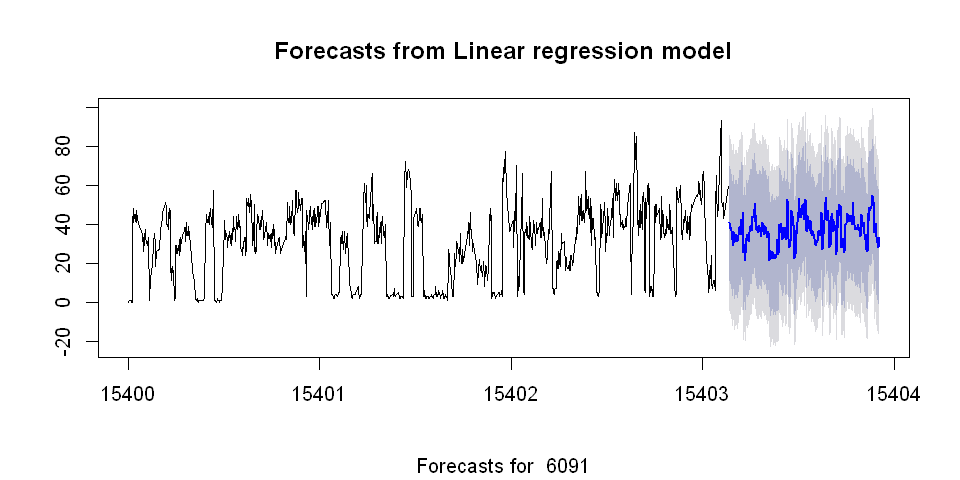

6399


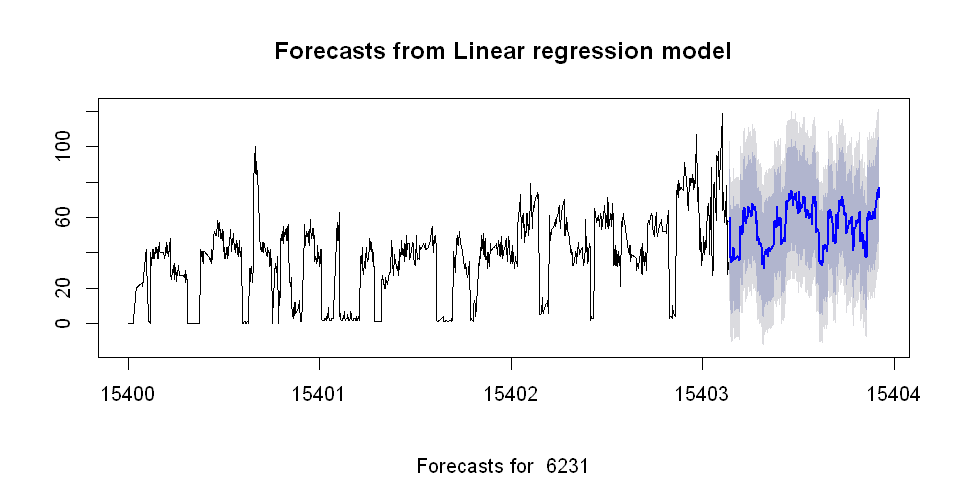

94


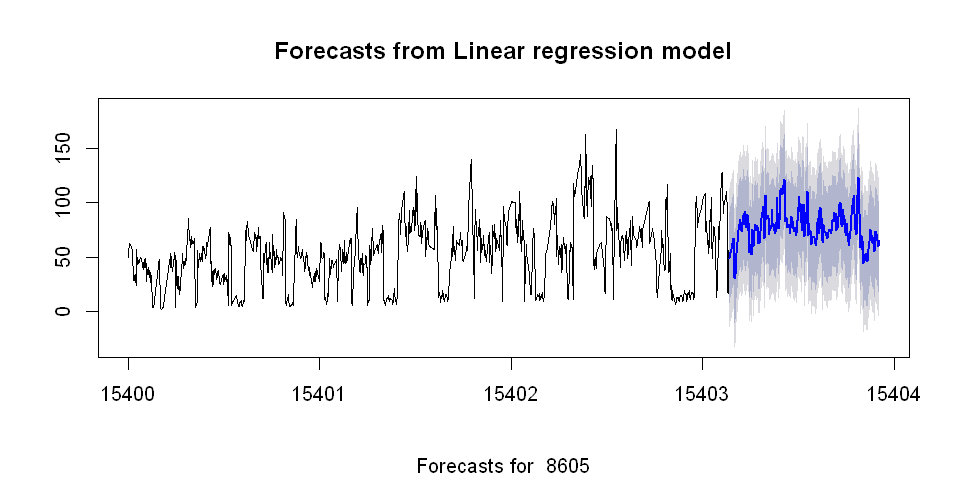

2323


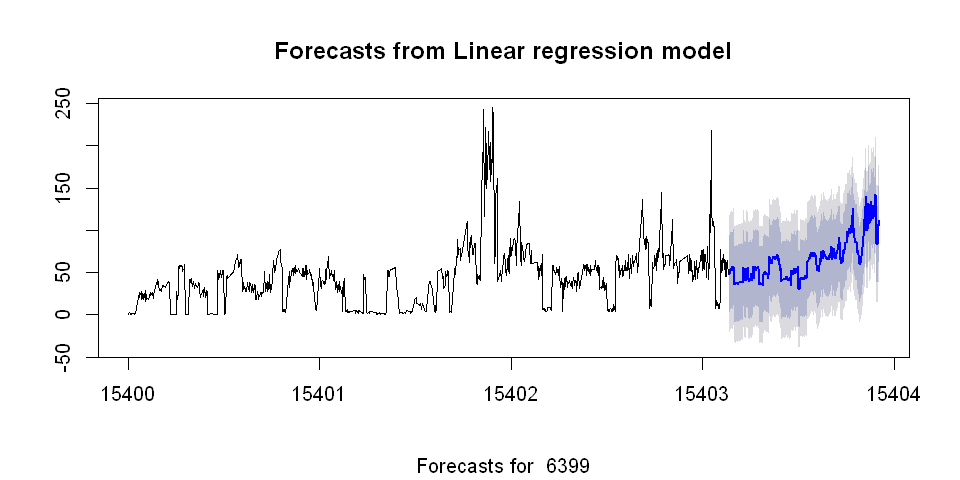

6655


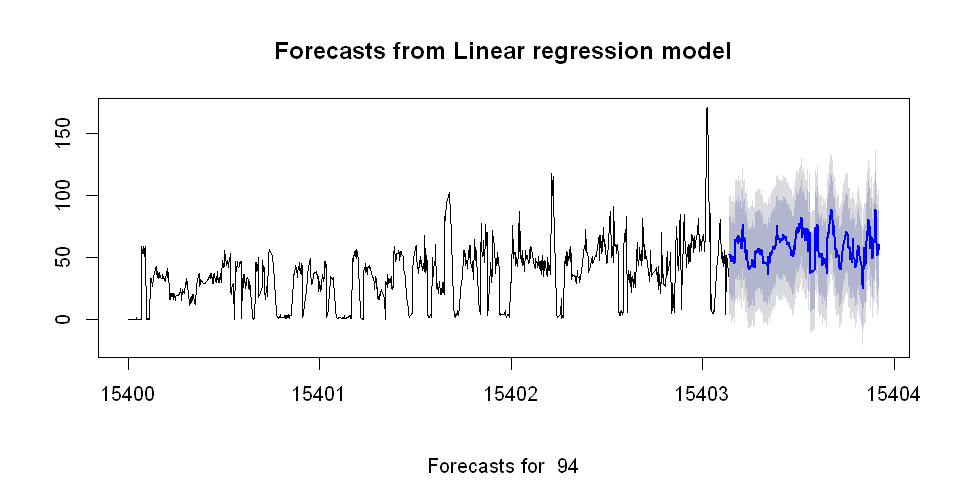

5137


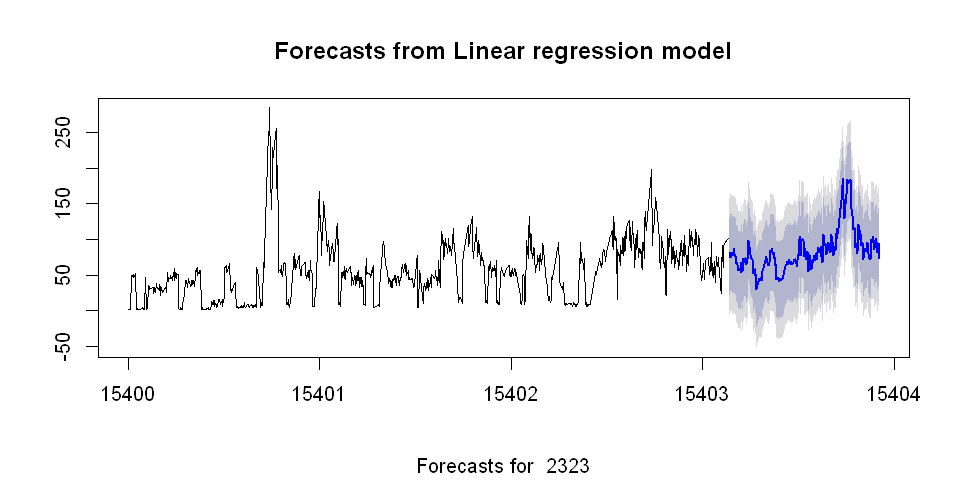

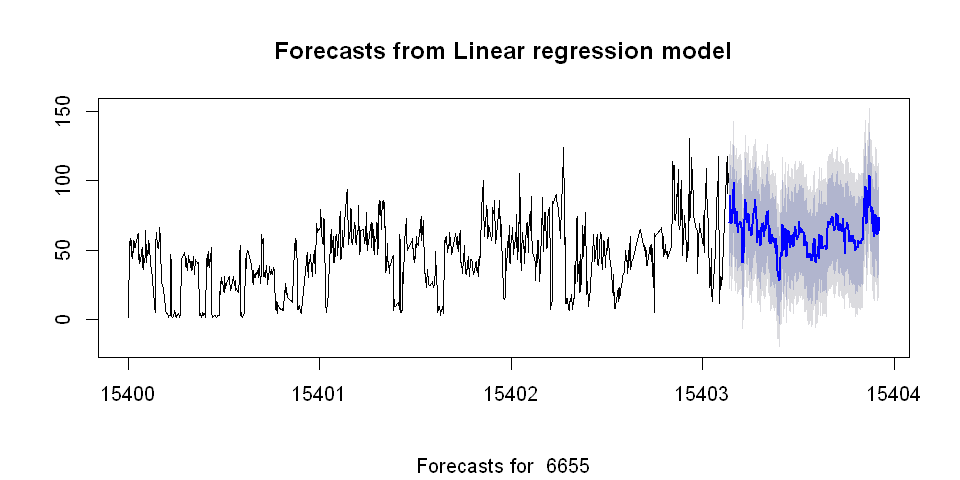

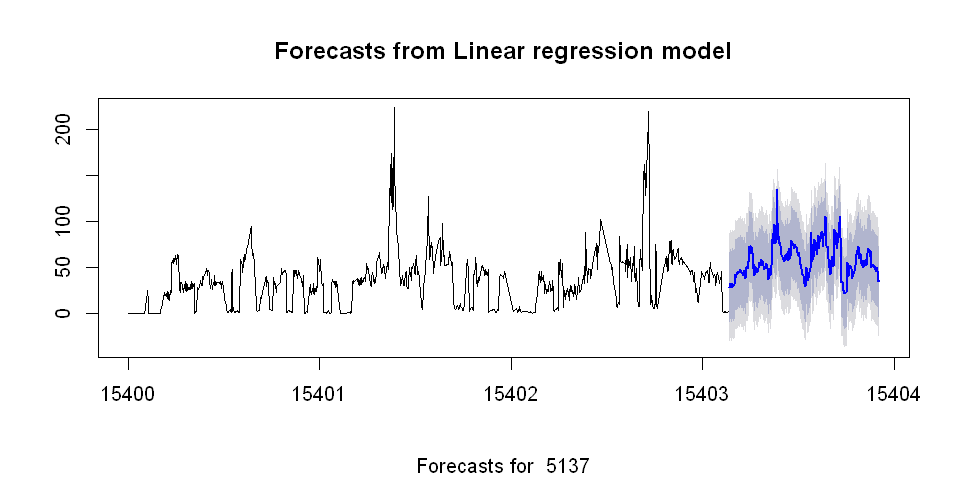

In [69]:
for(j in (smpl[1:10]))
{
    i=j-1
    
    message(i)
    x = ts_traindata %>% filter(product==i)  %>% select(smooth_sales_n)
    fit <- tslm(msts(x,
         seasonal.periods=c(7,365.25), start=ymd('2012-03-01')) ~ trend + season)
   y = forecast(fit, h = 287)
    plot(forecast(fit, h = 287))
    title(sub = paste("Forecasts for ",i))
    if(i==0) {z=y$mean}
    else {z= rbind(z,y$mean)}
}

In [48]:
paste(nrow(z),ncol(z))

[1] "10000 287"

In [53]:
write_csv(as.data.frame(cbind(seq(0,9999,1),z)),"lm_otp.csv")

In [42]:
lmotp = read_csv("lm_otp.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  V1 = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
"number of columns of result is not a multiple of vector length (arg 1)"Warning message:
"9 parsing failures.
row # A tibble: 5 x 5 col     row col   expected           actual file                                    expected   <int> <chr> <chr>              <chr>  <chr>                                   actual 1  1001 V1    no trailing chara~ e3     "'C:\\Users\\somen\\Desktop\\Pepsi\\Pe~ file 2  2001 V1    no trailing chara~ e3     "'C:\\Users\\somen\\Desktop\\Pepsi\\Pe~ row 3  3001 V1    no trailing chara~ e3     "'C:\\Users\\somen\\Desktop\\Pepsi\\Pe~ col 4  4001 V1    no trailing chara~ e3     "'C:\\Users\\somen\\Desktop\\Pepsi\\Pe~ expected 5  5001 V1    no trailing chara~ e3     "'C:\\Users\\somen\\Desktop\\Pepsi\\Pe~
... ................. ... .......................................................

In [68]:
x = 0 
for(i in seq(0,10000,1))
{   x = x + 
    sqrt(sum((lmotp %>% filter(V1 == 0) %>% t() -
    sales_oos %>% filter(product ==1, date > ymd('2015-04-20')) %>% select(smooth_sales_n))^2)/287)
    }

print(paste("Val + Test RMSE:",x/10000))

[1] "Val + Test RMSE: 20.0744545385749"


### Model 2: XGboost for capturing promo/lag effect

In [72]:
set.seed(1234)

In [46]:
?sample

In [47]:
nrow(ts_traindata)

[1] 11460000

In [73]:
smpl1 <- sample(seq(1,11460000), 1000000, replace = FALSE, prob = NULL)
smpl2 <- sample(seq(1,144000), 144000, replace = FALSE, prob = NULL)
#ts_traindata

In [74]:
dtrain<-xgb.DMatrix(data=data.matrix(ts_traindata[smpl1,] %>% select(-smooth_sales_n,-date)),label=ts_traindata[smpl1,]$smooth_sales_n)
dval  <-xgb.DMatrix(data=data.matrix(ts_valdata[smpl2,] %>% select(-smooth_sales_n,-date)),label=ts_valdata[smpl2,]$smooth_sales_n)
watchlist<-list(val=dval,train=dtrain)
eta               = c(0.2,0.4)
max_depth         = c(4,6,8)
subsample         = c(0.25,0.35,0.5)
colsample_bytree  = c(0.1,0.25,0.5)
nrounds           = c(100,200,300)

In [ ]:
#### Searching space without Hyperopt to tune XGB
for(i in c(1,2))
    {
        for(j in c(1,2,3))
            {
            for(k in c(1,2,3))
                {
                    for(l in c(1,2,3))
                        {
                        for(m in c(1,2,3))
                            {
                        
                                param <- list(objective           = "reg:linear", 
                                    booster = "gbtree",
                                    eta                 = eta[i],
                                    max_depth           = max_depth[j],
                                    subsample           = subsample[k],
                                    colsample_bytree    = colsample_bytree[l]
                                    )
    
    
                                 clf <- xgb.train(      params                = param, 
                                                        data                  = dtrain, 
                                                        nrounds               = nrounds[m],
                                                        verbose               = 2,
                                                        early_stopping_rounds = 25,
                                                        watchlist             = watchlist,
                                                        maximize              = FALSE,
                                                        eval                  = 'RMSE'
                                                        #nthread               = 5
                                    )

                                xgb.save(clf, paste("\\",i,"_",j,"_",k,"_",l,"_",m))
                                write.csv(clf$evaluation_log,paste("\\",i,"_",j,"_",k,"_",l,"_",m,".csv"))
                        
                        
                            }
                        }
                }
            }
    }

In [82]:
#ts_traindata = read_csv("train.csv")
#ts_valdata = read_csv("val.csv")
#ts_testdata = read_csv("test.csv")

In [76]:
 param <- list(objective           = "reg:linear", 
                                    booster = "gbtree",
                                    eta                 = eta[1],
                                    max_depth           = max_depth[2],
                                    subsample           = subsample[1],
                                    colsample_bytree    = colsample_bytree[3]
                                    )
    
    
                    clf <- xgb.train(      params                = param, 
                                                        data                  = dtrain, 
                                                        nrounds               = nrounds[3],
                                                        verbose               = 2,
                                                        early_stopping_rounds = 25,
                                                        watchlist             = watchlist,
                                                        maximize              = FALSE,
                                                        eval                  = 'RMSE'
                                                        #nthread               = 5
                                    )

[15:31:54] amalgamation/../src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[1]	val-rmse:71.427353	train-rmse:52.689838 
Multiple eval metrics are present. Will use train_rmse for early stopping.
Will train until train_rmse hasn't improved in 25 rounds.

[15:31:55] amalgamation/../src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[2]	val-rmse:59.569420	train-rmse:44.007137 
[15:31:57] amalgamation/../src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[3]	val-rmse:49.397324	train-rmse:36.641781 
[15:31:59] amalgamation/../src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[4]	val-rmse:41.684452	train-rmse:31.071611 
[15:32:01] amalgamation/../src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[5]	val-rmse:35.648186	train-rmse:26.7540

In [82]:
bst=xgb.load("1 _ 2 _ 1 _ 3 _ 3 ")

In [ ]:
pred2 <- predict(bst,data.matrix(ts_testdata %>% select(-smooth_sales_n,-date)))

true_val<-ts_testdata$smooth_sales_n
# And now the test
print(paste("RMSE", sqrt(sum((pred2-true_val)^2)/length(ts_testdata$smooth_sales_n))))